# Coverage depth analysis

Coverage depth histogram

In [26]:
from common import *
import numpy as np 
import pandas as pd

drop_cols = ["percentMeth_C", "percentMeth_5mC", "percentMeth_5hmC", "strand"]

prom_raw = readModkit("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "Nanopore")
oxbs_raw = readBismarkZeroCov("data_tables/data_files/public/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "oxBS-seq")
tab_raw = readBismarkZeroCov("data_tables/data_files/public/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "TAB-seq")

histogram_df = pd.concat([prom_raw, oxbs_raw, tab_raw])

In [43]:
from common import *

prom_pr = Modkit2Pr("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False, True)
oxbs_pr = Bismark2Pr("data_tables/data_files/public/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False, True)
tab_pr = Bismark2Pr("data_tables/data_files/public/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False, True)

Changing colnames to be PyRanges compatible...
Done
Changing colnames to be PyRanges compatible...
Done
Changing colnames to be PyRanges compatible...
Done


In [45]:
prom_pr.as_df().query("readCount >= 10")["N_hmC"].sum()/prom_pr.as_df().query("readCount >= 10")["readCount"].sum()

0.08166272631272153

In [47]:
tab_pr.as_df().query("readCount >= 10")["N_mod"].sum()/tab_pr.as_df().query("readCount >= 10")["readCount"].sum()

0.1023957340956094

In [18]:
# exclusive sets
prom_excl = len(prom_pr.intersect(oxbs_pr, invert=True).intersect(tab_pr, invert=True))
tab_excl = len(tab_pr.intersect(oxbs_pr, invert=True).intersect(prom_pr, invert=True))
oxbs_excl = len(oxbs_pr.intersect(tab_pr, invert=True).intersect(prom_pr, invert=True))

# three-way intersect 
prom_tab_oxbs = prom_pr.join(tab_pr, suffix="_TAB").join(oxbs_pr, suffix="_oxBS")

# two-way intersects
prom_tab = len(prom_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
prom_oxbs = len(prom_pr.intersect(oxbs_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
tab_oxbs = len(oxbs_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))

total = sum([prom_excl, tab_excl, prom_tab, oxbs_excl, prom_oxbs, tab_oxbs, len(prom_tab_oxbs)])


In [54]:
intersect = len(prom_tab_oxbs)
bar_df = pd.DataFrame({"method" : ["Nanopore", "TAB-seq", "oxBS-seq"], 
                       "present" : [prom_excl/total, tab_excl/total, oxbs_excl/total],
                       "missing" : [1 - (sum([prom_excl, prom_oxbs, prom_tab, intersect])/total), 
                                     1 - (sum([tab_excl, tab_oxbs, prom_tab, intersect])/total), 
                                     1 - (sum([oxbs_excl, tab_oxbs, prom_oxbs, intersect])/total)]})



Feature intersection

In [100]:
import FeatureReferences
import pyranges as pr 

def annotateFeatures(pyrange): 
    annotated_df = pyrange.join(feature_ref, strandedness=False, slack=0, apply_strand_suffix=False).as_df()
    annotated_df = annotated_df.replace(["3UTR", "5UTR", "TSS"], ["Exon", "Exon", "Promoter"])
    intergenic = pyrange.intersect(feature_ref, invert=True).as_df()
    intergenic = intergenic.assign(feature_type = "Intergenic")
    return pd.concat([annotated_df, intergenic])

feature_ref = FeatureReferences.featureRefPyRange("./feature_references/genic/")

In [101]:
annotated_prom = annotateFeatures(prom_pr).assign(method="Nanopore")
annotated_tab = annotateFeatures(tab_pr).assign(method="TAB-seq")
annotated_oxbs = annotateFeatures(oxbs_pr).assign(method="oxBS-seq")

In [105]:
drop_cols = ["percentMeth_5hmC", "percentMeth_5mC", "__ix__", "N_hmC", "N_mC", "N_unmod", "N_mod", "N_C", "Start_b", "End_b", "Strand_b"]
annotated_prom, annotated_tab, annotated_oxbs = map(lambda df: df.drop(columns=drop_cols, errors="ignore"), [annotated_prom, annotated_tab, annotated_oxbs])
annotated_all = pd.concat([annotated_prom, annotated_tab, annotated_oxbs])
annotated_all["feature_type"] = pd.Categorical(annotated_all["feature_type"], ordered=True, categories=["Intergenic", "Promoter", "Intron", "Exon"])

## Figure

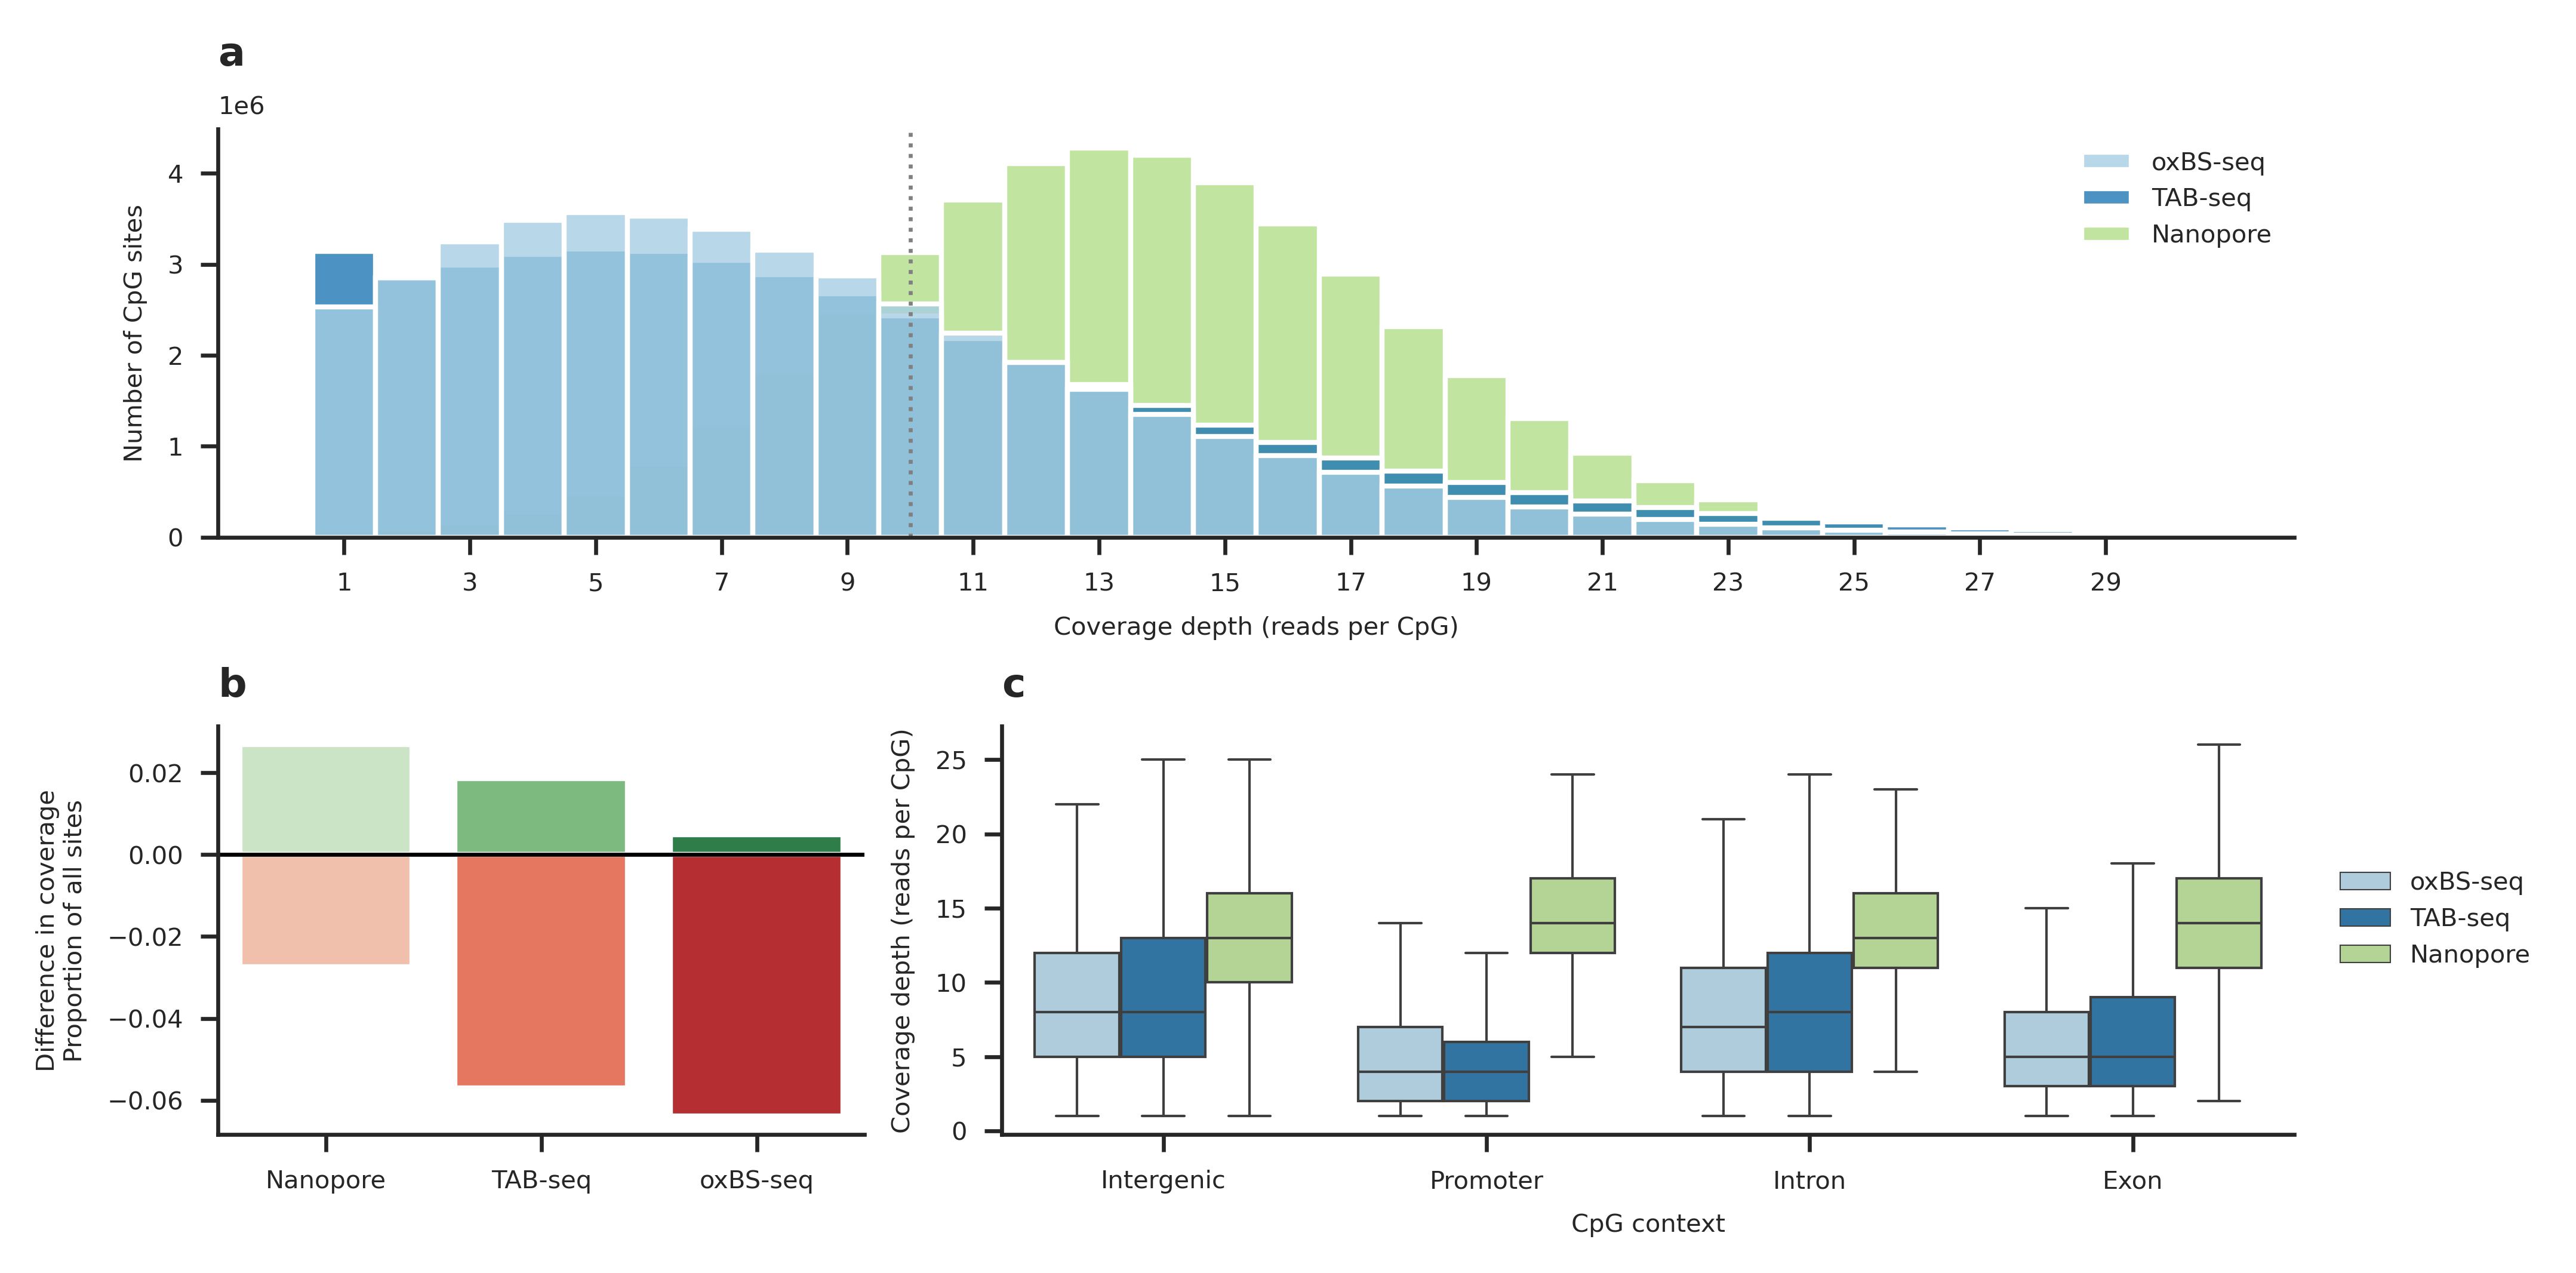

In [109]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import string

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(180/25.4, 89/25.4), dpi=600)
gs = GridSpec(2, 2, fig, width_ratios=(.5, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Panel 1 #
sns.histplot(annotated_all, x="readCount", 
             stat="count", discrete=True, binwidth=1, binrange=(1, 30),
             hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
             legend=True, alpha=0.8, ax=ax1)

ax1.axvline(10, ls=":", c="grey", lw=0.8, label="Minimum")
ax1.set_ylabel("Number of CpG sites")
ax1.set_xlabel("Coverage depth (reads per CpG)")

ax1.set_xticks(range(1, 31, 2))
sns.move_legend(ax1, "upper right", title=None, frameon=False)

# Panel 2 # 
sns.barplot(x=bar_df["method"], y=bar_df["present"], hue=bar_df["method"], palette="Greens", dodge=False, ax=ax2)
sns.barplot(x=bar_df["method"], y=-bar_df["missing"], hue=bar_df["method"], palette="Reds", dodge=False, ax=ax2)

ax2.legend([], [], frameon=False)
ax2.set_ylabel("Difference in coverage\nProportion of all sites")
ax2.set_xlabel(None)
ax2.axhline(0, c="k", lw=.8)

# Panel 3 #
sns.boxplot(annotated_all, x="feature_type", y="readCount", 
            hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
            dodge=True, linewidth=0.5, showfliers=False, 
            ax=ax3)

ax3.set_xlabel("CpG context")
ax3.set_ylabel("Coverage depth (reads per CpG)")

ax3.legend(title=None, frameon=False, bbox_to_anchor=(1.2, .7))

# Panel 3 # 

sns.despine(fig)

for ax, letter in zip([ax1, ax2, ax3], string.ascii_lowercase[:3]):
    ax.set_title(letter, loc="left", fontsize=8, fontweight="bold")

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/coverage_and_depth.png", dpi=600)


Removing the pie chart from the main figure now that the comparison is made dataset-dataset rather than dataset-all

In [ ]:
from common import pieData

pie_values, pie_labels = pieData(readcount_features, "feature_type")
# Panel 3 # 
ax3.pie(pie_values, labels=pie_labels, explode=(0, 0, 0, 0.2), startangle=195, radius=1.25, 
        colors=sns.color_palette("Paired", 4),
        autopct="%1.1f%%",
        pctdistance=1.2, labeldistance=1.4)
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")


# CpG level comparison

In [265]:
import common 
import pandas as pd

prom_oxbs_data = pd.read_csv("data_tables/data_files/processed/prom_oxbs_10x_maxDepth.csv")
prom_tab_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

In [33]:
prom_oxbs_data["readCount_Nanopore"].median(), prom_tab_data["readCount_Nanopore"].median()

(14.0, 14.0)

In [56]:
len(prom_tab_data.query("percentMeth_5hmC_TAB >= 40"))/len(prom_tab_data)

0.05160092459341743

In [57]:
len(prom_tab_data.query("percentMeth_5hmC_Nanopore >= 40"))/len(prom_tab_data)

0.02938700274034309

## RMSE

In [266]:
import pyranges as pr
import FeatureReferences
from sklearn import metrics

feature_ref = FeatureReferences.featureRefPyRange("./feature_references/genic/")

def annotateDataframe(dataframe):
    feature_annotations = pr.PyRanges(dataframe).join(feature_ref, strandedness=False, slack=0, apply_strand_suffix=False).as_df()
    feature_annotations = feature_annotations.drop(columns=["Start_b", "End_b", "Strand_b"])
    feature_annotations = feature_annotations.replace(["3UTR", "5UTR"], ["Exon", "Exon"])

    intergenic = pr.PyRanges(dataframe).intersect(feature_ref, invert=True).as_df()
    intergenic = intergenic.assign(feature_type = "Intergenic")

    return pd.concat([feature_annotations, intergenic])

annotated_prom_tab = annotateDataframe(prom_tab_data)
annotated_prom_oxbs = annotateDataframe(prom_oxbs_data)

rmse_5mc = pd.DataFrame(annotated_prom_oxbs.groupby("feature_type").apply(
    lambda group: metrics.mean_squared_error(group["percentMeth_5mC_oxBS"], group["percentMeth_5mC_Nanopore"], squared=False))).assign(mod = "5mC")
rmse_5hmc = pd.DataFrame(annotated_prom_tab.groupby("feature_type").apply(
    lambda group: metrics.mean_squared_error(group["percentMeth_5hmC_TAB"], group["percentMeth_5hmC_Nanopore"], squared=False))).assign(mod = "5hmC")
rmse_df = pd.concat([rmse_5mc, rmse_5hmc])

In [153]:
rmse_df = rmse_df.reset_index().rename(columns={0 : "RMSE"})
rmse_df["feature_type"] = pd.Categorical(rmse_df["feature_type"], ["Intergenic", "Promoter", "TSS", "Intron", "Exon"], ordered=True)

## Lambda DCS control strand FPR

In [267]:
from common import readModkit
import pandas as pd

r1_basecalls = readModkit("data_tables/data_files/lambda/lambda_phage_rep1_modbases_modkit.bed", 10, False, True).query("Start >= 45040")
r2_basecalls = readModkit("data_tables/data_files/lambda/lambda_phage_rep2_modbases_modkit.bed", 10, False, True).query("Start >= 45040")
r_all = pd.merge(r1_basecalls, r2_basecalls, "outer", on=["Chromosome", "Start", "End"], suffixes=["_R1", "_R2"])

In [268]:
r_all["readCount_R1"].sum() + r_all["readCount_R2"].sum()

2196234.0

In [269]:
df_list = []
for index, rep in enumerate([r1_basecalls, r2_basecalls]):
    total_c = rep["readCount"].sum()
    total_hmc = rep["N_hmC"].sum() 
    total_mc = rep["N_mC"].sum()

    fpr_hmc = total_hmc/total_c*100
    fpr_mc = total_mc/total_c*100

    fpr_df = pd.DataFrame({
        "Replicate" : index,
        "Modification" : ["5mC", "5hmC"],
        "False positive rate (%)" : [fpr_mc, fpr_hmc]
    })
    df_list.append(fpr_df)
both = pd.concat(df_list)

mc_mean = both.query("Modification == '5mC'")["False positive rate (%)"].mean()
hmc_mean = both.query("Modification == '5hmC'")["False positive rate (%)"].mean()


## Figure


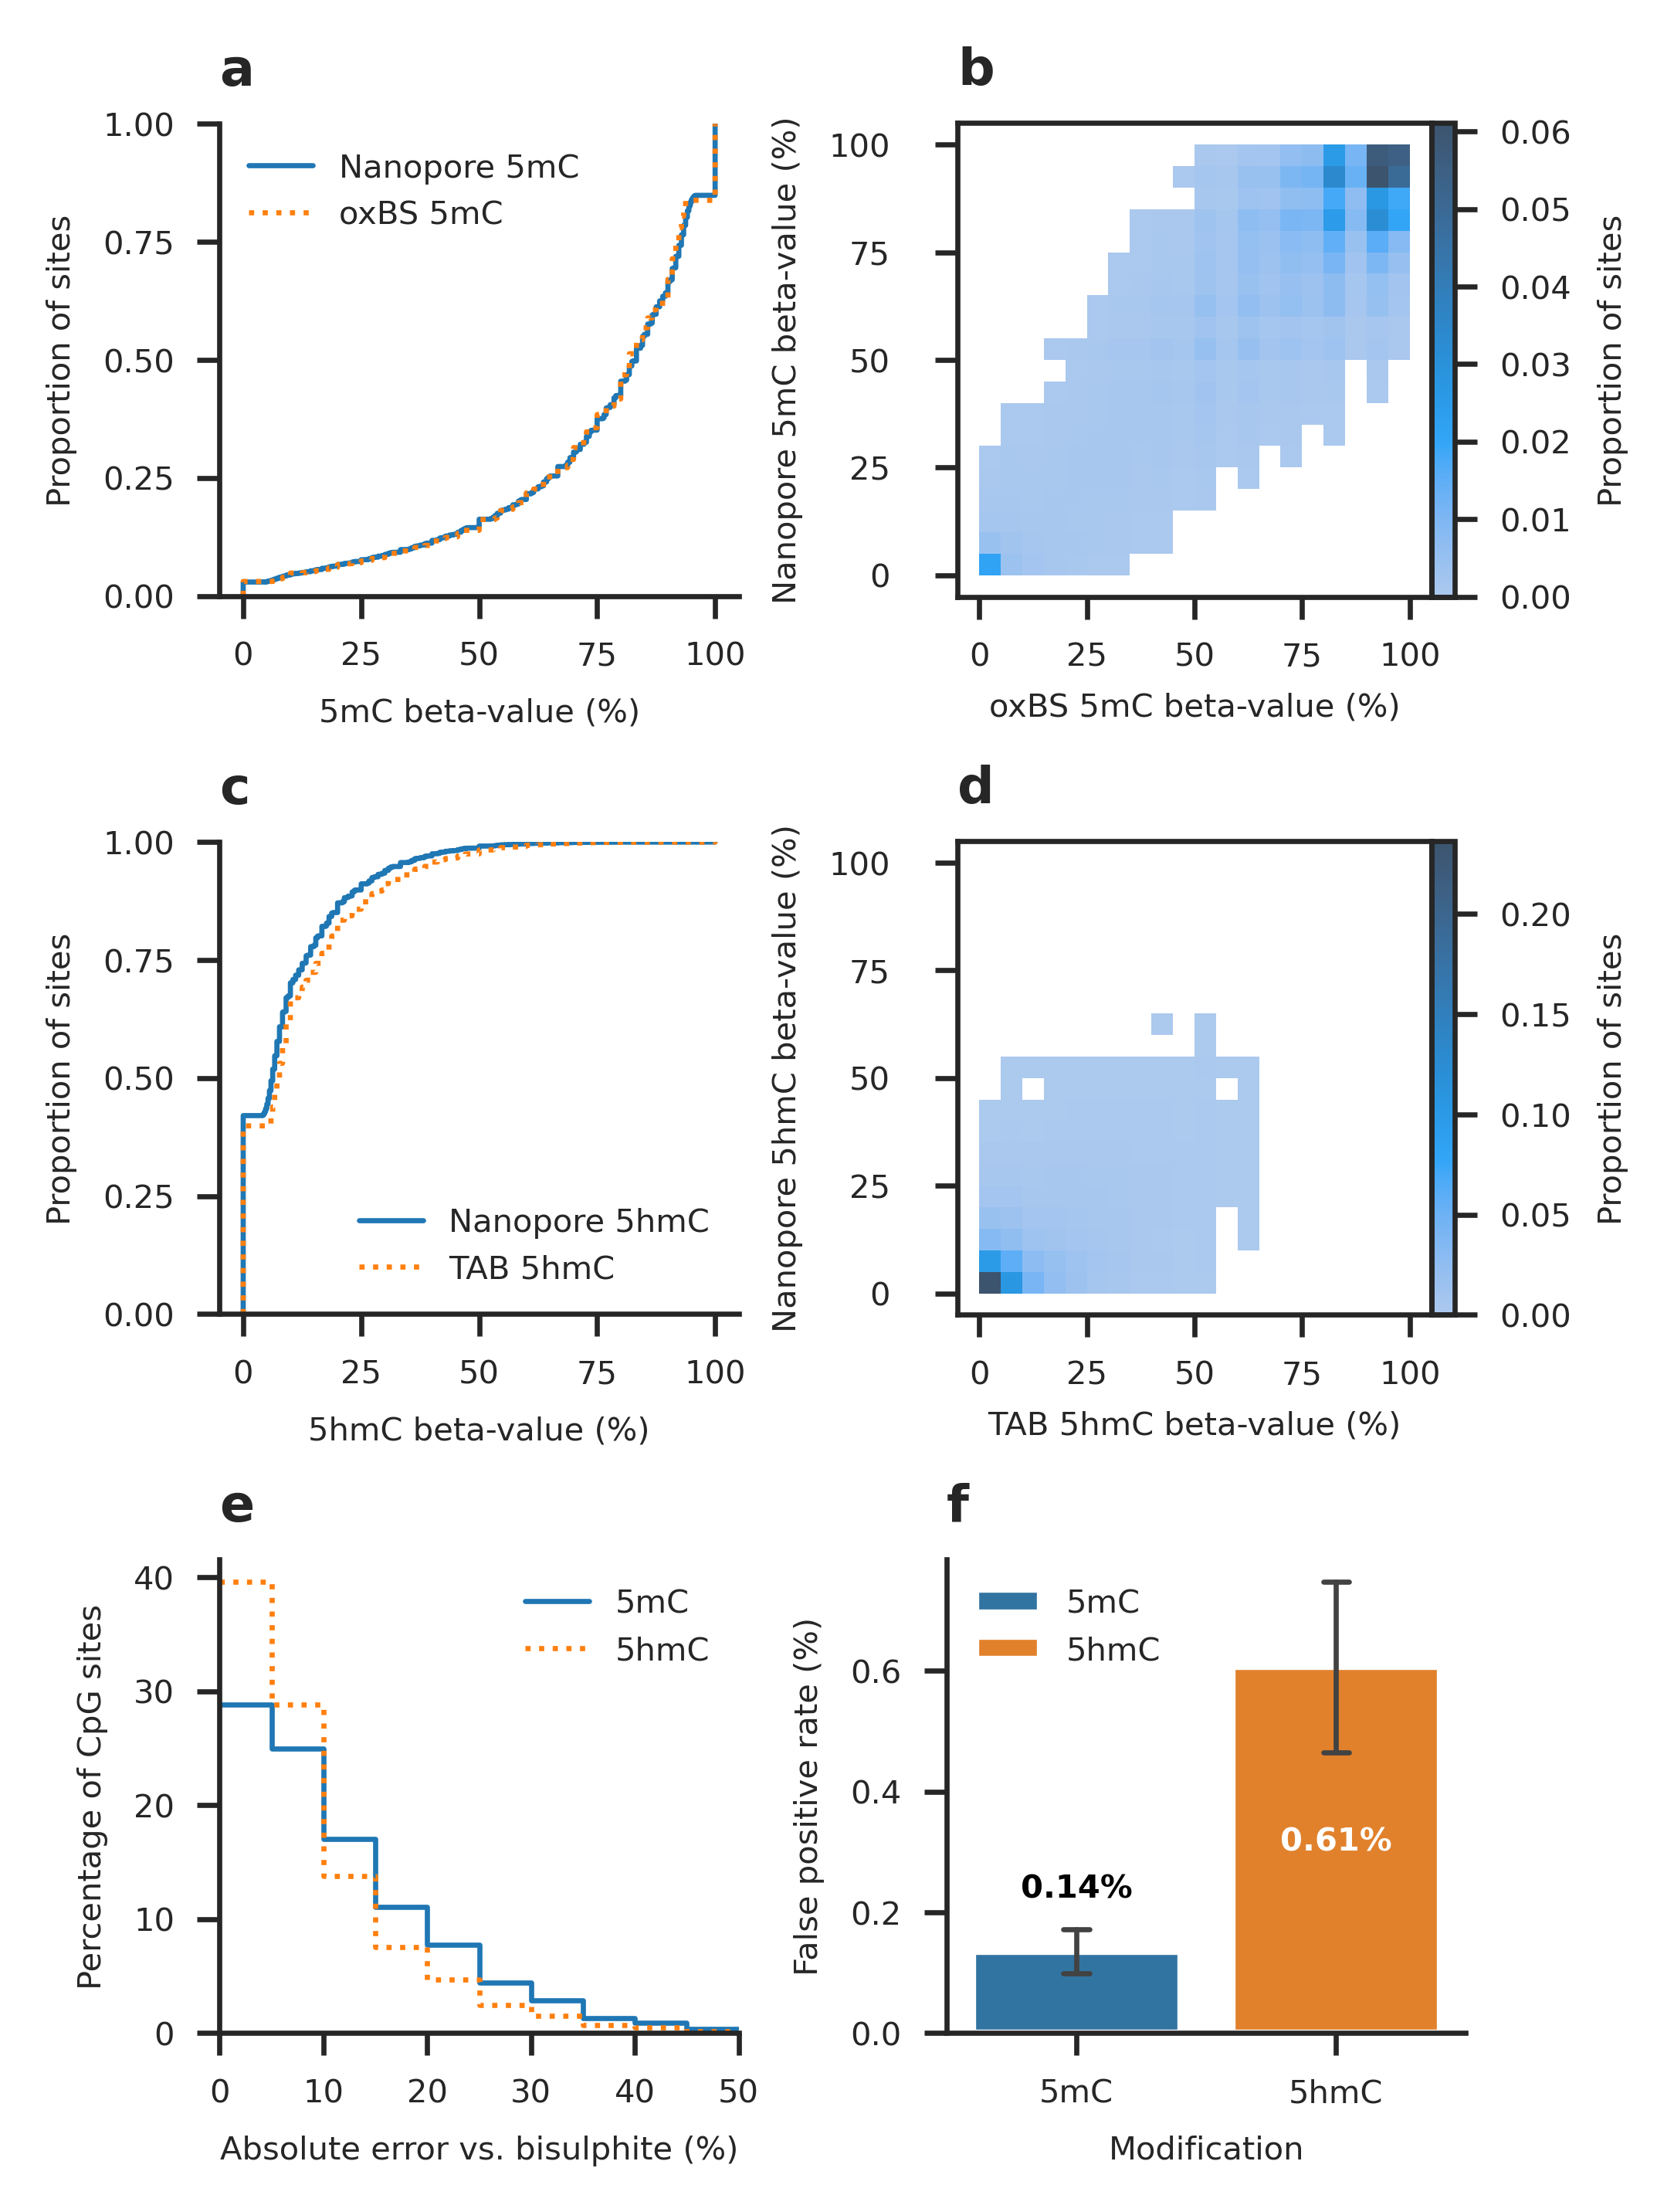

In [271]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import string

sns.set_style("ticks")
mpl.rc('font', size=5)

fig, axes = plt.subplots(3, 2, figsize=(89/25.4, 120/25.4), dpi=600)

value_vars = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_oxBS"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_TAB"]]
labels = [["Nanopore 5mC", "oxBS 5mC"], ["Nanopore 5hmC", "TAB 5hmC"]]

for df, value_var, label, row in zip([prom_oxbs_data, prom_tab_data], value_vars, labels, axes[:4]):
    # Col 1 # 
    ecdf = df.melt(
            id_vars=["Chromosome", "Start", "End"], 
            value_vars=value_var,
            value_name="percentMeth",
            var_name="method")
        
    ax1 = row[0]
    
    line_colors = list(sns.color_palette(n_colors=2).as_hex())
    for var, ls, c, label in zip(value_var, ["-", ":"], line_colors, label):
        sns.ecdfplot(ecdf.query(f"method == '{var}'"),
            x="percentMeth", lw=0.8, ls=ls, color=c, label=label, 
            ax=ax1)
           
    ax1.set_aspect(100)
    ax1.set_xticks(np.arange(0, 125, 25))
    ax1.set_yticks(np.arange(0, 1.25, 0.25))
    ax1.set_ylabel("Proportion of sites")
    
    # Col 2 # 
    ax2 = row[1]
    div = make_axes_locatable(ax2)
    cax = div.append_axes("right", size="5%", pad=0)

    sns.histplot(df, y=value_var[0], x=value_var[1], 
                 stat="proportion", pthresh=0.01, binwidth=5, cbar=True, 
                 cbar_kws={"label" : "Proportion of sites",
                           "pad" : 0}, 
                 ax=ax2, cbar_ax=cax) 
    
    ax2.set_aspect("equal")
    ax2.set_yticks(np.arange(0, 125, 25))
    ax2.set_xticks(np.arange(0, 125, 25))
    ax2.tick_params(axis='y', which='major', pad=7)

axes = axes.flatten() 

# Ax formatting # 
    
axes[0].set_xlabel("5mC beta-value (%)")
axes[2].set_xlabel("5hmC beta-value (%)")
axes[0].legend(title=None, loc="upper left", frameon=False)
axes[2].legend(title=None, loc="lower right", frameon=False)
    
axes[1].set_xlabel("oxBS 5mC beta-value (%)", labelpad=3)
axes[1].set_ylabel("Nanopore 5mC beta-value (%)")
axes[3].set_xlabel("TAB 5hmC beta-value (%)", labelpad=3)
axes[3].set_ylabel("Nanopore 5hmC beta-value (%)")

# Panels 5 # 

for df, mod, ls in zip([prom_oxbs_data, prom_tab_data], [["5mC", "oxBS"], ["5hmC", "TAB"]], ["-", ":"]):
    try: 
        df = df.assign(total_modification = lambda r: r["percentMeth_5mC_Nanopore"] + r["percentMeth_5hmC"],
                       abs_diff = lambda r: np.abs(r[f"percentMeth_{mod[0]}_{mod[1]}"] - r[f"percentMeth_{mod[0]}_Nanopore"]))

    except: 
        df = df.assign(total_modification = lambda r: r["percentMeth_5hmC_Nanopore"] + r["percentMeth_5mC"],
                       abs_diff = lambda r: np.abs(r[f"percentMeth_{mod[0]}_{mod[1]}"] - r[f"percentMeth_{mod[0]}_Nanopore"])) 
              
    sns.histplot(df, x="abs_diff", 
                 stat="percent", binwidth=5, 
                 label=f"{mod[0]}",
                 lw=.8, ls=ls, element="step", fill=False, 
                 ax=axes[4])
    
axes[4].legend(frameon=False)
axes[4].set_xlabel("Absolute error vs. bisulphite (%)")
axes[4].set_ylabel("Percentage of CpG sites")
axes[4].set_xlim((0, 50))


# Panel 6 # 

sns.barplot(both, x="Modification", y="False positive rate (%)", 
            capsize=.1, errwidth=.8,
            hue="Modification", dodge=False, 
            ax=axes[5])
sns.move_legend(axes[5], loc="upper left", title=None, frameon=False)

axes[5].text(0, .225, f"{round(mc_mean, 2)}%", 
             c="k", ha="center", fontweight="bold")
axes[5].text(1, hmc_mean/2, f"{round(hmc_mean, 2)}%", 
             c="w", ha="center", fontweight="bold")

# Figure # 

for ax, letter in zip(axes, list(string.ascii_lowercase[:6])):
    ax.set_title(letter, loc="left", fontsize=8, fontweight="bold")

sns.despine()

for ax in [axes[1], axes[3]]:
    sns.despine(ax=ax, top=False, right=False)

plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_sim.png", dpi=600)

Deviation as a factor of total modification

In [ ]:

box_df = prom_tab_data.copy()
box_df = box_df.assign(total_modification = lambda r: r["percentMeth_5hmC_Nanopore"] + r["percentMeth_5mC"],
                       abs_diff = lambda r: np.abs(r[f"percentMeth_{mod[0]}_{mod[1]}"] - r[f"percentMeth_{mod[0]}_Nanopore"]))       

box_df["mod_cat"] = pd.cut(box_df["total_modification"], 11, labels=np.arange(0, 110, 10))
sns.boxplot(box_df, x="mod_cat", y="abs_diff", 
            linewidth=.5, palette="Blues", 
            fliersize=.025, flierprops={"marker" : "x"},
            ax=axes[5])

axes[5].set_xticks(ticks=range(0, 11, 2))
axes[5].set_xlabel("Total percentage modification (%)")
axes[5].set_ylabel("Absolute deviation (%)")

In [7]:
mc_eg_df = prom_oxbs_data.copy()
mc_eg_df = mc_eg_df.assign(abs_diff = lambda r: np.abs(r[f"percentMeth_5mC_oxBS"] - r[f"percentMeth_5mC_Nanopore"]))   

In [11]:
len(mc_eg_df.query("abs_diff >= 25"))/len(mc_eg_df)

0.10293067956236374

In [6]:
len(box_df.query("abs_diff >= 25"))/len(box_df)

0.05530861207436317

## CpG level stats

In [2]:
from common import compareStats
import common 
import pandas as pd

prom_oxbs_data = pd.read_csv("data_tables/data_files/processed/prom_oxbs_10x_maxDepth.csv")
prom_tab_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

In [3]:
from scipy import stats
import numpy as np

stats.permutation_test([prom_oxbs_data["percentMeth_5mC_oxBS"], prom_oxbs_data["percentMeth_5mC_Nanopore"]])

In [4]:
compareStats(prom_oxbs_data["percentMeth_5mC_oxBS"], prom_oxbs_data["percentMeth_5mC_Nanopore"])

/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Pearson                                                  [0.824, 0.0]
Spearman                                                 [0.648, 0.0]
Kendall                                                  [0.489, 0.0]
Shapiro-Wilk                                               [0.0, 0.0]
RMSE                                                        15.068792
Mean Absolute Error                                         11.368923
Median Absolute Error                                            9.09
KS                                        [0.061539449460495166, 0.0]
MW                                            [45066434258748.0, 0.0]
CVM                      [1835.6261182068847, 3.6815362214337455e-07]
AD                                        [11087.472862622644, 0.001]
dtype: object

In [6]:
compareStats(prom_tab_data["percentMeth_5hmC_TAB"], prom_tab_data["percentMeth_5hmC_Nanopore"])

/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Pearson                                                  [0.556, 0.0]
Spearman                                                  [0.44, 0.0]
Kendall                                                  [0.342, 0.0]
Shapiro-Wilk                                               [0.0, 0.0]
RMSE                                                        11.963354
Mean Absolute Error                                          8.232789
Median Absolute Error                                            6.67
KS                                         [0.11306417254500561, 0.0]
MW                                            [57880404782922.5, 0.0]
CVM                      [12658.402416331228, 1.0782967392319875e-06]
AD                                         [84360.40624183079, 0.001]
dtype: object

# Macro-level 5hmC comparison

In [249]:
import pandas as pd
from MultisiteTools import *
from common import *

prom_tab_comp = CpGRange(pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv"))
    
# prom_tab_comp = makeCpGRange(nano_path, tab_path)
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_tab_comp.group_by_annotation("features", "feature_references/genic/").enrichment_over_mean(native=False).df
    all_cgi = prom_tab_comp.group_by_annotation("CGI", "feature_references/cgi/").enrichment_over_mean(native=False).df
    all_genes = prom_tab_comp.group_by_annotation("genes", "feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean(native=False).df

features_genes_cgi = pd.concat([all_features, all_cgi, all_genes])
features_genes_cgi = features_genes_cgi.query("log2enrichment_5hmC_TAB > -inf & log2enrichment_5hmC_Nanopore > -inf")
all_hists = features_genes_cgi.replace(["3UTR", "5UTR", "Genes", "CGI"], ["Exon", "Exon", "Gene body", "CpG island"])
all_hists = all_hists.query("feature_type != 'Intergenic' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf'")
genic_df = features_genes_cgi.query("feature_type != 'Intergenic' & feature_type != 'Genes' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf' & feature_type != 'CGI'")
cgi_df = features_genes_cgi.query("feature_type == 'CGI' | feature_type == 'Shelf' | feature_type == 'Shore'").replace("CGI", "Island")

genic_barplot_df, cgi_barplot_df = map(annotationPivot, [genic_df, cgi_df])

Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']
Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']
Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']


## Figure

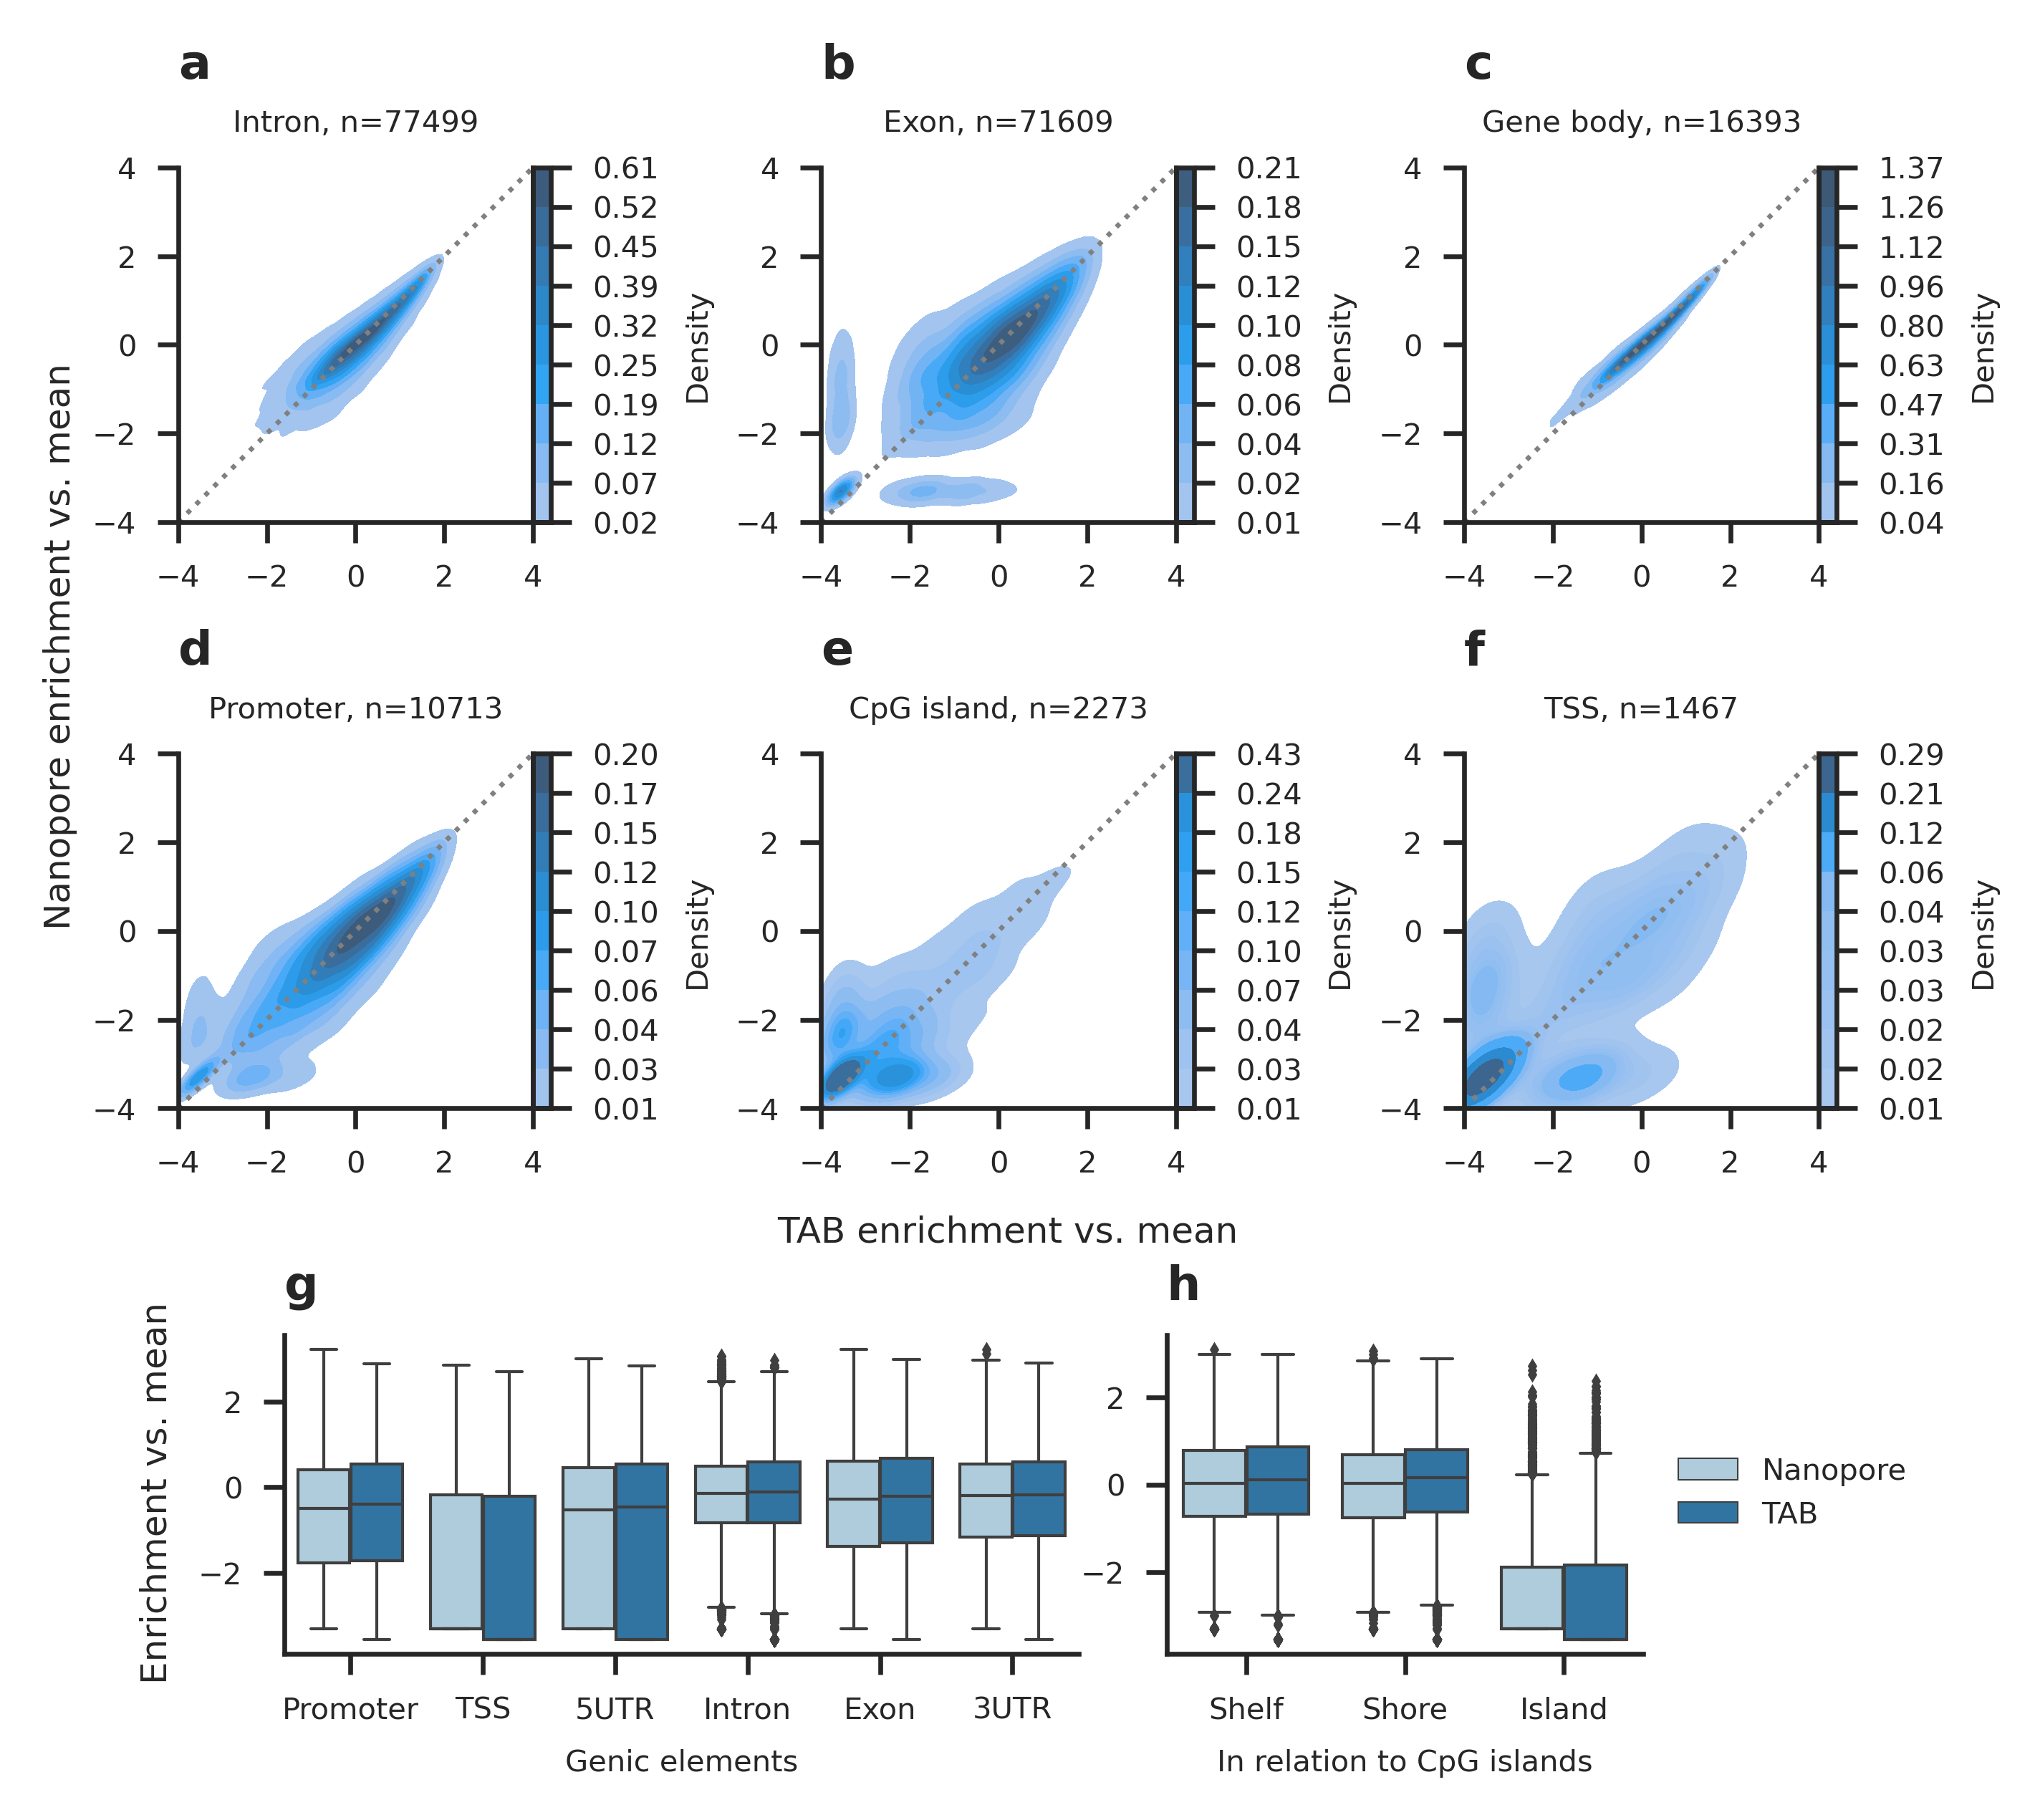

In [251]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(120/25.4, 110/25.4), dpi=600, layout="constrained")
gs = GridSpec(2, 1, fig, height_ratios=(3, 1))
mpl.rc('font', size=5)

sfig1 = fig.add_subfigure(gs[0, :])
gs1 = GridSpec(2, 3, sfig1)
ax1 = sfig1.add_subplot(gs1[0, 0])
ax2 = sfig1.add_subplot(gs1[0, 1])
ax3 = sfig1.add_subplot(gs1[0, 2])
ax4 = sfig1.add_subplot(gs1[1, 0])
ax5 = sfig1.add_subplot(gs1[1, 1])
ax6 = sfig1.add_subplot(gs1[1, 2])

sfig2 = fig.add_subfigure(gs[1, :])
gs2 = GridSpec(1, 3, width_ratios=(2.5, 1.5, 0.15))

ax7 = sfig2.add_subplot(gs2[0, 0])
ax8 = sfig2.add_subplot(gs2[0, 1])

hist_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax_titles = ["a", "b", "c", "d", "e", "f"]
feature_order = ["Intron", "Exon", "Gene body", "Promoter", "CpG island", "TSS"]

for i, feature_type in enumerate(feature_order):
    div = make_axes_locatable(hist_axes[i])
    cax = div.append_axes("right", size="5%", pad=0)

    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")

    sns.kdeplot(hist_df, x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
                fill=True, common_norm=False, 
                cbar=True, cbar_ax=cax, cbar_kws={"label" : "Density", 
                                                  "pad" : 0,
                                                  "format" : "%2.2f"},
                ax=hist_axes[i])

    hist_axes[i].set_aspect("equal")
    
    hist_axes[i].set_ylabel(None)
    hist_axes[i].set_xlabel(None)

    hist_axes[i].set_ylim((-4, 4))
    hist_axes[i].set_xlim((-4, 4))

    hist_axes[i].set_yticks(ticks=range(-4, 5, 2))
    hist_axes[i].set_xticks(ticks=range(-4, 5, 2))
    hist_axes[i].plot((-4, 4), (-4, 4), ls=":", lw=0.8, c="grey")

    hist_axes[i].set_title(f"{feature_order[i]}, n={len(hist_df)}", loc="center", fontsize=5)
    hist_axes[i].set_title(f"{ax_titles[i]}", loc="left", fontsize=8, fontweight="bold", y=1.15)

genic_barplot_df["feature_type"] = pd.Categorical(genic_barplot_df["feature_type"], 
                                                  ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])
cgi_barplot_df["feature_type"] = pd.Categorical(cgi_barplot_df["feature_type"],
                                                ["Shelf", "Shore", "Island"])
barplots = [genic_barplot_df, cgi_barplot_df]

for i, ax in enumerate([ax7, ax8]):
    df = barplots[i]
    sns.boxplot(df, x="feature_type", y="log2enrichment_5hmC", 
                hue="method", palette="Paired", dodge=True, linewidth=0.5,
                showfliers=True, fliersize=0.5,
                ax=ax)
    ax.set_title(f"{['g', 'h'][i]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_xlabel(f"{['Genic elements', 'In relation to CpG islands'][i]}")
    ax.set_ylabel(None)
    ax.get_legend().set_visible(False)

barplot_handles, barplot_labels = ax7.get_legend_handles_labels()

sfig2.legend(barplot_handles, barplot_labels, bbox_to_anchor=(.98, .65), frameon=False)

sfig1.supylabel("Nanopore enrichment vs. mean", x=0)
sfig2.supylabel("Enrichment vs. mean", x=.05)

sfig1.supxlabel("TAB enrichment vs. mean")

engine = fig.get_layout_engine()
engine.set(rect=(0, 0.075, .95, .9))

sns.despine()

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level_analysis_including_zeros_s.png", dpi=600)

## Stats

In [4]:
from sklearn.linear_model import LinearRegression
from scipy import stats
from common import compareStats

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"] 

features_series = []
for feature in feature_order:
    hist_df = all_hists.query(f"feature_type == '{feature}'")
    median_count = hist_df["CpG_count"].median()

    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    x = hist_df["percentMeth_5hmC_Nanopore"]
    y = hist_df["percentMeth_5hmC_TAB"]

    feat_stats = compareStats(x, y)
    feature_series = pd.concat([pd.Series({"Feature type" : feature, 
                                           "CpG median" : int(median_count),
                                           "Nanopore mean" : x.mean(),
                                           "TAB mean" : y.mean()}), 
                                feat_stats])
    features_series.append(feature_series)
    
pd.DataFrame(features_series)

/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/py

Feature type  CpG median  Nanopore mean   TAB mean  \
0       Intron          10      10.062599  12.528816   
1         Exon           3       9.471688  11.667308   
2    Gene body          47      10.136072  12.539405   
3     Promoter           5       7.751745  10.063959   
4          TSS           2       4.370583   5.344941   
5   CpG island           5       1.825304   2.415700   

                           Pearson                          Spearman  \
0                     [0.911, 0.0]                      [0.883, 0.0]   
1                      [0.77, 0.0]                       [0.72, 0.0]   
2                     [0.974, 0.0]                      [0.968, 0.0]   
3                     [0.859, 0.0]                      [0.847, 0.0]   
4  [0.703, 8.744256153884912e-219]  [0.614, 1.6468997640174863e-152]   
5                     [0.823, 0.0]    [0.399, 1.334465071875637e-87]   

        Kendall Shapiro-Wilk      RMSE  Mean Absolute Error  \
0  [0.709, 0.0]   [0.0, 0.0]  4.154338             3.149505   
1  [0.536, 0.0]   [0.0, 0.0]  6.631121             4.801531   
2  [0.852, 0.0]   [0.0, 0.0]  3.126985             2.517960   
3  [0.659, 0.0]   [0.0, 0.0]  5.272903             3.689684   
4    [0.5, 0.0]   [0.0, 0.0]  6.408240             3.681873   
5  [0.308, 0.0]   [0.0, 0.0]  2.837578             1.577502   

   Median Absolute Error                                             KS  \
0               2.443515                     [0.13887921134466258, 0.0]   
1               3.462650                     [0.10280830621849213, 0.0]   
2               2.145068  [0.1594583053742451, 1.6189022029397482e-182]   
3               2.464867   [0.10706618127508638, 6.411281890983445e-54]   
4               1.837179   [0.07157464212678936, 0.0010851329965572516]   
5               0.953530  [0.13814342278926528, 2.5493354306254642e-19]   

                                      MW  \
0                    [2445330129.5, 0.0]   
1                    [2231495096.0, 0.0]   
2  [106657983.0, 2.245066107071744e-229]   
3    [49445561.5, 7.165122280465391e-69]   
4      [1020269.5, 0.009758668752496532]   
5    [2255259.5, 2.0285671269457528e-14]   

                                            CVM  \
0   [398.2220247796213, 1.1178447056892082e-07]   
1     [187.10089853499085, 8.5214393430455e-08]   
2  [105.33181612776661, 5.3539239930344706e-08]   
3   [30.818642950741832, 9.247648535826158e-09]   
4    [0.7395262231255515, 0.010218417583873762]   
5   [7.163728588381105, 3.0483038315765043e-10]   

                                           AD  \
0                 [2724.9714207303473, 0.001]   
1                 [1270.2144178524766, 0.001]   
2                  [720.1550265664131, 0.001]   
3                 [223.10210925288354, 0.001]   
4  [4.7097076176929376, 0.004415808299495828]   
5                 [48.377734706123924, 0.001]   

                                          T-Test  
0                       [-68.3384456209861, 0.0]  
1                     [-46.161898378315335, 0.0]  
2   [-35.32479296395476, 2.666674262910669e-268]  
3  [-20.333763616909362, 4.6780966460564746e-91]  
4    [-3.247100991902502, 0.0011790060284110543]  
5    [-4.492312571334881, 7.220260622259128e-06]

In [40]:
2.42-1.83

0.5899999999999999

# Macro level 5mC comparison

In [8]:
import pandas as pd
from MultisiteTools import *
from common import *
import warnings

prom_oxbs_comp = CpGRange(pd.read_csv("data_tables/data_files/processed/prom_oxbs_10x_maxDepth.csv"))

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_oxbs_comp.group_by_annotation("features", "./feature_references/genic/").enrichment_over_mean().df
    all_cgi = prom_oxbs_comp.group_by_annotation("CGI", "./feature_references/cgi/").enrichment_over_mean().df
    all_genes = prom_oxbs_comp.group_by_annotation("genes", "./feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean().df

features_genes_cgi = pd.concat([all_features, all_cgi, all_genes])

Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']
Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']
Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']


In [9]:
features_genes_cgi = features_genes_cgi.query("log2enrichment_5mC_oxBS > -inf & log2enrichment_5mC_Nanopore > -inf")
all_hists = features_genes_cgi.replace(["3UTR", "5UTR", "Genes", "CGI"], ["Exon", "Exon", "Gene body", "CpG island"])
all_hists = all_hists.query("feature_type != 'Intergenic' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf'")

genic_df = features_genes_cgi.query("feature_type != 'Intergenic' & feature_type != 'Genes' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf' & feature_type != 'CGI'")
cgi_df = features_genes_cgi.query("feature_type == 'CGI' | feature_type == 'Shelf' | feature_type == 'Shore'").replace("CGI", "Island")

genic_barplot_df, cgi_barplot_df = map(annotationPivot, [genic_df, cgi_df])

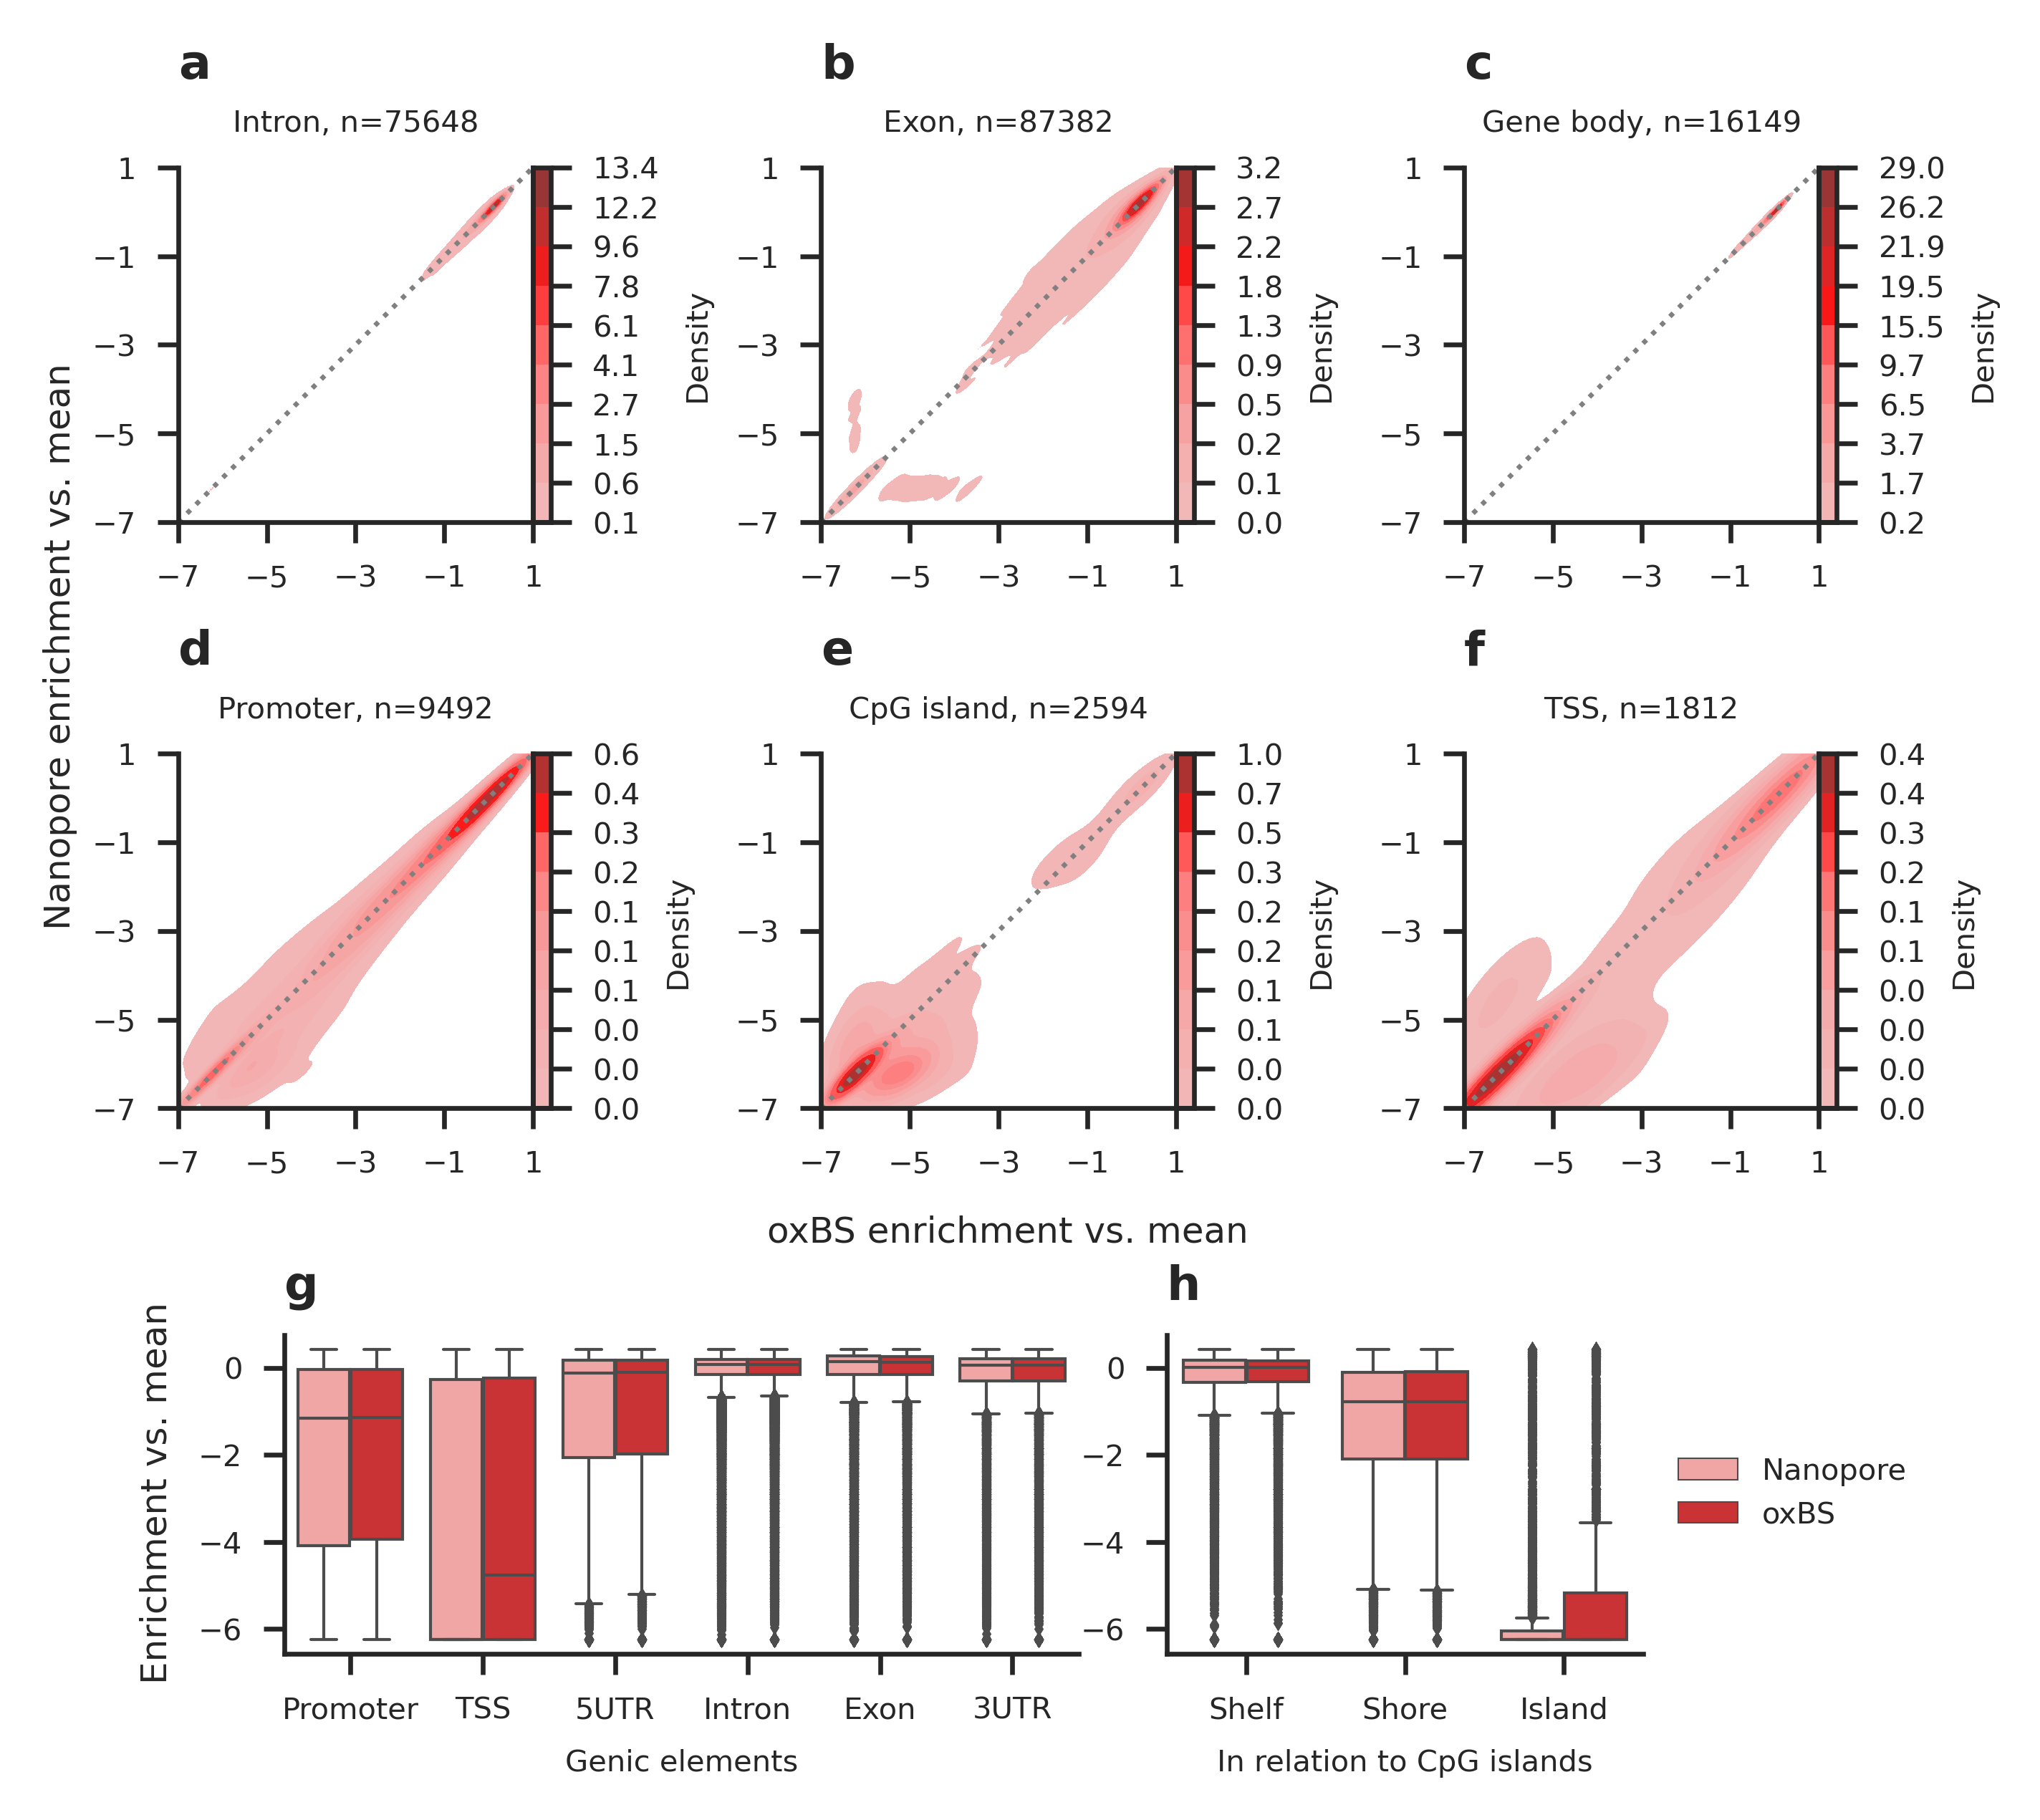

In [92]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(120/25.4, 110/25.4), dpi=600, layout="constrained")
gs = GridSpec(2, 1, fig, height_ratios=(3, 1))
mpl.rc('font', size=5)

sfig1 = fig.add_subfigure(gs[0, :])

gs1 = GridSpec(2, 3, sfig1)

ax1 = sfig1.add_subplot(gs1[0, 0])
ax2 = sfig1.add_subplot(gs1[0, 1])
ax3 = sfig1.add_subplot(gs1[0, 2])
ax4 = sfig1.add_subplot(gs1[1, 0])
ax5 = sfig1.add_subplot(gs1[1, 1])
ax6 = sfig1.add_subplot(gs1[1, 2])

sfig2 = fig.add_subfigure(gs[1, :])
gs2 = GridSpec(1, 3, width_ratios=(2.5, 1.5, 0.15))

ax7 = sfig2.add_subplot(gs2[0, 0])
ax8 = sfig2.add_subplot(gs2[0, 1])

hist_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax_titles = ["a", "b", "c", "d", "e", "f"]
feature_order = ["Intron", "Exon", "Gene body", "Promoter", "CpG island", "TSS"]

min_list = []
max_list = []

for i, feature_type in enumerate(feature_order):
    div = make_axes_locatable(hist_axes[i])
    cax = div.append_axes("right", size="5%", pad=0)

    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")

    sns.kdeplot(hist_df, x="log2enrichment_5mC_oxBS", y="log2enrichment_5mC_Nanopore", 
                fill=True, common_norm=False, color="red",
                cbar=True, cbar_ax=cax, cbar_kws={"label" : "Density", 
                                                  "pad" : 0,
                                                  "format" : "%2.1f"},
                ax=hist_axes[i])

    hist_axes[i].set_aspect("equal")
    
    hist_axes[i].set_ylabel(None)
    hist_axes[i].set_xlabel(None)

    min_list.extend([hist_df['log2enrichment_5mC_oxBS'].min(), hist_df['log2enrichment_5mC_Nanopore'].min()])
    max_list.extend([hist_df['log2enrichment_5mC_oxBS'].max(), hist_df['log2enrichment_5mC_Nanopore'].max()])

    hist_axes[i].set_title(f"{feature_order[i]}, n={len(hist_df)}", loc="center", fontsize=5)
    hist_axes[i].set_title(f"{ax_titles[i]}", loc="left", fontsize=8, fontweight="bold", y=1.15)

for ax in hist_axes:
    smallest = math.floor(min(min_list))
    biggest = math.ceil(max(max_list))
    
    ax.set_xlim(smallest, biggest)
    ax.set_ylim(smallest, biggest)
    ax.set_xticks(ticks=range(smallest, biggest + 1, 2))
    ax.set_yticks(ticks=range(smallest, biggest + 1, 2))

    ax.plot((smallest, biggest, 2), (smallest, biggest, 2), ls=":", lw=0.8, c="grey")

genic_barplot_df["feature_type"] = pd.Categorical(genic_barplot_df["feature_type"], 
                                                  ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])
cgi_barplot_df["feature_type"] = pd.Categorical(cgi_barplot_df["feature_type"],
                                                ["Shelf", "Shore", "Island"])
barplots = [genic_barplot_df, cgi_barplot_df]

for i, ax in enumerate([ax7, ax8]):
    df = barplots[i]
    sns.boxplot(df, x="feature_type", y="log2enrichment_5mC", 
                hue="method", palette=sns.color_palette("Paired")[4:6], dodge=True, linewidth=0.5,
                showfliers=True, fliersize=0.5,
                ax=ax)
    ax.set_title(f"{['g', 'h'][i]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_xlabel(f"{['Genic elements', 'In relation to CpG islands'][i]}")
    ax.set_ylabel(None)
    ax.get_legend().set_visible(False)
    
barplot_handles, barplot_labels = ax7.get_legend_handles_labels()
sfig2.legend(barplot_handles, barplot_labels, bbox_to_anchor=(.98, .65), frameon=False)

sfig1.supylabel("Nanopore enrichment vs. mean", x=0)
sfig2.supylabel("Enrichment vs. mean", x=.05)

sfig1.supxlabel("oxBS enrichment vs. mean")

engine = fig.get_layout_engine()
engine.set(rect=(0, 0.075, .95, .9))

sns.despine()

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level_analysis_including_zeros_mc_s.png", dpi=600)

In [4]:
high_5mc_cgis = all_hists.query("feature_type == 'CpG island' & CpG_count >= 10 & log2enrichment_5mC_Nanopore > 0 & log2enrichment_5mC_oxBS > 0")
high_5mc_cgis["IGV"] = high_5mc_cgis.Chromosome + ":" + high_5mc_cgis.Start.map(str) + "-" + high_5mc_cgis.End.map(str)

/tmp/ipykernel_3675219/3493141135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_5mc_cgis["IGV"] = high_5mc_cgis.Chromosome + ":" + high_5mc_cgis.Start.map(str) + "-" + high_5mc_cgis.End.map(str)


## Stats

In [32]:
from sklearn.linear_model import LinearRegression
from scipy import stats
from common import compareStats

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"] 

features_series = []
for feature in feature_order:
    hist_df = all_hists.query(f"feature_type == '{feature}'")
    median_count = hist_df["CpG_count"].median()

    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    x = hist_df["percentMeth_5mC_oxBS"]
    y = hist_df["percentMeth_5mC_Nanopore"]

    feat_stats = compareStats(x, y)
    feature_series = pd.concat([pd.Series({"Feature type" : feature, 
                                           "CpG median" : int(median_count)}), 
                                feat_stats])
    features_series.append(feature_series)

pd.DataFrame(features_series)["Kendall"]

/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/py

0    [0.783, 0.0]
1    [0.649, 0.0]
2    [0.868, 0.0]
3    [0.875, 0.0]
4    [0.779, 0.0]
5    [0.363, 0.0]
Name: Kendall, dtype: object

# Interassay replicability using MinION WGS data

In [1]:
import pandas as pd
from common import *

try:
    min_1 = pd.read_csv("data_tables/data_files/processed/cbm1_wgs_07_08_23_mq60.tsv")
    min_2 = pd.read_csv("data_tables/data_files/processed/cbm1_wgs_26_06_23_mapq60.tsv")
    prom = pd.read_csv("data_tables/data_files/processed/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.tsv")

except:
    print("Files not found.")
    min_1 = readModkit("data_tables/data_files/nanopore_min/cbm1_wgs_26_06_23_mapq60.bed", 1, False, False)
    min_2 = readModkit("data_tables/data_files/nanopore_min/cbm1_wgs_07_08_23_mq60.bed", 1, False, False)
    prom = readModkit("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False, False)

In [69]:
min_1.to_csv("data_tables/data_files/processed/cbm1_wgs_07_08_23_mq60.tsv", index=False)
min_2.to_csv("data_tables/data_files/processed/cbm1_wgs_26_06_23_mapq60.tsv", index=False)
prom.to_csv("data_tables/data_files/processed/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.tsv", index=False)

Loading public datasets

In [2]:
tab_df = readBismarkZeroCov("data_tables/data_files/public/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False, False)
oxbs_df = readBismarkZeroCov("data_tables/data_files/public/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False, False)

In [3]:
tab_min_1 = pd.merge(tab_df, min_1, "inner", ["Chromosome", "Start", "End"], suffixes=["_TAB", "_Rep1"])
tab_min_2 = pd.merge(tab_df, min_2, "inner", ["Chromosome", "Start", "End"], suffixes=["_TAB", "_Rep2"])

In [4]:
ox_min_1 = pd.merge(oxbs_df, min_1, "inner", ["Chromosome", "Start", "End"], suffixes=["_oxBS", "_Rep1"])
ox_min_2 = pd.merge(oxbs_df, min_2, "inner", ["Chromosome", "Start", "End"], suffixes=["_oxBS", "_Rep2"])

In [138]:
tab_min_1_filtered = tab_min_1.query("readCount_TAB > 9 & readCount_Rep1 > 9")
tab_min_2_filtered = tab_min_2.query("readCount_TAB > 9 & readCount_Rep2 > 9")

ox_min_1_filtered = ox_min_1.query("readCount_oxBS > 9 & readCount_Rep1 > 9")
ox_min_2_filtered = ox_min_2.query("readCount_oxBS > 9 & readCount_Rep2 > 9")

## At CpG level

RMSE Min-Min

In [43]:
min_min = pd.merge(min_1, min_2, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_1", "_2"])

In [2]:
def depthRMSEpermutor(df, rc1, rc2): 

    all_depth_dfs = []
    for lim in np.arange(1, 31, 1):
        df_filt = df.query(f"{rc1} > {lim} & {rc2} > {lim}")

        rmse_mc = metrics.mean_squared_error(df_filt["percentMeth_5mC_1"], df_filt["percentMeth_5mC_2"], squared=False)
        rmse_hmc = metrics.mean_squared_error(df_filt["percentMeth_5hmC_1"], df_filt["percentMeth_5hmC_2"], squared=False)

        stat_s_1 = pd.Series({"Threshold" : lim, 
                              "RMSE_5mC" : rmse_mc,
                              "RMSE_5hmC" : rmse_hmc})
        
        all_depth_dfs.append(stat_s_1)

    return pd.DataFrame(all_depth_dfs)


In [60]:
min_rep_comp = depthRMSEpermutor(min_min, "readCount_1", "readCount_2")

In [87]:
min_rep_comp.corr()

Threshold  RMSE_5mC  RMSE_5hmC
Threshold   1.000000 -0.914136  -0.868930
RMSE_5mC   -0.914136  1.000000   0.992711
RMSE_5hmC  -0.868930  0.992711   1.000000

In [64]:
min_1 = min_1.assign(Replicate = "Min. WGS 1")
min_2 = min_2.assign(Replicate = "Min. WGS 2")

mins = pd.concat([min_1, min_2])

RMSE Min-Prom

In [3]:
prom_min_1 = pd.merge(prom, min_1, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_Prom", "_Rep1"])
prom_min_2 = pd.merge(prom, min_2, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_Prom", "_Rep2"])

In [92]:
from sklearn import metrics

prom_min_1 = prom_min_1.query("readCount_Prom >= 10 & readCount_Rep1 >= 10")
prom_min_2 = prom_min_2.query("readCount_Prom >= 10 & readCount_Rep2 >= 10")

rmses = [metrics.mean_squared_error(prom_min_1["percentMeth_5hmC_Prom"], prom_min_1["percentMeth_5hmC_Rep1"], squared=False), 
        metrics.mean_squared_error(prom_min_2["percentMeth_5hmC_Prom"], prom_min_2["percentMeth_5hmC_Rep2"], squared=False)]

In [93]:
np.mean(rmses)

9.932003009734558

In [4]:
from sklearn import metrics

all_depth_dfs = []
for lim in np.arange(1, 31, 1):
    df_1 = prom_min_1.query(f"readCount_Prom >= {lim} & readCount_Rep1 >= {lim}")
    df_2 = prom_min_2.query(f"readCount_Prom >= {lim} & readCount_Rep2 >= {lim}")

    stat_s_1 = pd.Series({"Threshold" : lim, 
                             "Replicate" : "Rep1", 
                             "RMSE_5mC" : metrics.mean_squared_error(df_1["percentMeth_5mC_Prom"], df_1["percentMeth_5mC_Rep1"], squared=False),
                             "RMSE_5hmC" : metrics.mean_squared_error(df_1["percentMeth_5hmC_Prom"], df_1["percentMeth_5hmC_Rep1"], squared=False)})
    
    stat_s_2 = pd.Series({"Threshold" : lim, 
                              "Replicate" : "Rep2", 
                              "RMSE_5mC" : metrics.mean_squared_error(df_2["percentMeth_5mC_Prom"], df_2["percentMeth_5mC_Rep2"], squared=False),
                              "RMSE_5hmC" : metrics.mean_squared_error(df_2["percentMeth_5hmC_Prom"], df_2["percentMeth_5hmC_Rep2"], squared=False)})
    
    stat_df = pd.DataFrame([stat_s_1, stat_s_2])
    all_depth_dfs.append(stat_df)


In [5]:
all_cpg_depth_df = pd.concat(all_depth_dfs)
all_cpg_depth_df = all_cpg_depth_df.melt(["Threshold", "Replicate"], ["RMSE_5mC", "RMSE_5hmC"], "Mod", "RMSE").replace(["RMSE_5mC", "RMSE_5hmC"], ["5mC", "5hmC"])

In [15]:
all_cpg_depth_df.query("Threshold == 16").groupby("Mod").mean()

/tmp/ipykernel_2397909/2168848508.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_cpg_depth_df.query("Threshold == 16").groupby("Mod").mean()


Threshold      RMSE
Mod                      
5hmC       16.0  4.697300
5mC        16.0  8.910603

In [71]:
all_cpg_depth_df.query("Mod == '5mC'").corr(), all_cpg_depth_df.query("Mod == '5hmC'").corr()

/tmp/ipykernel_3997242/2063960617.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_cpg_depth_df.query("Mod == '5mC'").corr(), all_cpg_depth_df.query("Mod == '5hmC'").corr()


(           Threshold      RMSE
 Threshold   1.000000 -0.940109
 RMSE       -0.940109  1.000000,
            Threshold      RMSE
 Threshold   1.000000 -0.923292
 RMSE       -0.923292  1.000000)

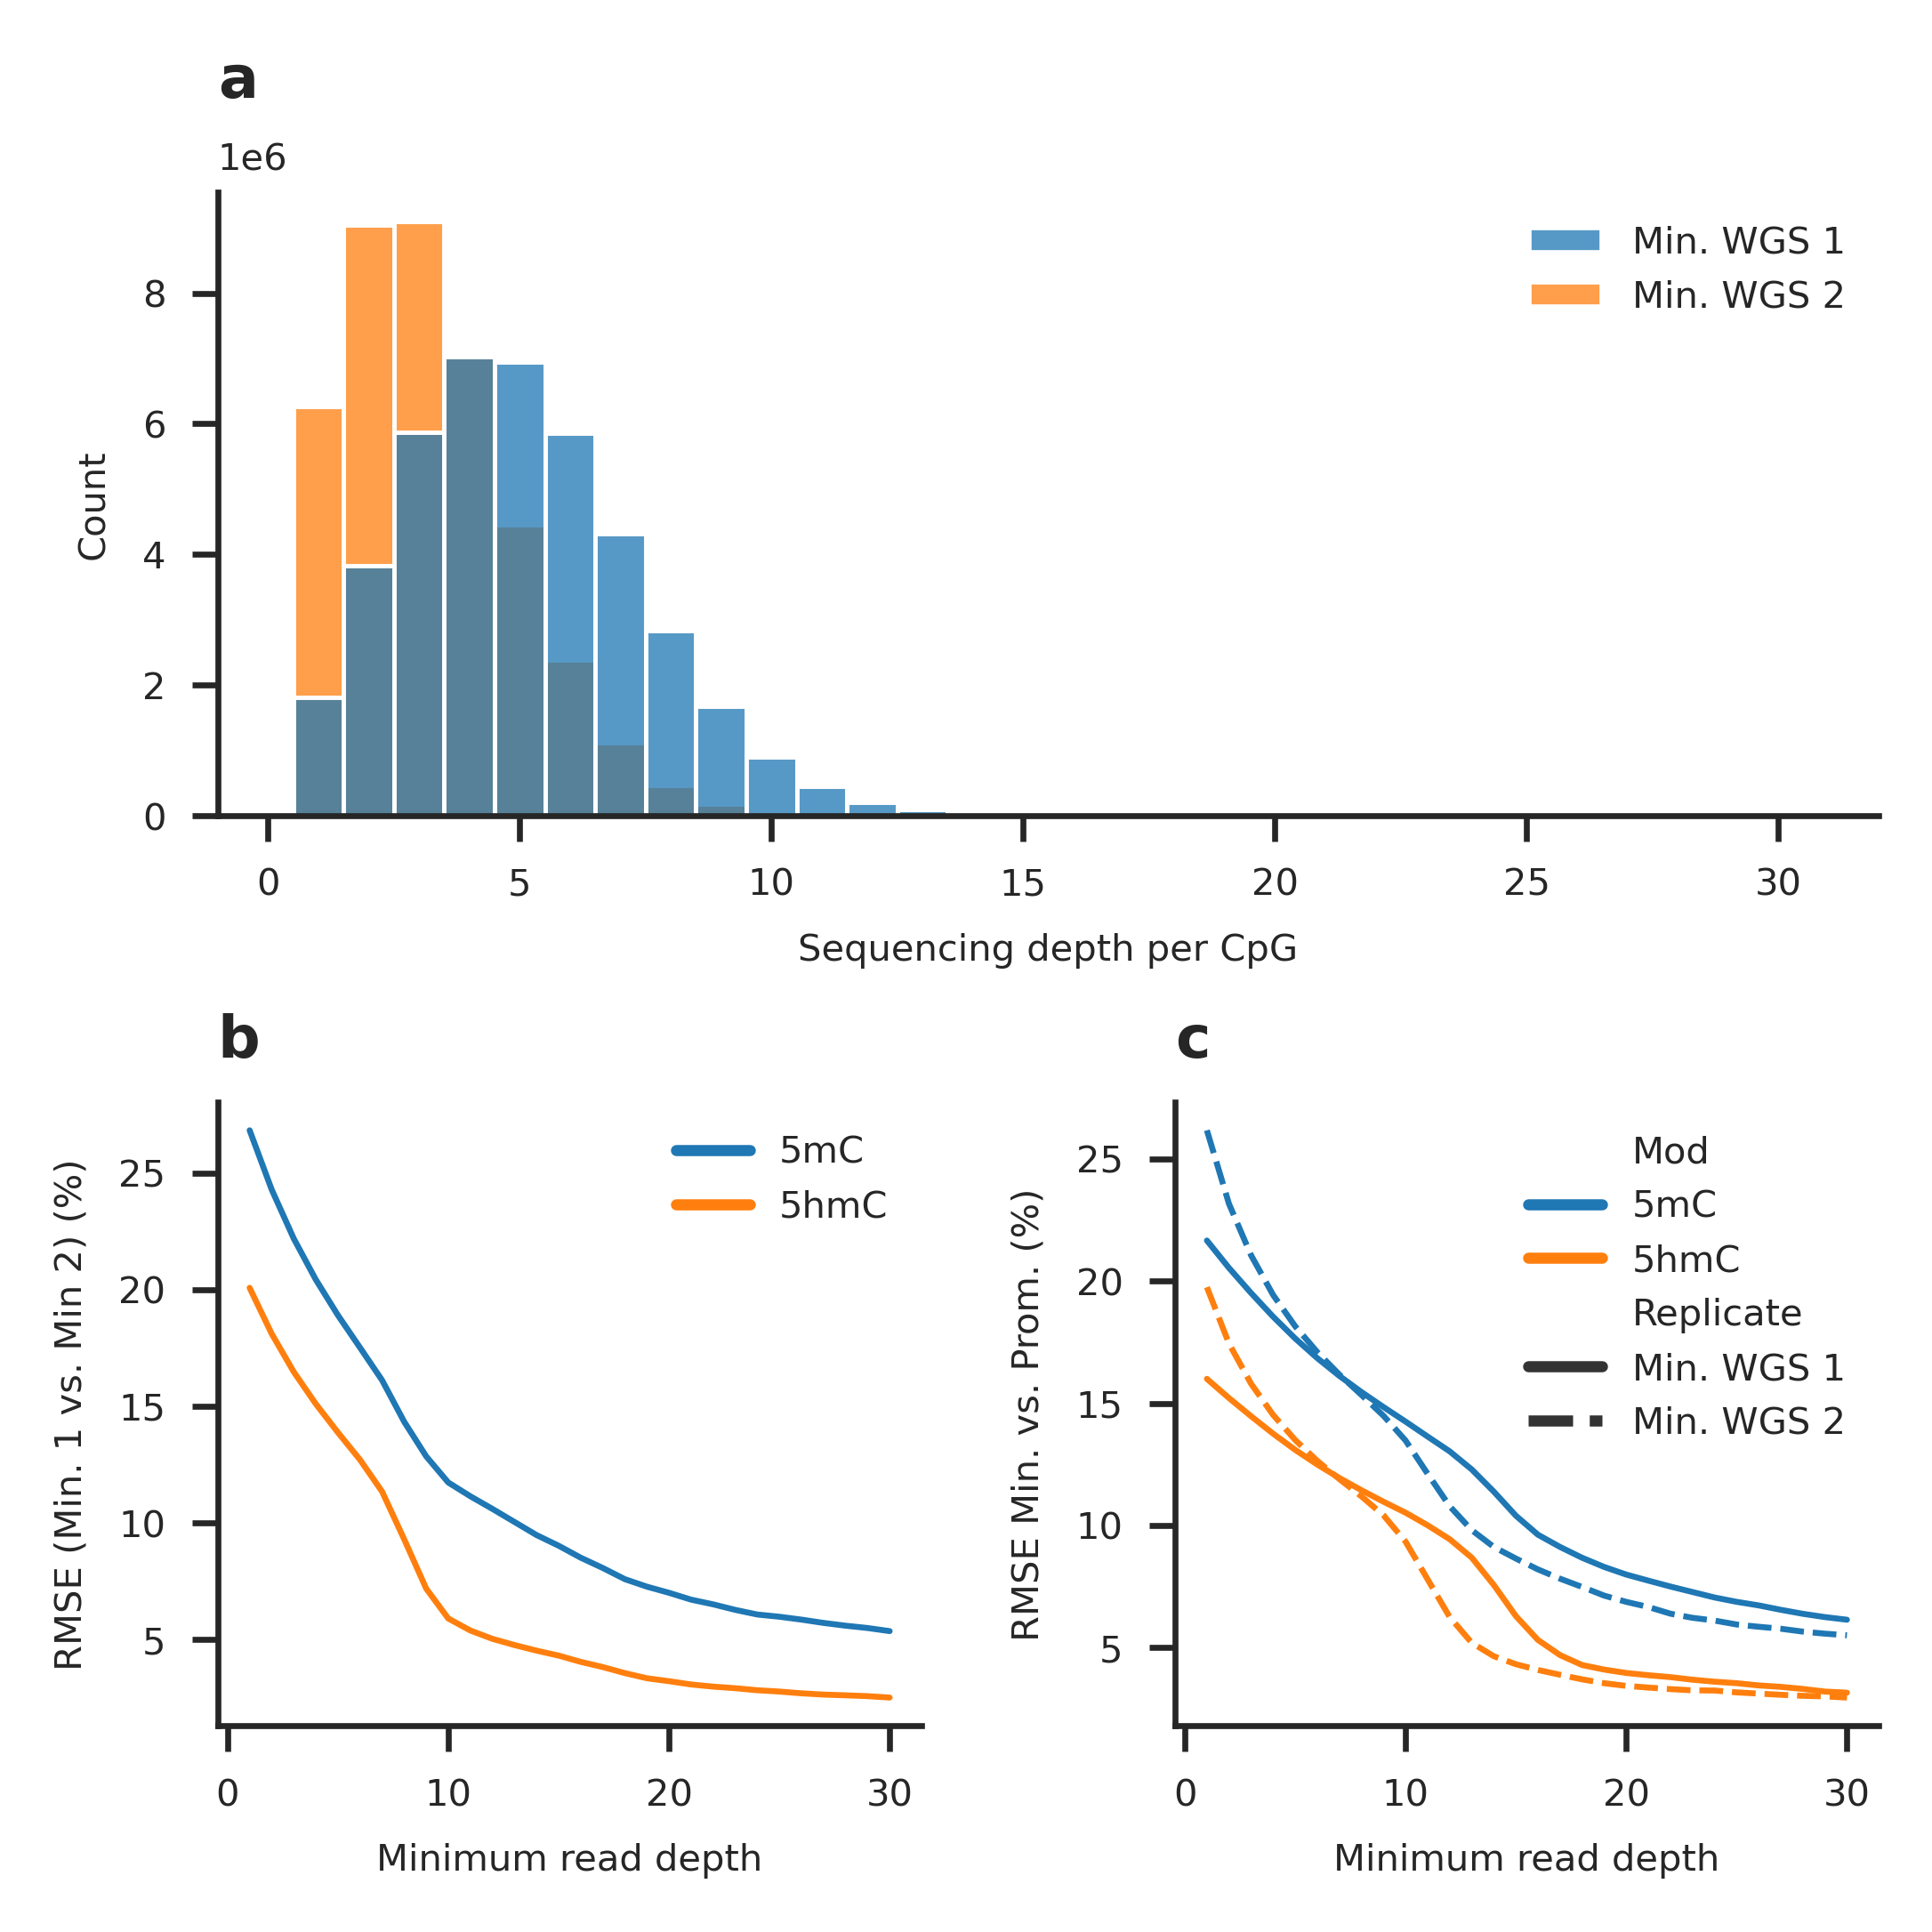

In [78]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
import string

fig =  plt.figure(figsize=(89/25.4, 89/25.4), dpi=600, layout="constrained")

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

mpl.rc('font', size=5)
sns.set_style("ticks")

# Panel 1 #

sns.histplot(mins, x="readCount",
             stat="count", discrete=True, binwidth=1, binrange=(1, 30), 
             hue="Replicate", lw=0.8, alpha=0.75,
             ax=ax1)

ax1.set_xlabel("Sequencing depth per CpG")
sns.move_legend(ax1, "upper right", title=None, frameon=False)

# Panel 2 # 

sns.lineplot(min_rep_comp.melt("Threshold", ["RMSE_5mC", "RMSE_5hmC"], "Modification", "RMSE").replace(["RMSE_5mC", "RMSE_5hmC"], ["5mC", "5hmC"]), 
             x="Threshold", y="RMSE", 
             hue="Modification", lw=0.8,
             ax=ax2)

ax2.set_ylabel("RMSE (Min. 1 vs. Min 2) (%)")
ax2.set_xlabel("Minimum read depth")
ax2.legend(title=None, frameon=False)

# Panel 3 # 

sns.lineplot(all_cpg_depth_df.replace(["Rep1", "Rep2"], ["Min. WGS 1", "Min. WGS 2"]), x="Threshold", y="RMSE", 
             hue="Mod", lw=0.8, style="Replicate", 
             ax=ax3)

ax3.set_ylabel("RMSE Min. vs. Prom. (%)")
ax3.set_xlabel("Minimum read depth")
ax3.legend(frameon=False)

for ax, letter in zip([ax1, ax2, ax3], string.ascii_lowercase[:3]):
    ax.set_title(f"{letter}", loc="left", fontsize=8, fontweight="bold")
    
sns.despine()
# fig.subplots_adjust(wspace=0.4, bottom=.1)
# fig.legend()
fig.show()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/interassay.png", dpi=600)

## At feature level

In [2]:
import pandas as pd
from common import *
import pyranges as pr

# try:
    # min_1 = pd.read_csv("data_tables/data_files/processed/cbm1_wgs_07_08_23_mq60.tsv")
    # min_2 = pd.read_csv("data_tables/data_files/processed/cbm1_wgs_26_06_23_mapq60.tsv")
    # prom = pd.read_csv("data_tables/data_files/processed/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.tsv") 
# except:
print("Files not found.")
min_1 = readModkit("data_tables/data_files/nanopore_min/cbm1_wgs_26_06_23_mapq60.bed", 1, False, True)
min_2 = readModkit("data_tables/data_files/nanopore_min/cbm1_wgs_07_08_23_mq60.bed", 1, False, True)
prom = readModkit("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False, True)

Files not found.


In [3]:
import numpy as np

mins = min_1.merge(min_2, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_1", "_2"])

mins = mins.assign(percentMeth_5hmC = lambda r: np.divide(np.add(r["N_hmC_1"], r["N_hmC_2"]), 
                                                                np.add(r["readCount_1"], r["readCount_2"])),
                   percentMeth_5mC = lambda r: np.divide(np.add(r["N_mC_1"], r["N_mC_2"]),
                                                               np.add(r["readCount_1"], r["readCount_2"])),
                   readCount = lambda r: np.add(r["readCount_1"], r["readCount_2"])
                                                               )
mins = mins.loc[:, ("Chromosome", "Start", "End", "Strand", "readCount", "percentMeth_5mC", "percentMeth_5hmC")]

In [4]:
mins.to_csv("data_tables/data_files/processed/minion_inner_join.tsv", index=False)

In [5]:
mins_prom = mins.merge(prom, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_Min", "_Prom"])

Feature specific

In [6]:
from FeatureReferences import featureRefPyRange
import pyranges as pr

cgi_ref = featureRefPyRange("feature_references/cgi/")


In [7]:
import numpy as np 

def groupFeature(df, feature_ref_pr, readcount_min=5):
    # rc_max = df["readCount"].mean() + 3*(math.sqrt(df["readCount"].mean()))
    df = df.query(f"readCount >= {readcount_min} & readCount <= 30")

    pyrange = pr.PyRanges(df)

    feature_df = feature_ref_pr.join(pyrange, False, apply_strand_suffix=False, suffix="_CpG").as_df()

    group_on_feature = feature_df.groupby(["Chromosome", "Start", "End", "feature_type"], observed=True).agg(
        readCount = ("readCount", np.median),
        percentMeth_5mC = ("percentMeth_5mC", np.mean),
        percentMeth_5hmC = ("percentMeth_5hmC", np.mean),
        CpG_count = ("Start_CpG", "count")
    ).reset_index()

    return group_on_feature

def calculateEnrichment(df, mc_mean, hmc_mean):
    df = df.assign(log2Enrichment_5mC = lambda r: np.divide(r["percentMeth_5mC"] + 1, mc_mean + 1))
    df = df.assign(log2Enrichment_5hmC = lambda r: np.divide(r["percentMeth_5hmC"] + 1, hmc_mean + 1))

    return df 

In [78]:
from scipy import stats
from sklearn import metrics

def featurePermutator(df, df2, feature_ref, feature_type, min_rc=10, max_iter=15, min_CpG_count=10):
    all_depth_dfs = []
    for lim in np.arange(min_rc, max_iter+1, 1):

        # dataframes are annotated by feature and a specific feature type is selected
        grouped_feature_1 = groupFeature(df, feature_ref, lim).query(f"feature_type == '{feature_type}'")
        grouped_feature_2 = groupFeature(df2, feature_ref, lim).query(f"feature_type == '{feature_type}'")

            # median_count_1 = grouped_feature_1['CpG_count'].median()
            # median_count_2 = grouped_feature_2['CpG_count'].median()

        grouped_feature_1 = grouped_feature_1.query(f"CpG_count >= {min_CpG_count}")
        grouped_feature_2 = grouped_feature_2.query(f"CpG_count >= {min_CpG_count}")

        if len(grouped_feature_1) == 0 or len(grouped_feature_2) == 0:
            print(f"Not enough CpG sites in genes at {lim}")
            break
        else:
            print(f"Doing stats for {lim}.")

        matched_df = pr.PyRanges(grouped_feature_1).join(
            pr.PyRanges(grouped_feature_2), suffix="_2").as_df()
        
        mc_cor = stats.pearsonr(matched_df["percentMeth_5mC"], matched_df["percentMeth_5mC_2"]).statistic
        hmc_cor = stats.pearsonr(matched_df["percentMeth_5hmC"], matched_df["percentMeth_5hmC_2"]).statistic

        stat_df = pd.DataFrame({
            "CpG_count_1" : [grouped_feature_1["CpG_count"].median()],
            "CpG_count_2" : [grouped_feature_2["CpG_count"].median()],
            "max_readCount" : [lim],
            "n_compared" : [len(matched_df)],
            "5mC_Pearson" : [mc_cor],
            "5hmC_Pearson" : [hmc_cor],
            "5mC_RMSE" : [metrics.mean_squared_error(matched_df["percentMeth_5mC"], matched_df["percentMeth_5mC_2"], squared=False)],
            "5hmC_RMSE" : [metrics.mean_squared_error(matched_df["percentMeth_5hmC"], matched_df["percentMeth_5hmC_2"], squared=False)]
            })
        
        all_depth_dfs.append(stat_df)

    return pd.concat(all_depth_dfs)

In [9]:
cgi_df = featurePermutator(min_1, min_2, cgi_ref, "CGI", 1, 15)

In [10]:
cgi_prom_df = featurePermutator(mins, prom, cgi_ref, "CGI", 1, 15)

In [31]:
cgi_df.to_csv("data_tables/data_files/processed/stats/cgi_replicability_min_min.csv", index=False)
cgi_prom_df.to_csv("data_tables/data_files/processed/stats/cgi_replicability_min_prom.csv", index=False)

In [12]:
def makeStatDFs(df):
    corr_df = df.melt(["max_readCount", "n_compared"], value_vars=["5mC_Pearson", "5hmC_Pearson"], 
                      var_name="Modification", value_name="Pearson")
    rmse_df = df.melt(["max_readCount", "n_compared"], value_vars=["5mC_RMSE", "5hmC_RMSE"], 
                               var_name="Modification", value_name="RMSE")
    
    corr_df, rmse_df = map(lambda df: df.replace(["5mC_RMSE", "5hmC_RMSE", "5mC_corr", "5hmC_corr"],
                                              ["5mC", "5hmC", "5mC", "5hmC"]), [corr_df, rmse_df])

    return corr_df, rmse_df

Whole gene

In [14]:
from FeatureReferences import Reference

gene_reference = pr.PyRanges(Reference("feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").df)

Approx. 15 min

In [79]:
gene_df = featurePermutator(min_1, min_2, gene_reference, "Genes", 1, 1, 15)
gene_df_prom = featurePermutator(mins, prom, gene_reference, "Genes", 1, 1, 15)

Doing stats for 1.
Doing stats for 1.


In [62]:
gene_df.to_csv("data_tables/data_files/processed/stats/gene_replicability_min_min.csv", index=False)
gene_df_prom.to_csv("data_tables/data_files/processed/stats/gene_replicability_min_prom.csv", index=False)

In [66]:
gene_corr_df, gene_rmse_df = makeStatDFs(gene_df)
gene_corr_df_prom, gene_rmse_df_prom = makeStatDFs(gene_df_prom)

In [76]:
gene_df

median_CpG_count  max_readCount  n_compared  5mC_Pearson  \
0  [CpG_count, CpG_count_2]              1       43496     0.833910   
0  [CpG_count, CpG_count_2]              2       42796     0.827280   
0  [CpG_count, CpG_count_2]              3       41033     0.804474   
0  [CpG_count, CpG_count_2]              4       37549     0.755615   
0  [CpG_count, CpG_count_2]              5       31959     0.677364   
0  [CpG_count, CpG_count_2]              6       24773     0.588236   
0  [CpG_count, CpG_count_2]              7       16628     0.510307   
0  [CpG_count, CpG_count_2]              8        9183     0.437802   
0  [CpG_count, CpG_count_2]              9        3736     0.396339   
0  [CpG_count, CpG_count_2]             10        1124     0.402728   
0  [CpG_count, CpG_count_2]             11         246     0.308089   
0  [CpG_count, CpG_count_2]             12          78     0.440614   
0  [CpG_count, CpG_count_2]             13          56     0.795050   
0  [CpG_count, CpG_count_2]             14          51     0.783331   
0  [CpG_count, CpG_count_2]             15          49     0.775551   

   5hmC_Pearson   5mC_RMSE  5hmC_RMSE  
0      0.775307  13.152415   3.638325  
0      0.779302  13.441117   3.563715  
0      0.763342  14.348822   3.670141  
0      0.737604  16.029276   3.879560  
0      0.695114  18.321338   4.241150  
0      0.656925  20.393405   4.641299  
0      0.625149  21.847736   5.030053  
0      0.612903  22.914343   5.295835  
0      0.595223  23.032730   5.448373  
0      0.542114  23.435736   5.860433  
0      0.496086  24.469439   5.107369  
0      0.769273  14.201958   2.626034  
0      0.884059   7.564165   1.239101  
0      0.894815   7.989974   1.125547  
0      0.847568   8.273006   1.397903

# Imprinting control region analysis


Note readID: `45d44977-2e22-404a-8683-d07facf254eb` appears to pass through two DMR (Nespas-Gnasxl and Gnas) loci - it is methylated in the Gnas DMR and hypomethylated in the Nespas-Gnasxl DMR. Gnas is paternally expressed (maternally imprinted), and GeneImprint notes that Nespas-Gnasxl is expressed depending on isoform variant. 

Visualise how each set of phased reads looks using a clustermap. Cluster 1 in `phased_reads` is the methylated allele. Cluster 2 is the unmethylated allele. 

## All cluster map SFig. 

In [16]:
from ModkitTools import ModkitExtract

read_table = ModkitExtract("data_tables/data_files/nanopore_prom/dmr_files/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_DMRsOnly_modsCalled.tsv").process_read_table()
read_table.set_include_bed("feature_references/dmr/mm39_dmr_coordinates.bed")

Without reps

In [49]:
from ModkitTools import ModkitExtract
import pandas as pd

read_table_prom = ModkitExtract("data_tables/data_files/nanopore_prom/dmr_files/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_DMRsOnly_modsCalled.tsv").process_read_table()
read_table.set_include_bed("feature_references/dmr/mm39_dmr_coordinatesEdited.bed")

dmr_table_list = []
for dmr in list(read_table.include_bed["Name"]):
    annotated_table = read_table.select_gene(f"{dmr}").cluster_extract(0.1, .15)
    annotated_table = annotated_table.assign(gene = dmr)
    dmr_table_list.append(annotated_table)

bar_df = pd.concat(dmr_table_list).replace(["c", "m", "h"], ["C", "5mC", "5hmC"])
all_sites = bar_df.groupby(["Chromosome", "Start", "End", "cluster"])["classification"].value_counts().reset_index(name="count")
all_sites = all_sites.pivot(index=["Chromosome", "Start", "End", "cluster"], columns="classification", values="count").fillna(0).reset_index()

reads_per_gene = bar_df.groupby(["gene", "read_id"])["cluster"].value_counts().reset_index(name="count")
reads_per_cluster_df = reads_per_gene.groupby("gene")["cluster"].value_counts().reset_index(name="number_reads")
meth_df, unmeth_df = reads_per_cluster_df.query("cluster == 'Methylated'"), reads_per_cluster_df.query("cluster == 'Unmethylated'")

With reps

In [17]:
def geneIterator(read_table, replicate):
    read_table.set_include_bed("feature_references/dmr/mm39_dmr_coordinatesEdited.bed")

    dmr_table_list = []
    for dmr in list(read_table.include_bed["Name"]):
        try:
            annotated_table = read_table.select_gene(f"{dmr}").cluster_extract(0.1, .15)
            annotated_table = annotated_table.assign(gene = dmr)
            annotated_table = annotated_table.assign(rep = replicate)

            dmr_table_list.append(annotated_table)
        except:
            print(f"Failed on {dmr}")
            pass

    return pd.concat(dmr_table_list).replace(["c", "m", "h"], ["C", "5mC", "5hmC"])

In [18]:
from ModkitTools import ModkitExtract
import pandas as pd

read_table_prom = ModkitExtract("data_tables/data_files/nanopore_prom/dmr_files/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_DMRsOnly_modsCalled.tsv").process_read_table()
read_table_min1 = ModkitExtract("data_tables/data_files/nanopore_min/cbm1_wgs_26_06_23_mapq60_imprinted.tsv").process_read_table()
read_table_min2 = ModkitExtract("data_tables/data_files/nanopore_min/cbm1_wgs_07_08_23_mapq60_imprinted.tsv").process_read_table()

all_reps = pd.concat([geneIterator(read_table_prom, "Prom"), geneIterator(read_table_min1, "Min. 1"), geneIterator(read_table_min2, "Min. 2")])
reads_per_gene = all_reps.groupby(["gene", "read_id", "rep"])["cluster"].value_counts().reset_index(name="count")
reads_per_cluster_df = reads_per_gene.groupby(["gene", "rep"])["cluster"].value_counts().reset_index(name="number_reads")

meth_df, unmeth_df = reads_per_cluster_df.query("cluster == 'Methylated'"), reads_per_cluster_df.query("cluster == 'Unmethylated'")

Failed on Kcnq1ot1


In [19]:
prop = reads_per_cluster_df.pivot(index=["gene", "rep"], columns="cluster", values="number_reads").reset_index().assign(
    proportion_methylated = lambda r: r["Methylated"]/(r["Methylated"]+r["Unmethylated"]),
    proportion_unmethylated = lambda r: r["Unmethylated"]/(r["Methylated"]+r["Unmethylated"])
)
prob_bar_df = prop.melt(["gene", "rep"], ["proportion_methylated", "proportion_unmethylated"], "Allele", "Proportion").replace(["proportion_methylated", "proportion_unmethylated"],
                                                                                                                 ["Methylated", "Unmethylated"])

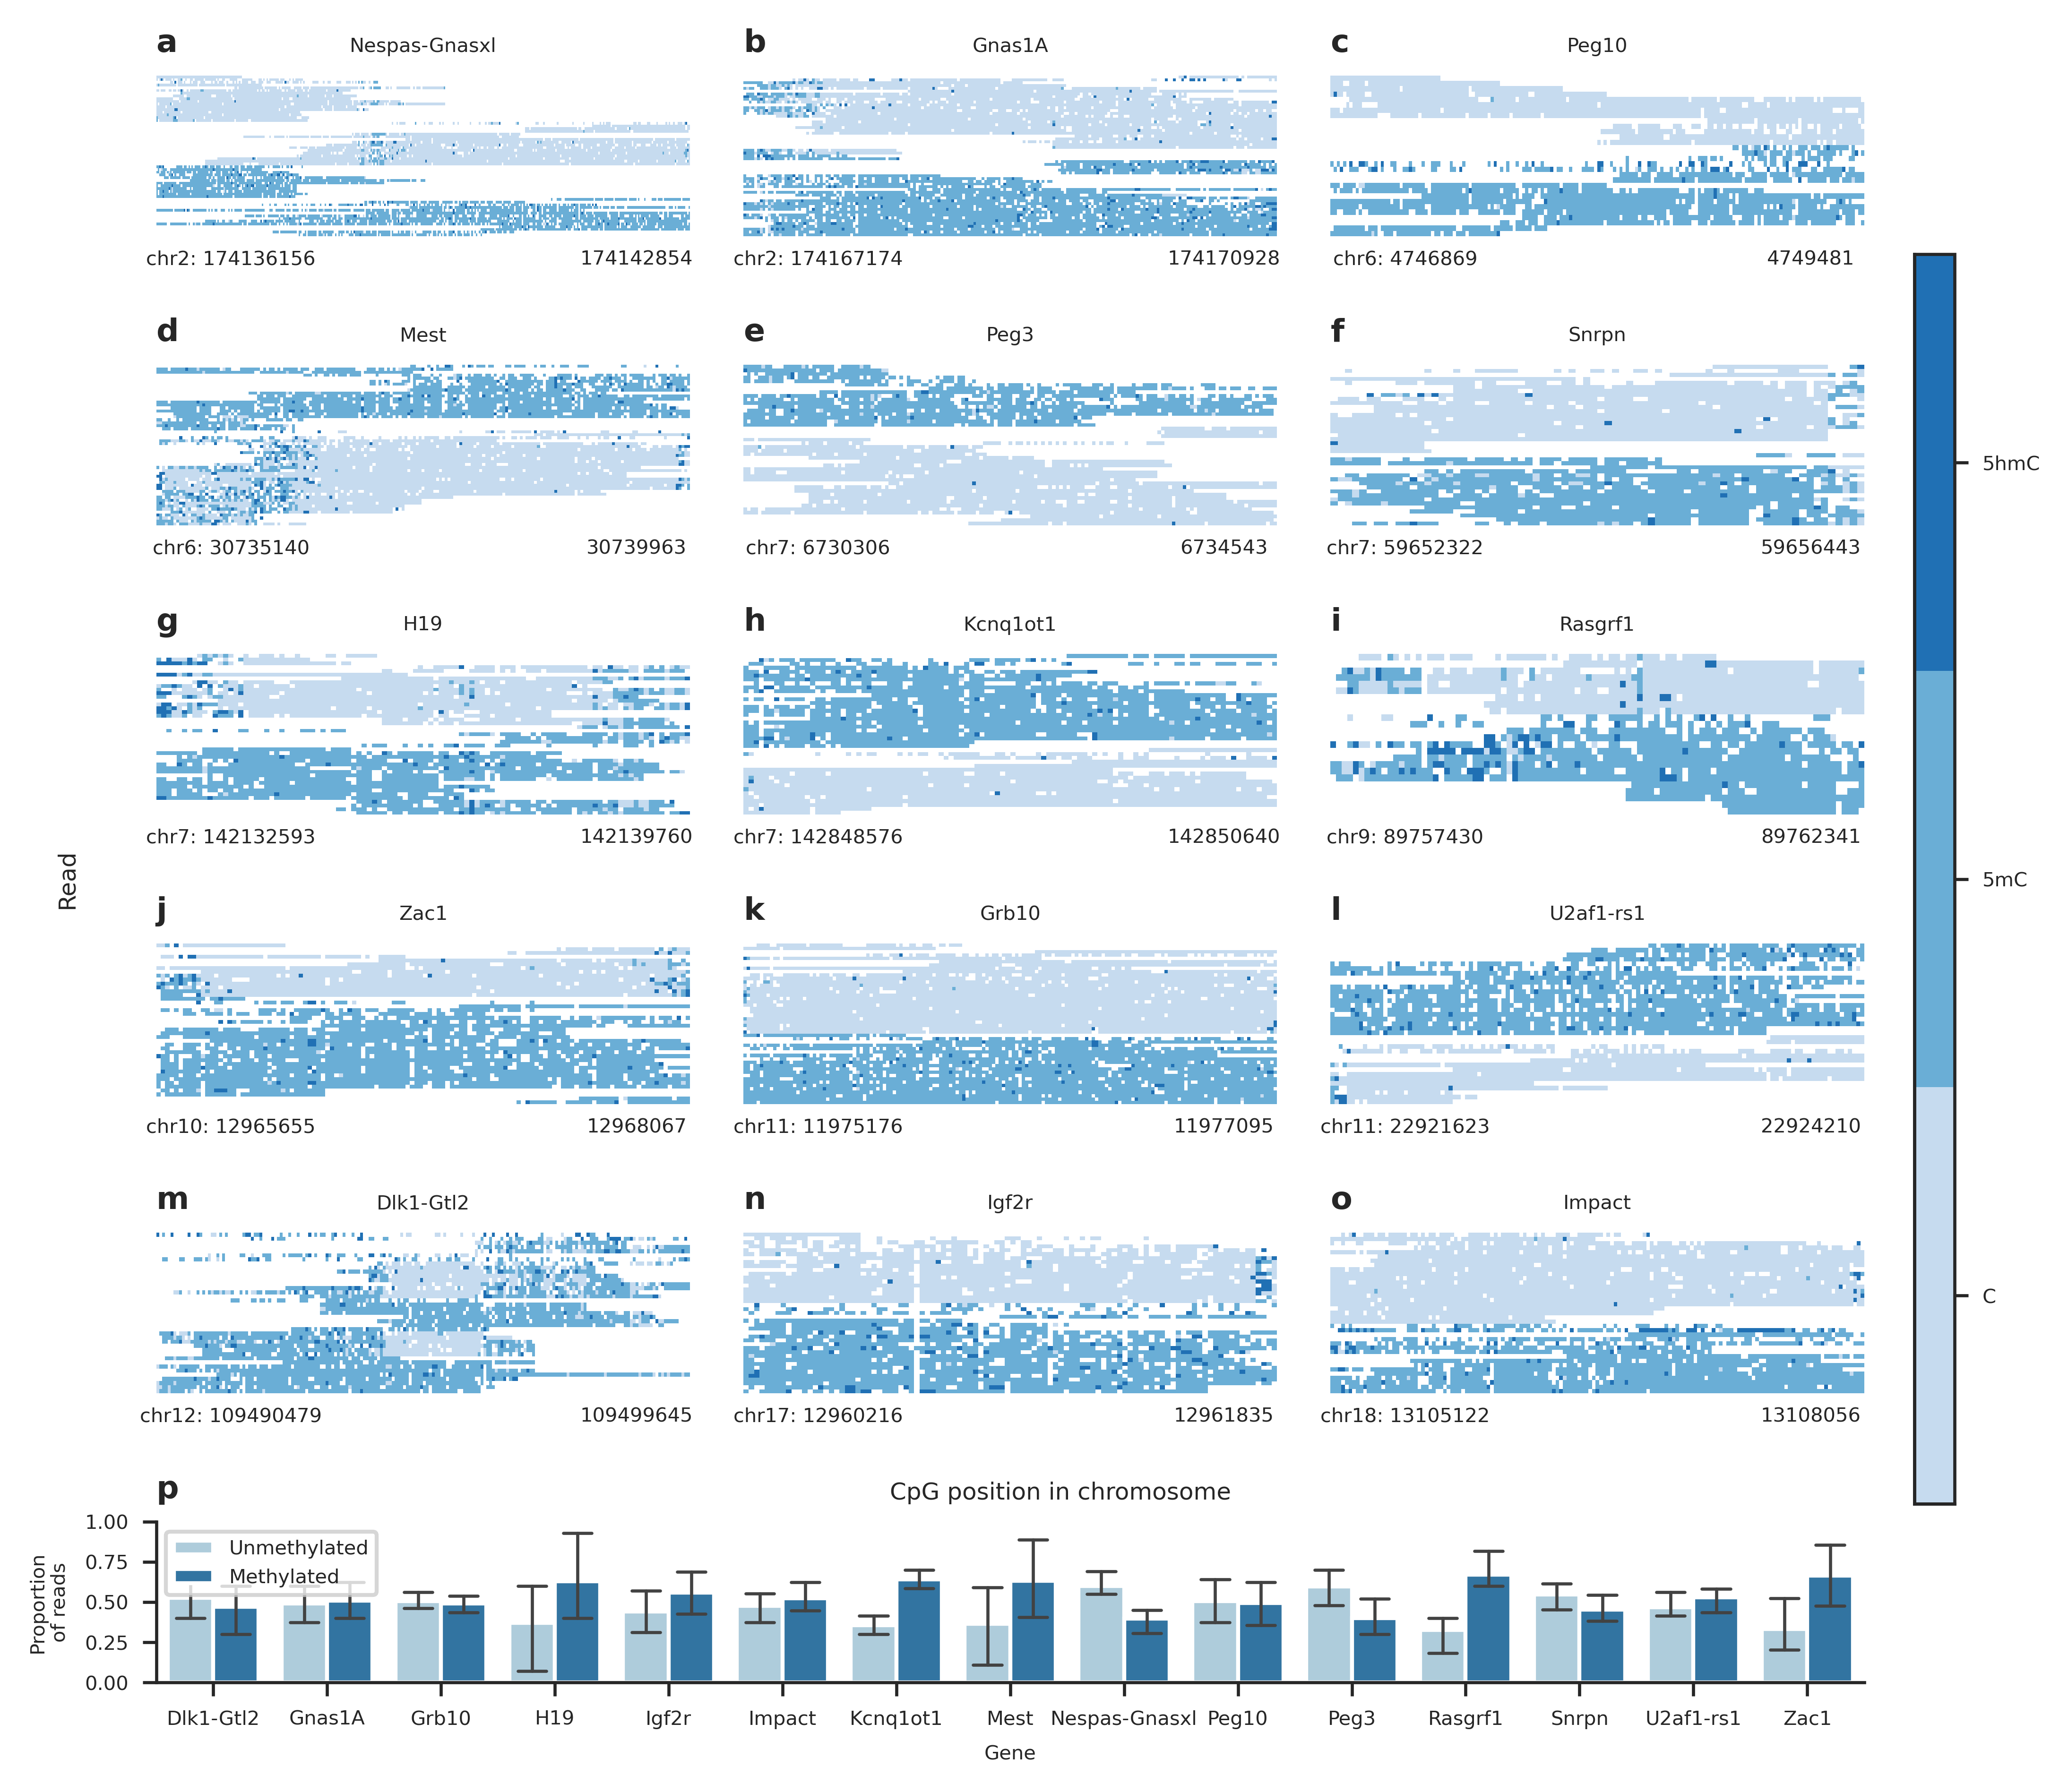

In [20]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import string
import matplotlib as mpl
import seaborn as sns

mpl.rc('font', size=5)
sns.set_style("ticks")

norm = mpl.colors.Normalize(vmin=0, vmax=2)

fig, axes = plt.subplot_mosaic([["A", "B", "C"],
                                ["D", "E", "F"], 
                                ["G", "H", "I"],
                                ["J", "K", "L"],
                                ["M", "N", "O"],
                                ["P", "P", "P"]], 
                                dpi=600, figsize=(180/25.4, 160/25.4))

cmap = (mpl.colors.ListedColormap(sns.color_palette("Blues", 3)))
norm = mpl.colors.BoundaryNorm([0, 1, 2, 3], cmap.N)

cbar_ax = fig.add_axes([.925, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.minorticks_off()
cbar.set_ticks([.5, 1.5, 2.5], labels=["C", "5mC", "5hmC"])

sns.despine()

for dmr, letter, ax in zip(list(read_table.include_bed["Name"]), list(string.ascii_lowercase), axes.values()):
    try:
        read_table.select_gene(f"{dmr}").heatmap(.1, .15, ax=ax)
    except:
        pass
    
    ax.set_title(f"{letter}", loc="left", fontsize=8, fontweight="bold")

    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.tick_params("x", pad=0, labelbottom=True, bottom=False)
    sns.despine(ax=ax, bottom=True, left=True)

fig.supylabel("Read", x=0)
fig.supxlabel("CpG position in chromosome", y=.15)
fig.subplots_adjust(hspace=.8, wspace=.1, bottom=.05, left=.05, top=.95)

sns.barplot(prob_bar_df, x="gene", y="Proportion", 
            hue="Allele", dodge=True, palette="Paired", 
            hue_order=["Unmethylated", "Methylated"],
            errwidth=0.8, capsize=0.25,
            ax=axes["P"])


axes["P"].set_title("p", loc="left", fontsize=8, fontweight="bold")
axes["P"].set_xlabel("Gene")
axes["P"].set_ylabel("Proportion\nof reads")
axes["P"].set_ylim(0, 1)

axes["P"].legend(title=None, loc="upper left")

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/all_DMR_clusters.png", 
            dpi=600)

We now have the readIDs/fragments present within each allele. Within Nespas-Gnasxl there are 39 reads with approx. 98 CpG sites. Note that this can be made larger but less effective at clustering with a lower threshold on CpGs or reads. 

## Main figure

In [123]:
from common import pieData

def proportion(df, mod, round_int=2):
    values, labels = pieData(df, "classification")
    proportion_df = pd.DataFrame(values, labels, columns=["count"])
    proportion_dict = proportion_df.assign(proportion = lambda r: r.div(r.sum())).to_dict()
    
    mod_proportion = proportion_dict["proportion"][mod]
    return round(mod_proportion, round_int)

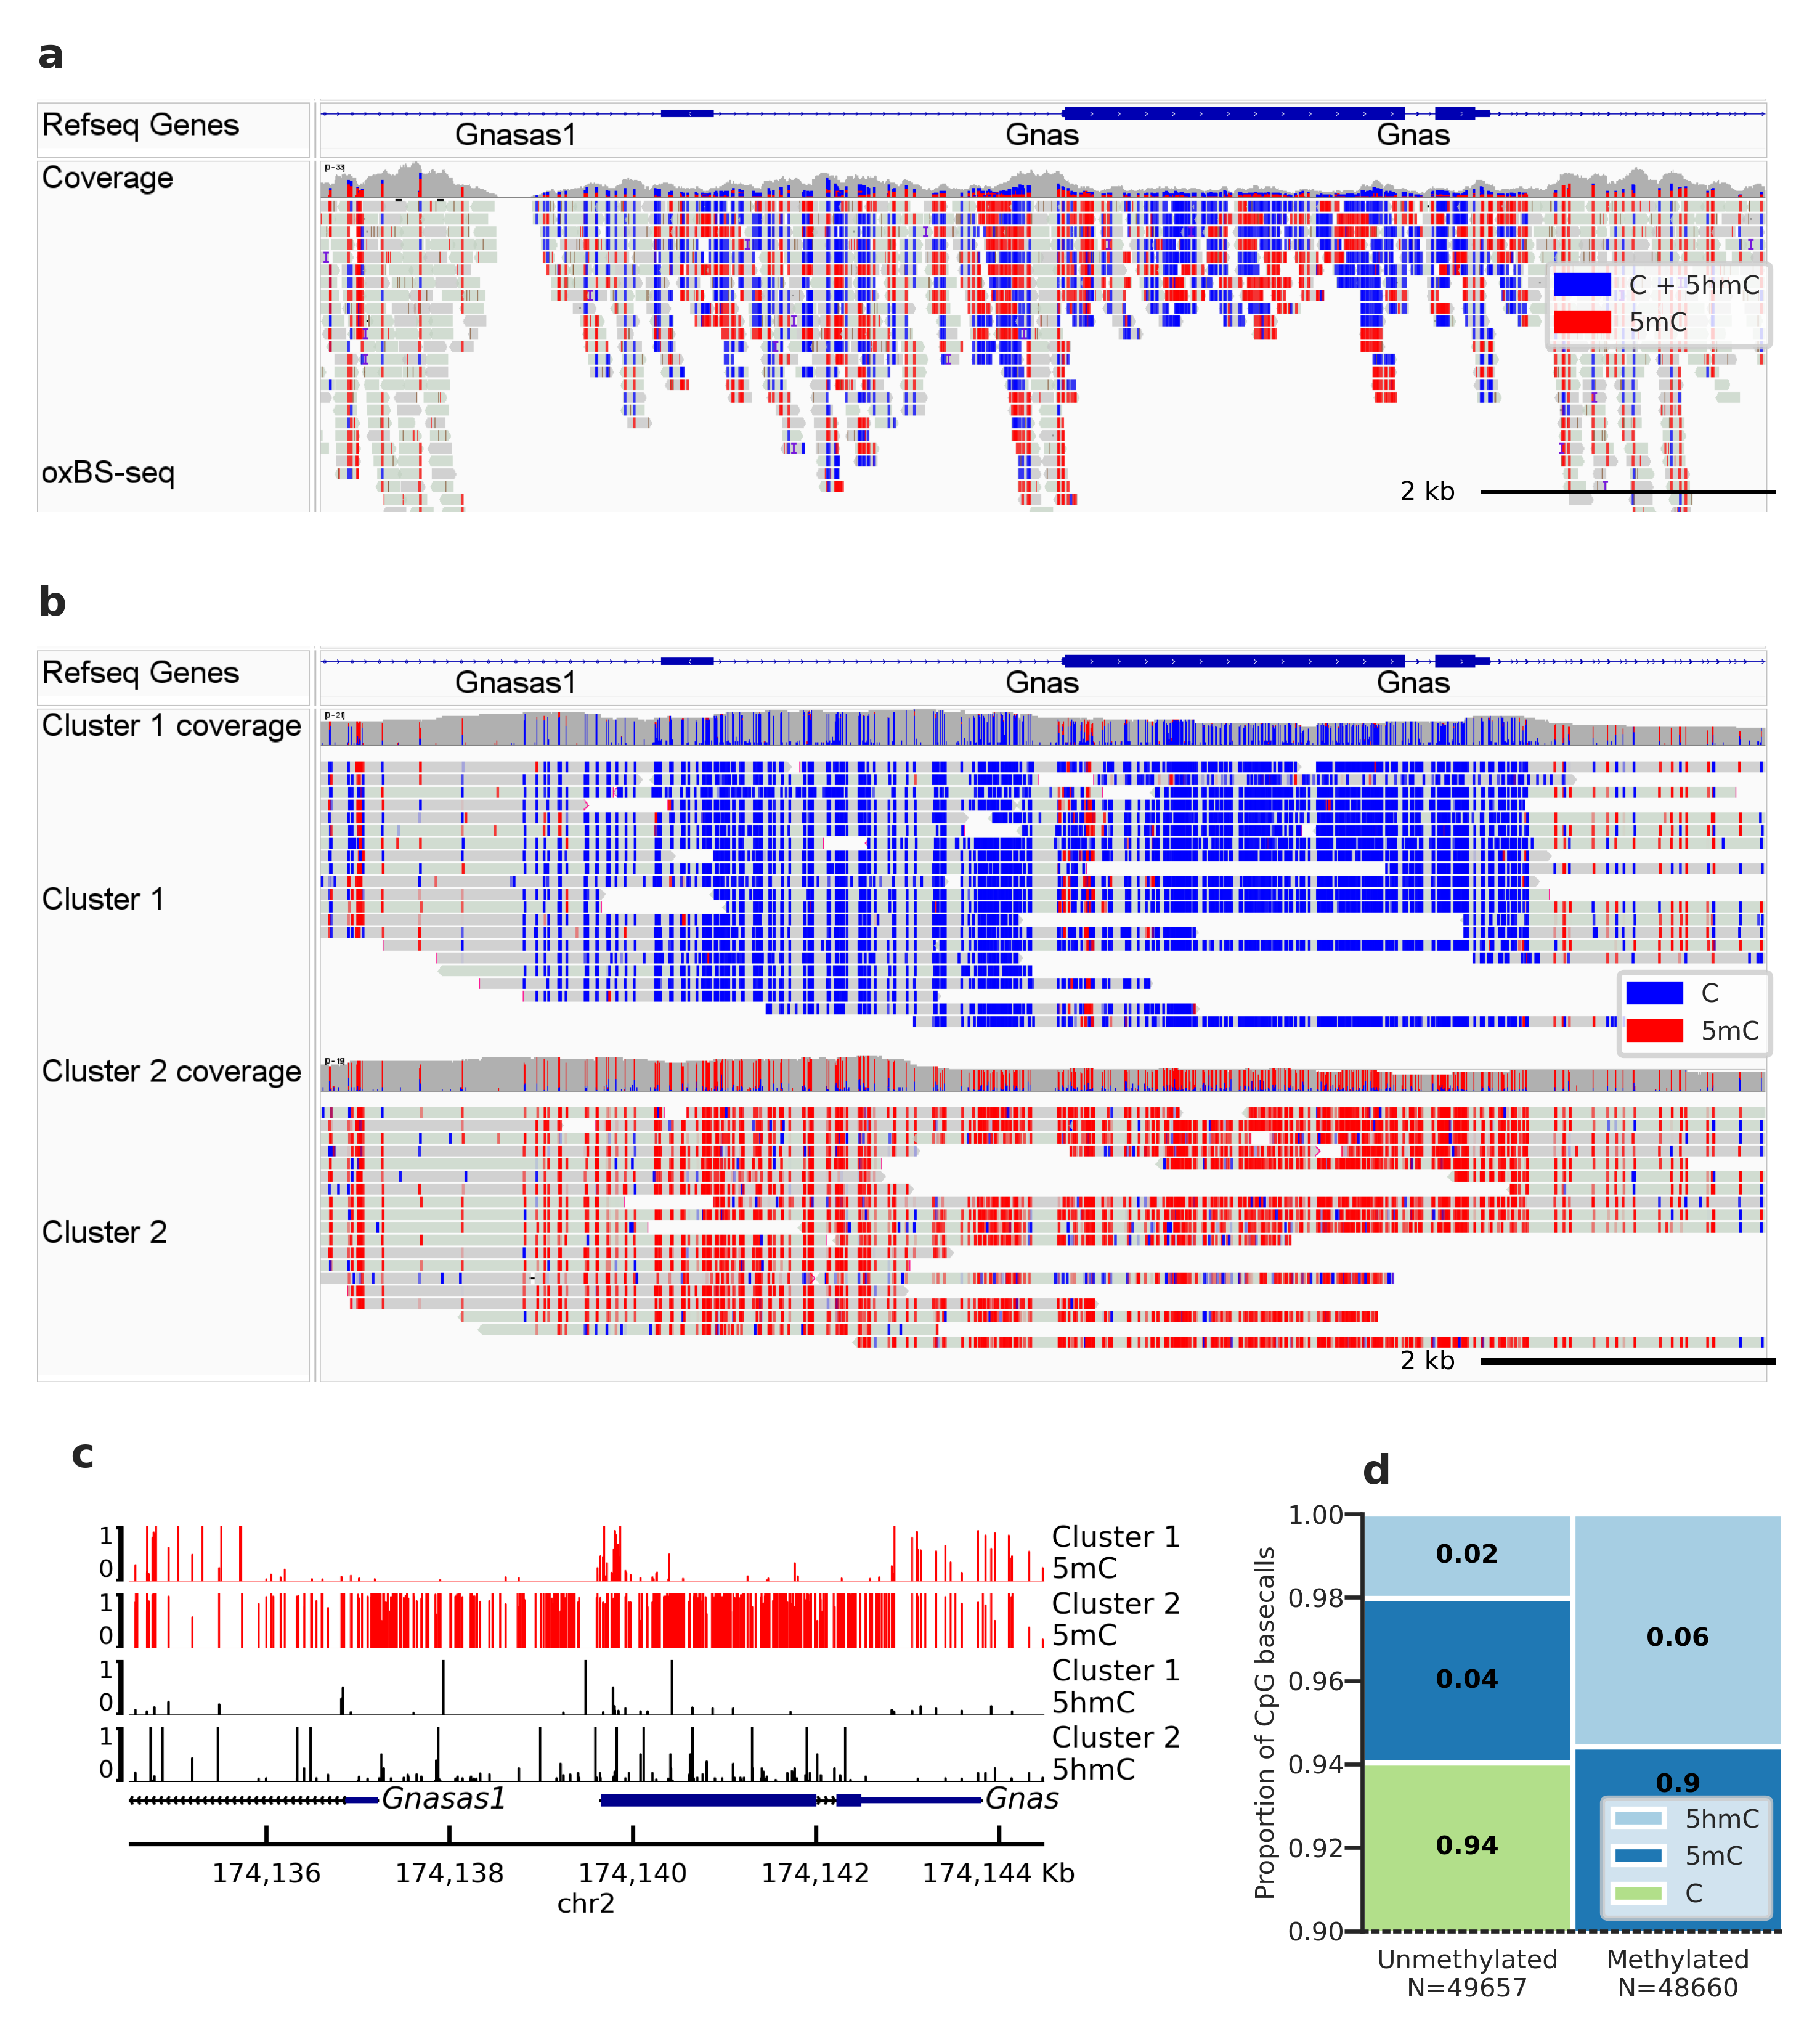

In [124]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
from PIL import Image
import numpy as np

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(120/25.4, 140/25.4), dpi=600)
gs = GridSpec(3, 2, fig, width_ratios=(1, 0.35), height_ratios=(1, 2, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])


dim = matplotlib_scalebar.dimension._Dimension("bp")
dim.add_units("kb", 1000)

# Panel 1 # 
im1 = Image.open("./data_tables/DMR_analysis/Nespas-Gnasx_benchmarks_IGV.png")

w1, h1 = im1.size
scalebar_1 = ScaleBar(10000/(w1-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
im1c = im1.crop((0, 125, w1, 580))

ax1.imshow(im1c)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

l1_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='C + 5hmC'),
                   Patch(facecolor='red', edgecolor='r',
                         label='5mC')]   

l1 = ax1.legend(handles=l1_elements, loc="center right", alignment="left", frameon=True)                 
ax1.add_artist(scalebar_1)

# Panel 2 # 
im2 = Image.open("./data_tables/DMR_analysis/Nespas-Gnasx_IGV.png")

w2, h2 = im2.size
scalebar_2 = ScaleBar(10000/(w2-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
im2c = im2.crop((0, 125, w2, h2))

ax2.imshow(im2c)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

l3_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='C'),
               Patch(facecolor='red', edgecolor='r',
                         label='5mC')]   
ax2.legend(handles=l3_elements, loc="center right", alignment="left", frameon=True)
ax2.add_artist(scalebar_2)

# Panel 3 # 
im3 = Image.open("./data_tables/DMR_analysis/output_images/ICR_pyGenomeTracks_Img.png")
ax3.imshow(im3)
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold", y=1.04)

for ax in [ax1, ax2, ax3]:
    plt.grid(False)
    sns.despine(left=True, bottom=True)
    ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.grid(False)

# Panel 4 # 
all_reps["cluster"] = pd.Categorical(all_reps["cluster"], ["Unmethylated", "Methylated"], ordered=True)
sns.histplot(all_reps, x="cluster", 
             hue="classification", multiple="fill", discrete=True, stat="proportion", 
             alpha=1, palette=sns.color_palette("Paired", 3), 
             hue_order=["5hmC", "5mC", "C"],
             ax=ax4)

u_5hmc = proportion(all_reps.query("cluster == 'Unmethylated'"), "5hmC")
u_5mc = proportion(all_reps.query("cluster == 'Unmethylated'"), "5mC")
u_c = proportion(all_reps.query("cluster == 'Unmethylated'"), "C")
ax4.text(0, 1-(u_5hmc)/2, u_5hmc, ha="center", fontweight="bold", c="black", va="center")
ax4.text(0, 1-(u_5hmc + u_5mc/2), u_5mc, ha="center", fontweight="bold", c="black", va="center")
ax4.text(0, .92, u_c, ha="center", fontweight="bold", c="black", va="center")

m_5mc = proportion(all_reps.query("cluster == 'Methylated'"), "5mC")
m_5hmc = proportion(all_reps.query("cluster == 'Methylated'"), "5hmC")

ax4.text(1, 1-(m_5hmc)/2, m_5hmc, ha="center", fontweight="bold", c="black", va="center")
ax4.text(1, .935, m_5mc, ha="center", fontweight="bold", c="black", va="center")

ax4.set_ylim((.9, 1))

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold", y=1)
ax4.set_xticks(["Unmethylated", "Methylated"], [f"Unmethylated\nN={len(all_reps.loc[all_reps.loc[:, 'cluster'] == 'Unmethylated'])}", 
                                                f"Methylated\nN={len(all_reps.loc[all_reps.loc[:, 'cluster'] == 'Methylated'])}"])
ax4.set_xlabel(None, labelpad=1)
ax4.set_ylabel("Proportion of CpG basecalls", labelpad=1.5)
ax4.get_legend().set_title(None)

ax4.tick_params("x", pad=0, labelbottom=True, bottom=False)
ax4.tick_params("y", which="major", pad=0)
ax4.spines.bottom.set_linestyle("dotted")

sns.move_legend(ax4, "lower right", frameon=True)
sns.despine(ax=ax4, left=False, bottom=False)

fig.subplots_adjust(top = .95, bottom = 0.05, right = 1, left = 0, 
            hspace = 0.15, wspace = 0.15)

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/ICR_IP.png", dpi=600, pad_inches=-2)

In [131]:
proportion(all_reps.query("cluster == 'Unmethylated'"), "5mC", 3)

0.039

In [125]:
m_c = proportion(all_reps.query("cluster == 'Methylated'"), "C", 3)
m_c

0.042

## Reads per allele

In [58]:
from ModkitTools import ModkitExtract
import pandas as pd

read_table = ModkitExtract("data_tables/data_files/nanopore_prom/dmr_files/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_DMRsOnly_modsCalled.tsv").process_read_table()
read_table.set_include_bed("feature_references/dmr/mm39_dmr_coordinatesEdited.bed")

dmr_table_list = []
for dmr in list(read_table.include_bed["Name"]):
    annotated_table = read_table.select_gene(f"{dmr}").cluster_extract(0.1, .15)
    annotated_table = annotated_table.assign(gene = dmr)
    dmr_table_list.append(annotated_table)

bar_df = pd.concat(dmr_table_list).replace(["c", "m", "h"], ["C", "5mC", "5hmC"])

In [59]:
all_sites = bar_df.groupby(["Chromosome", "Start", "End", "cluster"])["classification"].value_counts().reset_index(name="count")
all_sites = all_sites.pivot(index=["Chromosome", "Start", "End", "cluster"], columns="classification", values="count").fillna(0).reset_index()


In [137]:
from scipy import stats

unmethylated_only = all_sites.query("cluster == 'Unmethylated'")
stats.pearsonr(unmethylated_only["5hmC"], unmethylated_only["5mC"])

PearsonRResult(statistic=0.3730119118603126, pvalue=1.4264898173550334e-303)

In [60]:
reads_per_gene = bar_df.groupby(["gene", "read_id"])["cluster"].value_counts().reset_index(name="count")
reads_per_cluster_df = reads_per_gene.groupby("gene")["cluster"].value_counts().reset_index(name="number_reads")
meth_df, unmeth_df = reads_per_cluster_df.query("cluster == 'Methylated'"), reads_per_cluster_df.query("cluster == 'Unmethylated'")

In [61]:
proportions = reads_per_cluster_df.pivot("gene", columns="cluster", values="number_reads").reset_index()
proportions = proportions.assign(methylated_prop = lambda r: r["Methylated"]/(r["Methylated"] + r["Unmethylated"]),
                         unmethylated_prop = lambda r: r["Unmethylated"]/(r["Methylated"] + r["Unmethylated"]))

/tmp/ipykernel_1960468/3427175579.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  proportions = reads_per_cluster_df.pivot("gene", columns="cluster", values="number_reads").reset_index()


In [62]:
proportions

cluster           gene  Methylated  Unmethylated  methylated_prop  \
0            Dlk1-Gtl2          18            17         0.514286   
1               Gnas1A          28            28         0.500000   
2                Grb10          21            27         0.437500   
3                  H19          24            19         0.558140   
4                Igf2r          23            18         0.560976   
5               Impact          17            21         0.447368   
6             Kcnq1ot1          24            17         0.585366   
7                 Mest          22            32         0.407407   
8        Nespas-Gnasxl          27            33         0.450000   
9                Peg10          14            14         0.500000   
10                Peg3          17            27         0.386364   
11             Rasgrf1          21            14         0.600000   
12               Snrpn          18            24         0.428571   
13           U2af1-rs1          21            15         0.583333   
14                Zac1          28            14         0.666667   

cluster  unmethylated_prop  
0                 0.485714  
1                 0.500000  
2                 0.562500  
3                 0.441860  
4                 0.439024  
5                 0.552632  
6                 0.414634  
7                 0.592593  
8                 0.550000  
9                 0.500000  
10                0.613636  
11                0.400000  
12                0.571429  
13                0.416667  
14                0.333333

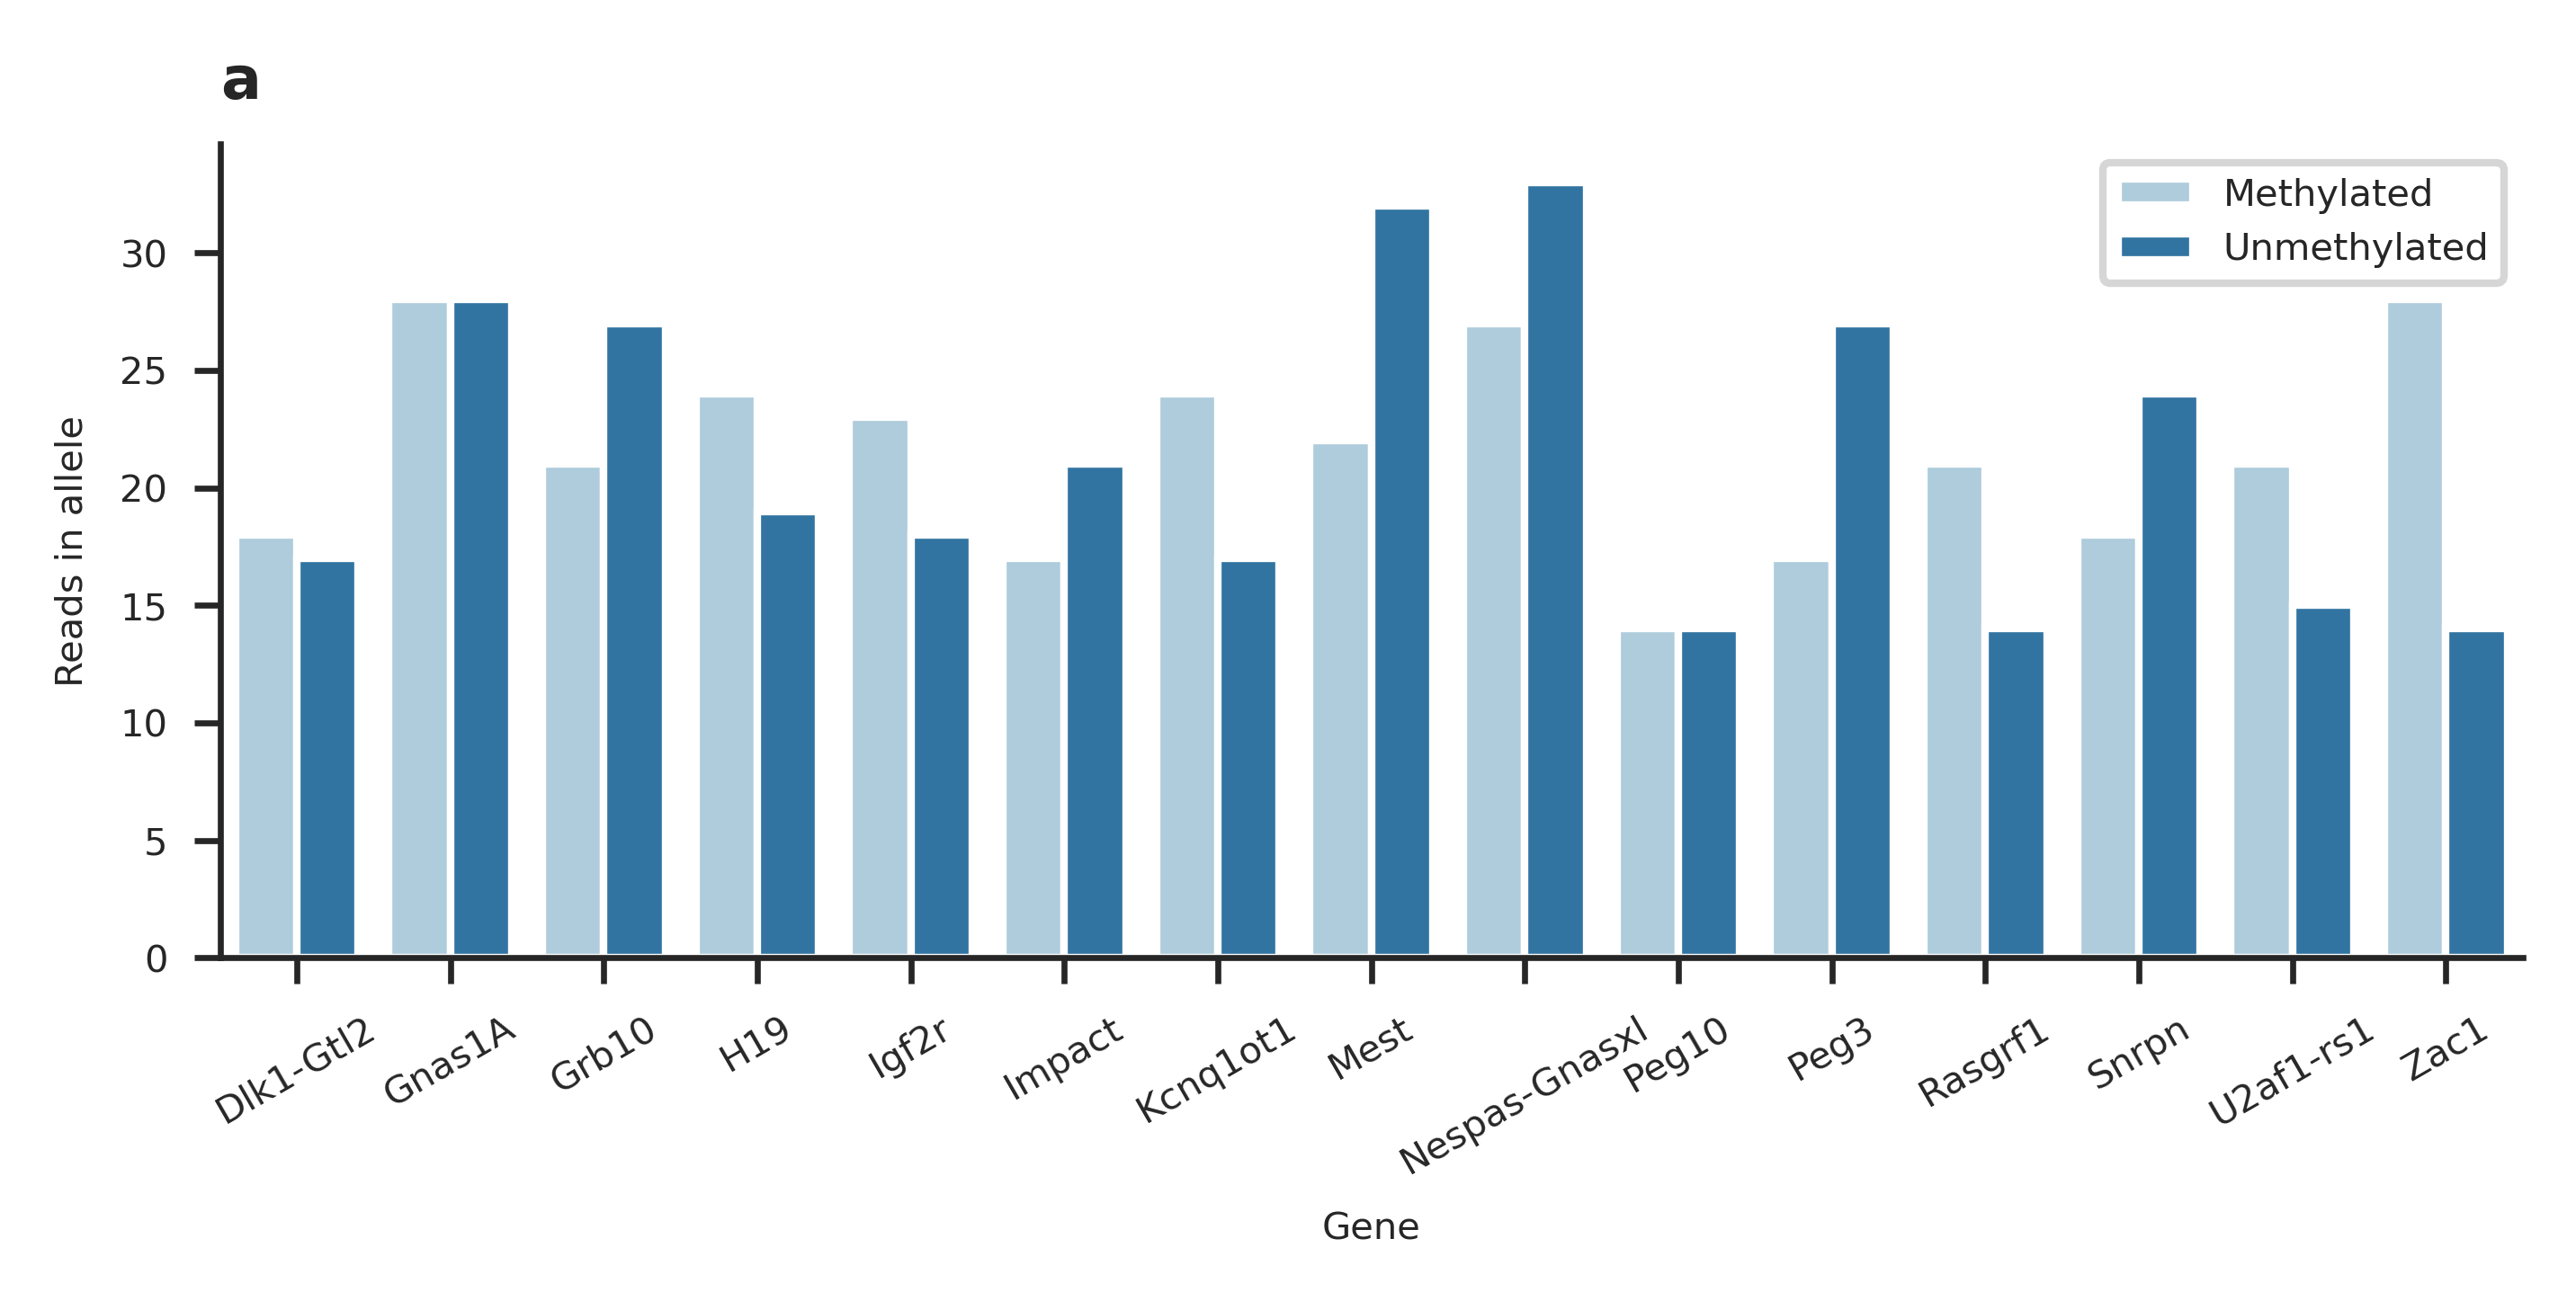

In [21]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(120/25.4, 60/25.4), dpi=600)
gs = GridSpec(1, 1, fig)

ax1 = fig.add_subplot(gs[0, :])

sns.barplot(reads_per_cluster_df, x="gene", y="number_reads", 
            hue="cluster", dodge=True, palette="Paired", 
            ax=ax1)

ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax1.set_ylabel("Reads in allele")
ax1.set_xlabel("Gene")

ax1.tick_params("x", labelrotation=30)
ax1.legend(title=None)

sns.despine()

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/ICR_reads.png", dpi=600)

## Replicate with MinION

In [52]:
read_table = ModkitExtract("data_tables/data_files/nanopore_min/minion_merged_imprinted.tsv").process_read_table()
read_table.set_include_bed("feature_references/dmr/mm39_dmr_coordinatesEdited.bed")

In [53]:
dmr_table_list = []
for dmr in list(read_table.include_bed["Name"]):
    try: 
        annotated_table = read_table.select_gene(f"{dmr}").cluster_extract(0.1, .15)
        annotated_table = annotated_table.assign(gene = dmr)
        dmr_table_list.append(annotated_table)
    except: 
        print(f"Failed at {dmr}.")
        pass

bar_df = pd.concat(dmr_table_list).replace(["c", "m", "h"], ["C", "5mC", "5hmC"])

In [56]:
reads_per_gene = bar_df.groupby(["gene", "read_id"])["cluster"].value_counts().reset_index(name="count")
reads_per_cluster_df = reads_per_gene.groupby("gene")["cluster"].value_counts().reset_index(name="number_reads")
meth_df, unmeth_df = reads_per_cluster_df.query("cluster == 'Methylated'"), reads_per_cluster_df.query("cluster == 'Unmethylated'")

proportions = reads_per_cluster_df.pivot("gene", columns="cluster", values="number_reads").reset_index()
proportions = proportions.assign(methylated_prop = lambda r: r["Methylated"]/(r["Methylated"] + r["Unmethylated"]),
                         unmethylated_prop = lambda r: r["Unmethylated"]/(r["Methylated"] + r["Unmethylated"]))

/tmp/ipykernel_1960468/2066727163.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  proportions = reads_per_cluster_df.pivot("gene", columns="cluster", values="number_reads").reset_index()


In [57]:
proportions

cluster           gene  Methylated  Unmethylated  methylated_prop  \
0            Dlk1-Gtl2           6             9         0.400000   
1               Gnas1A           9             9         0.500000   
2                Grb10          17            16         0.515152   
3                  H19          10            14         0.416667   
4                Igf2r          14             9         0.608696   
5               Impact          10             8         0.555556   
6             Kcnq1ot1          11             6         0.647059   
7                 Mest          24            13         0.648649   
8        Nespas-Gnasxl          11            18         0.379310   
9                Peg10          15            15         0.500000   
10                Peg3          16            19         0.457143   
11             Rasgrf1          10            10         0.500000   
12               Snrpn          11            13         0.458333   
13           U2af1-rs1          11            12         0.478261   
14                Zac1          22            13         0.628571   

cluster  unmethylated_prop  
0                 0.600000  
1                 0.500000  
2                 0.484848  
3                 0.583333  
4                 0.391304  
5                 0.444444  
6                 0.352941  
7                 0.351351  
8                 0.620690  
9                 0.500000  
10                0.542857  
11                0.500000  
12                0.541667  
13                0.521739  
14                0.371429

# hMeDIP analysis

In [2]:
import pandas as pd
import pyranges as pr
from common import *
from MultisiteTools import * 
import warnings

ip_r0_pr = pr.read_bed("data_tables/hmedip/peak_analysis/cbm1_ip_rep0_peaks.bg")
ip_r1_pr = pr.read_bed("data_tables/hmedip/peak_analysis/cbm1_ip_rep1_peaks.bg")
ip_r2_pr = pr.read_bed("data_tables/hmedip/peak_analysis/cbm1_ip_rep2_peaks.bg")


In [8]:
union = pd.concat([ip_r0_pr.as_df(), ip_r1_pr.as_df(), ip_r2_pr.as_df()])
pr.PyRanges(union).merge(False, True)

In [13]:
len(union.query("Name == 1"))/len(union)

0.5596511388410237

### Peak depth histogram

In [3]:
ip_r_all = ip_r0_pr.join(ip_r1_pr, strandedness=None, suffix="_rep_1").join(ip_r2_pr, strandedness=None, suffix="_rep_2")
ip_r_all = ip_r_all.assign("total_peakDepth", lambda pr: pr["Name"] + pr["Name_rep_1"] + pr["Name_rep_2"])


In [8]:
ip_r_all.as_df().query("total_peakDepth >= 10")

Chromosome     Start       End  Name  Start_rep_1  End_rep_1  \
4           chr1   6838491   6838709     1      6838098    6838666   
24          chr1  13440492  13441558     5     13440821   13441515   
25          chr1  13440492  13441558     5     13440821   13441515   
26          chr1  13440492  13441558     5     13440821   13441515   
31          chr1  15685730  15686220     5     15685653   15686285   
...          ...       ...       ...   ...          ...        ...   
33247       chrY  90815892  90818257     7     90816952   90818315   
33248       chrY  90815892  90818257     7     90816952   90818315   
33249       chrY  90818577  90819643     5     90818774   90819306   
33250       chrY  90819943  90821007     5     90820040   90821214   
33252       chrY  90821598  90822082     2     90821371   90822528   

       Name_rep_1  Start_rep_2  End_rep_2  Name_rep_2  total_peakDepth  
4               5      6838591    6839289           4               10  
24              4     13440280   13440805           4               13  
25              4     13440846   13441055           1               10  
26              4     13441527   13441755           1               10  
31              4     15685824   15686229           1               10  
...           ...          ...        ...         ...              ...  
33247           4     90815924   90816900           5               16  
33248           4     90817559   90818223           5               16  
33249           2     90818402   90819822           8               15  
33250           3     90820535   90820917           2               10  
33252           4     90821860   90822401           4               10  

[4544 rows x 11 columns]

### Feature pie chart 
Moved to SFig but calculation still necessary

In [4]:
import numpy as np
import FeatureReferences
from common import pieData

annotated_peaks = FeatureReferences.featureRefPyRange("./feature_references/genic/").join(ip_r_all, how="right", 
                                                                        strandedness=False, apply_strand_suffix=False, 
                                                                        report_overlap=True, suffix="_Peak").as_df()
annotated_peaks_grouped = annotated_peaks.sort_values("Overlap", ascending=False).groupby(
    ["Chromosome", "Start_Peak", "End_Peak", "total_peakDepth"]).head(1).replace(
    {"-1" : "Intergenic",
     "3UTR" : "Exon",
     "5UTR" : "Exon"})

# Used in SFig.
pie_values, pie_labels = pieData(annotated_peaks_grouped, "feature_type", 10, 30)

### Bar plot

In [5]:
import FeatureReferences

@asPyRangesDecorator
def chromSizePr():
    return loadChromSize()

tiled_genome = pr.genomicfeatures.tile_genome(chromSizePr(), 500)
annotated_genome = FeatureReferences.featureRefPyRange("./feature_references/genic/").join(tiled_genome, None, "right", apply_strand_suffix=False, 
                                                                        report_overlap=True, suffix="_Window").as_df()

annotated_genome = annotated_genome.replace([-1, "-1", "3UTR", "5UTR", "TSS"], ["Intergenic", "Intergenic", "Exon", "Exon", "Promoter"])

genome_values, genome_labels = pieData(annotated_genome, "feature_type")

genome = pd.DataFrame(genome_values, genome_labels, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))
peaks = pd.DataFrame(pie_values, pie_labels, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))
comp = pd.Series(np.log2(peaks["proportion"]/genome["proportion"]))

Changing colnames to be PyRanges compatible...
Done


### Bar plot 5hmC call enrichment

In [6]:
from common import *
import pyranges as pr

peaks_pr = pr.PyRanges(ip_r_all.as_df().query("total_peakDepth >= 10 & total_peakDepth <= 30"))

pilot = readModkit("data_tables/data_files/nanopore_hmedip/pilot_modified_bases_modkit.bed", 1, False, True)
rep1 = readModkit("data_tables/data_files/nanopore_hmedip/cbm1_ip_rep1_modbases_mapq60.bed", 1, False, True)
rep2 = readModkit("data_tables/data_files/nanopore_hmedip/cbm1_ip_rep2_23_05_09_mapq60.bed", 1, False, True)

In [7]:
all_reps = pd.concat([pilot, rep1, rep2], ignore_index=True)
grouped_cpgs = all_reps.groupby(["Chromosome", "Start", "End", "Strand"]).agg({
    "readCount" : sum,
    "N_C" : sum,
    "N_mC" : sum,
    "N_hmC" : sum
}).reset_index()

top_peak_cpgs = peaks_pr.join(asPyRanges(grouped_cpgs), strandedness=False, suffix="_CpG", apply_strand_suffix=False).as_df()
top_peak_cpgs = top_peak_cpgs.drop(columns=["Name", "Start_rep_1", "End_rep_1" ,"Name_rep_1", "Start_rep_2", "End_rep_2", "Name_rep_2"])

Changing colnames to be PyRanges compatible...
Done


In [8]:
if not "prom_raw" in locals().keys():
    prom_raw = readModkit("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False, True)

wgs_cpgs_agg = prom_raw.agg({
    "N_C" : sum, 
    "N_mC" : sum, 
    "N_hmC" : sum
})

c_call_enrichment_wgs = pd.DataFrame(wgs_cpgs_agg, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))

agg_peak_cpgs = top_peak_cpgs.agg({
    "N_C" : sum, 
    "N_mC" : sum, 
    "N_hmC" : sum
})
c_call_enrichment_peak = pd.DataFrame(agg_peak_cpgs, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))

bar_comp = pd.Series(((c_call_enrichment_peak["proportion"] - c_call_enrichment_wgs["proportion"])/c_call_enrichment_wgs["proportion"])*100)
bar_comp.index = ["C", "5mC", "5hmC"]

### Peak context histogram
Note: Different thresholds on CpG depth for TAB mean different numbers of CpGs overall.

In [3]:
import numpy as np
from common import asPyRanges
import pandas as pd
from MultisiteTools import CpGRange

prom_comp_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

# renaming columns for compatability with PyRanges
prom_comp_data = asPyRanges(prom_comp_data).as_df()
prom_comp_pr = CpGRange(prom_comp_data)

Changing colnames to be PyRanges compatible...
Done


In [6]:
import warnings 
import pyranges as pr

with warnings.catch_warnings():
    tiles = pr.PyRanges(prom_comp_pr.group_by_tile(1000).enrichment_over_mean(native=False).df)

Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']


In [15]:
tiles.as_df().query("CpG_count > 5").corr()

/tmp/ipykernel_188390/1043647539.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tiles.as_df().query("CpG_count > 5").corr()


Start       End  percentMeth_5hmC_Nanopore  \
Start                         1.000000  1.000000                   0.028044   
End                           1.000000  1.000000                   0.028044   
percentMeth_5hmC_Nanopore     0.028044  0.028044                   1.000000   
percentMeth_5hmC_TAB          0.031129  0.031129                   0.852902   
CpG_count                     0.024033  0.024033                   0.012005   
log2enrichment_5hmC_Nanopore  0.038909  0.038909                   0.897157   
log2enrichment_5hmC_TAB       0.044857  0.044857                   0.741146   

                              percentMeth_5hmC_TAB  CpG_count  \
Start                                     0.031129   0.024033   
End                                       0.031129   0.024033   
percentMeth_5hmC_Nanopore                 0.852902   0.012005   
percentMeth_5hmC_TAB                      1.000000   0.010425   
CpG_count                                 0.010425   1.000000   
log2enrichment_5hmC_Nanopore              0.754626   0.043131   
log2enrichment_5hmC_TAB                   0.898583   0.040867   

                              log2enrichment_5hmC_Nanopore  \
Start                                             0.038909   
End                                               0.038909   
percentMeth_5hmC_Nanopore                         0.897157   
percentMeth_5hmC_TAB                              0.754626   
CpG_count                                         0.043131   
log2enrichment_5hmC_Nanopore                      1.000000   
log2enrichment_5hmC_TAB                           0.759126   

                              log2enrichment_5hmC_TAB  
Start                                        0.044857  
End                                          0.044857  
percentMeth_5hmC_Nanopore                    0.741146  
percentMeth_5hmC_TAB                         0.898583  
CpG_count                                    0.040867  
log2enrichment_5hmC_Nanopore                 0.759126  
log2enrichment_5hmC_TAB                      1.000000

In [ ]:
    
tiled_peak_df = ip_r_all.join(tiles, suffix="_Tile", report_overlap=True).as_df()
tiled_peak_df = tiled_peak_df.sort_values("Overlap",ascending=False).groupby(["Chromosome", "Start", "End"]).head(1)

tiled_peak_df["peakDepth_cat"] = pd.cut(tiled_peak_df["total_peakDepth"], 
                                        bins=[10, 14, 18, np.inf],
                                        labels=[10, 14, "18+"],
                                        include_lowest=True, right=False)

histplot_df = ip_r_all.as_df().melt(["Chromosome", "Start", "End"], ["Name", "Name_rep_1", "Name_rep_2"], var_name="Replicate", value_name="peakDepth").replace(
    ["Name", "Name_rep_1", "Name_rep_2"], 
    ["hMeDIP pilot", "hMeDIP 1", "hMeDIP 2"]
)

Note - only using top 10% of most CpG rich tiles (X >= 6)

In [20]:
tiled_peak_df.query("total_peakDepth >= 10 & total_peakDepth < 15")

Chromosome      Start        End  Name  Start_rep_1  End_rep_1  \
9722        chr4  129117669  129119182     8    129118912  129119265   
26818      chr11    3776900    3778085     8      3777698    3777899   
34701      chr14  120589762  120591159     5    120588277  120589873   
1027        chr1   88182681   88184978     3     88184752   88185419   
11249       chr4  155180872  155182246     2    155180186  155181271   
...          ...        ...        ...   ...          ...        ...   
24130       chr9  108024448  108025013     3    108024689  108025291   
21314       chr8  121135988  121138936     5    121137206  121137916   
25867      chr10   81267799   81268011     1     81267832   81268888   
23000       chr9   58397129   58398010     4     58397030   58397663   
27760      chr11   65048275   65049001     6     65047770   65048291   

       Name_rep_1  Start_rep_2  End_rep_2  Name_rep_2  total_peakDepth  \
9722            1    129118395  129119001           5               14   
26818           1      3777468    3778163           3               12   
34701           4    120589684  120590513           3               12   
1027            2     88184030   88185498           6               11   
11249           5    155180776  155181797           4               11   
...           ...          ...        ...         ...              ...   
24130           4    108024207  108024564           3               10   
21314           3    121136747  121138094           5               13   
25867           6     81267541   81268603           4               11   
23000           3     58396883   58397701           4               11   
27760           1     65048480   65049777           7               14   

       Start_Tile   End_Tile  percentMeth_5hmC_Nanopore  percentMeth_5hmC_TAB  \
9722    129118000  129119000                  27.234000             48.818182   
26818     3777000    3778000                  32.768000             32.233766   
34701   120590000  120591000                  31.498750             37.476872   
1027     88183000   88184000                   8.330000              0.000000   
11249   155181000  155182000                  34.807778             45.622896   
...           ...        ...                        ...                   ...   
24130   108025000  108026000                  25.000000             50.000000   
21314   121135000  121136000                  80.000000             60.000000   
25867    81268000   81269000                  25.000000             45.454545   
23000    58398000   58399000                  33.330000             64.285714   
27760    65049000   65050000                  31.515000             38.570203   

       CpG_count  log2enrichment_5hmC_Nanopore  log2enrichment_5hmC_TAB  \
9722           5                      1.516185                 2.087030   
26818          5                      1.774409                 1.503007   
34701         16                      1.719136                 1.714349   
1027           1                     -0.081299                -3.551570   
11249          9                      1.859025                 1.991396   
...          ...                           ...                      ...   
24130          1                      1.397263                 2.120855   
21314          1                      3.036674                 2.379167   
25867          1                      1.397263                 1.986177   
23000          1                      1.798222                 2.477125   
27760         18                      1.719857                 1.754772   

       Overlap peakDepth_cat  
9722      1000            14  
26818     1000            10  
34701     1000            10  
1027      1000            10  
11249     1000            10  
...        ...           ...  
24130       13            10  
21314       12            10  
25867       11            10  
23000       10            10  
27760        1            14  

[2844

In [26]:
len(tiled_peak_df.query("total_peakDepth >= 10 & log2enrichment_5hmC_TAB > 0"))/len(tiled_peak_df.query("total_peakDepth >= 10"))

0.9195588712293221

## Figure

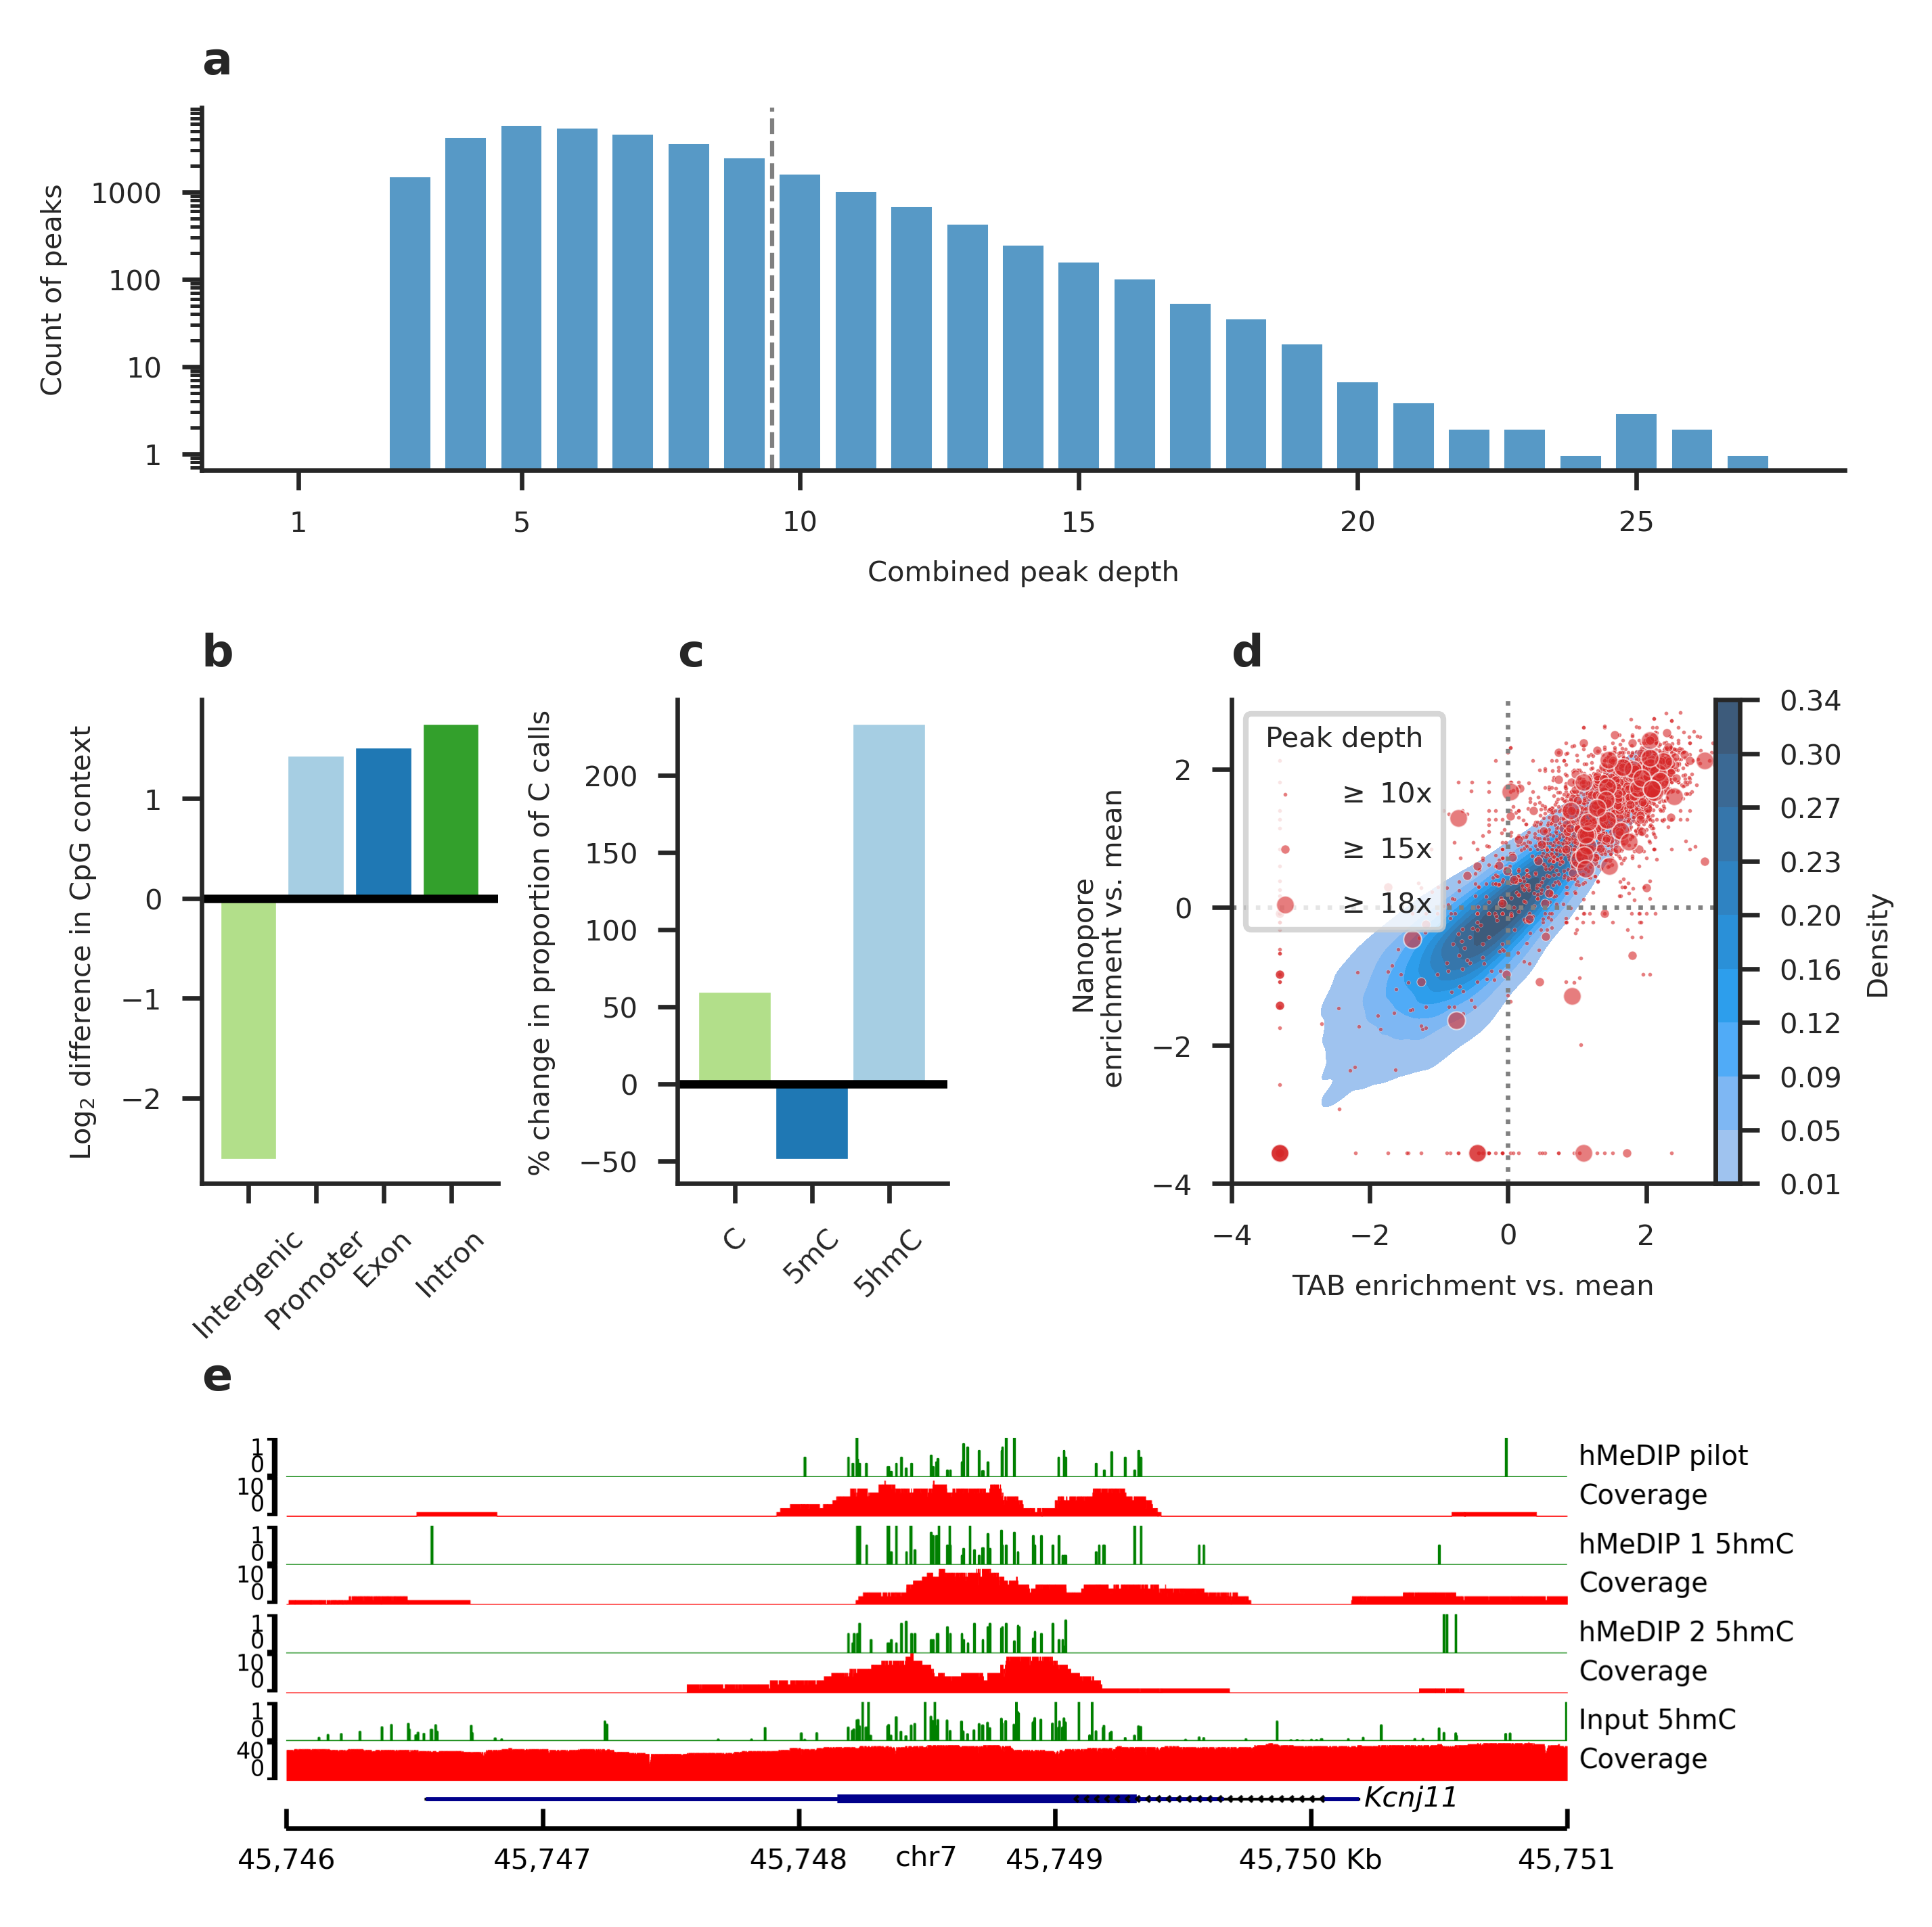

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import math

fig = plt.figure(figsize=(120/25.4, 120/25.4), dpi=600)
sns.set_style("ticks")
mpl.rc('font', size=5)

gs = GridSpec(3, 4, fig, height_ratios=(0.75, 1, 1), width_ratios=(1.1, 1, 1, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2:])
ax5 = fig.add_subplot(gs[2, :])

# Panel 1 # 

sns.histplot(ip_r_all.as_df(), x="total_peakDepth", 
             binrange=(1, 27), discrete=True, shrink=0.8, log_scale=(False, True), element="bars",  
             ax=ax1)

ax1.set_xticks([1, 5, 10, 15, 20, 25])
ax1.set_xlabel("Combined peak depth")
ax1.set_ylabel("Count of peaks")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1i"))

ax1.axvline(9.5, lw=0.75, ls="--", c="grey")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

# Panel 2 #

colors = [sns.color_palette("Paired", 4)[2], sns.color_palette("Paired", 4)[0], sns.color_palette("Paired", 4)[1], sns.color_palette("Paired", 4)[3]]
comp.sort_values().plot.bar(ax=ax2, 
                            width=.9,
                            color=colors)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.axhline(0, c="k")
ax2.set_ylabel(f"Log$_{2}$ difference in CpG context")
ax2.tick_params(axis="x", which="both", labelrotation=45)

# Panel 3 #

ax3.axhline(0, c="k")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
bar_comp.plot.bar(color=sns.color_palette("Paired", 3)[::-1], 
                  width=1,
                  ax=ax3)
ax3.set_ylabel(f"% change in proportion of C calls")
ax3.tick_params(axis="x", which="both", labelrotation=45)


# Panel 4 # 

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes("right", size="5%", pad=0)

sns.kdeplot(tiles.as_df().query("CpG_count >= 15"), 
            x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
            fill=True, 
            cbar=True, cbar_ax=cax4, cbar_kws={"format" : "%2.2f",
                                               "label" : "Density"},
            ax=ax4)

sns.scatterplot(tiled_peak_df.query("total_peakDepth >= 10 & total_peakDepth < 15"),
                x="log2enrichment_5hmC_Nanopore", y="log2enrichment_5hmC_TAB",
                s=.5, label=f"$\geq$ 10x",
                alpha=.6, c="tab:red", 
                ax=ax4)

sns.scatterplot(tiled_peak_df.query("total_peakDepth >= 15 & total_peakDepth < 18"),
                x="log2enrichment_5hmC_Nanopore", y="log2enrichment_5hmC_TAB",
                s=2.5, label=f"$\geq$ 15x",
                alpha=.6, c="tab:red", 
                ax=ax4)

sns.scatterplot(tiled_peak_df.query("total_peakDepth >= 18"),
                x="log2enrichment_5hmC_Nanopore", y="log2enrichment_5hmC_TAB",
                s=10, label=f"$\geq$ 18x",
                alpha=.6, c="tab:red", 
                ax=ax4)

smallest = min([math.floor(tiles.as_df().query("CpG_count >= 15")["log2enrichment_5hmC_Nanopore"].min()), math.floor(tiles.as_df().query("CpG_count >= 15")["log2enrichment_5hmC_TAB"].min())])
biggest = min([math.ceil(tiles.as_df().query("CpG_count >= 15")["log2enrichment_5hmC_Nanopore"].max()), math.ceil(tiles.as_df().query("CpG_count >= 15")["log2enrichment_5hmC_TAB"].max())])

ax4.set_xticks(ticks=range(smallest, biggest + 1, 2))
ax4.set_yticks(ticks=range(smallest, biggest + 1, 2))

ax4.axvline(x=0, ls=":", c="grey", lw=0.8)
ax4.axhline(y=0, ls=":", c="grey", lw=0.8)

ax4.set_xlim(smallest, biggest)
ax4.set_ylim(smallest, biggest)

ax4.set_aspect("equal")
ax4.set_xlabel("TAB enrichment vs. mean")
ax4.set_ylabel("Nanopore\n enrichment vs. mean")
ax4.legend(title="Peak depth", loc="upper left", labelspacing=1)

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

# Panel 6 # 

im5 = plt.imread("./data_tables/hmedip/rep_image/output_img/hmedip_repImg1.png")
ax5.imshow(im5)
ax5.grid(False)
ax5.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
ax5.set_title("e", loc="left", fontsize=8, fontweight="bold")

sns.despine(fig)
sns.despine(ax=ax5, bottom=True, left=True, right=True)

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP.png", dpi=600)

How CpG dense? 

In [29]:
tiled_peak_pr = pr.PyRanges(tiled_peak_df)
all_overlaps = ip_r0_pr.overlap(ip_r1_pr).overlap(ip_r2_pr).overlap(tiled_peak_pr)
mouse_genome_overlaps = pr.get_sequence(all_overlaps, "../../data/reference_genomes/mm39/mm39.fa")

In [30]:
densities = []
for sequence in mouse_genome_overlaps: 
    cpg_count = sequence.upper().count("CG")
    total_length = len(sequence)
    density = (cpg_count/total_length)*100 
    densities.append(density)

# calculated in GeneralNotes.ipynb
genome_cg_density = 0.48245101843420024
(sum(densities)/len(densities))/genome_cg_density

3.671790837574662

How many peaks in enriched area? 

In [25]:
df = tiled_peak_df.query("total_peakDepth >= 10 & total_peakDepth <= 30")
len(df.query("log2enrichment_5hmC_TAB > 0"))/len(df)

0.9207534913933095

What % of all CpG-context C calls are C/5mC/5hmC?

In [28]:
all_reps = pd.concat([pilot, rep1, rep2], ignore_index=True)
grouped_cpgs = all_reps.groupby(["Chromosome", "Start", "End", "Strand"]).agg({
    "readCount" : sum,
    "N_C" : sum,
    "N_mC" : sum,
    "N_hmC" : sum
}).reset_index()

In [31]:
top_peak_cpgs = peaks_pr.join(asPyRanges(grouped_cpgs), suffix="_CpG").as_df()
top_peak_cpgs = top_peak_cpgs.drop(columns=["Name", "Start_rep_1", "End_rep_1" ,"Name_rep_1", "Start_rep_2", "End_rep_2", "Name_rep_2"])

Changing colnames to be PyRanges compatible...
Done


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [32]:
n_hmc = top_peak_cpgs["N_hmC"].sum()
n_mc = top_peak_cpgs["N_mC"].sum()
all_cpgs = top_peak_cpgs["readCount"].sum()

n_hmc/all_cpgs, n_mc/all_cpgs

(0.2777021899664702, 0.3360466943240054)

## hMeDIP-seq context

How does average peak 5hmC % correlate with region 5hmC in WGS? 

In [74]:
top_peaks_5hmC = top_peak_cpgs.groupby(["Chromosome", "Start", "End"], observed=True).agg({
    "N_hmC" : sum,
    "readCount" : sum
}).reset_index()
top_peaks_5hmC = top_peaks_5hmC.assign(percentMeth_5hmC = lambda r: (r["N_hmC"].div(r["readCount"])*100))

In [85]:
pr.PyRanges(top_peaks_5hmC).tile(1000).as_df()

Chromosome     Start       End  N_hmC  readCount  percentMeth_5hmC
0          chr1   6838000   6839000    2.0        2.0        100.000000
1          chr1  13440000  13441000   30.0      132.0         22.727273
2          chr1  13441000  13442000   30.0      132.0         22.727273
3          chr1  15685000  15686000    6.0        9.0         66.666667
4          chr1  15686000  15687000    6.0        9.0         66.666667
...         ...       ...       ...    ...        ...               ...
6268       chrY  90819000  90820000   20.0       71.0         28.169014
6269       chrY  90820000  90821000   20.0       71.0         28.169014
6270       chrY  90821000  90822000   20.0       71.0         28.169014
6271       chrY  90821000  90822000    7.0       29.0         24.137931
6272       chrY  90822000  90823000    7.0       29.0         24.137931

[6273 rows x 6 columns]

In [89]:
tiles.as_df()["percentMeth_5hmC_Nanopore"].mean()

8.427465916899767

In [78]:
peaks_vs_wgs = pr.PyRanges(top_peaks_5hmC).join(tiles, suffix="_tile").as_df()

In [86]:
peaks_vs_wgs["percentMeth_5hmC_Nanopore"].mean()

25.998063817865557

In [92]:
from scipy import stats
stats.pearsonr(peaks_vs_wgs["percentMeth_5hmC"], peaks_vs_wgs["percentMeth_5hmC_Nanopore"])

PearsonRResult(statistic=0.2162146305663219, pvalue=3.0166222717816847e-56)

### Venn Diagram

In [254]:
from matplotlib_venn import venn3
def VennDiagrammer(r0, r1, r2, ax):
    r0_only = len(r0.intersect(r1, invert=True).intersect(r2, invert=True))
    r1_only = len(r1.intersect(r2, invert=True).intersect(r0, invert=True))
    r2_only = len(r2.intersect(r0, invert=True).intersect(ip_r1_pr, invert=True))

    r01 = len(r0.intersect(r1, invert=False).intersect(r2, invert=True))
    r02 = len(r0.intersect(r2, invert=False).intersect(r1, invert=True))
    r12 = len(r1.intersect(r2, invert=False).intersect(r0, invert=True))

    r012 = len(r0.intersect(r1, invert=False).intersect(r2, invert=False))
    
    total = sum([r0_only, r1_only, r2_only, r01, r02, r12, r012])

    venn = venn3(
        {
    "001" : r0_only,
    "010" : r1_only,
    "100" : r2_only,
    "011" : r01,
    "110" : r12,
    "101" : r02,
    "111" : r012
    },
    set_labels=["hMeDIP 2", "hMeDIP 1", "hMeDIP pilot",],
    set_colors=[sns.color_palette("Paired", 3)[2], sns.color_palette("Paired", 3)[1], sns.color_palette("Paired", 3)[0]],
    alpha=1,
    subset_label_formatter=lambda x: f"{(x/total):1.1%}",
    ax=ax)
    
    return venn

In [38]:
import pyranges as pr

def prPeakDepth(pyrange, min_peakDepth):
    df = pyrange.as_df() 
    df = df.query(f"Name >= {min_peakDepth}")
    return pr.PyRanges(df)
    

### Scatter hist

In [39]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    annotated_tiled_peaks = pr.PyRanges(tiled_peak_df).join(FeatureReferences.featureRefPyRange("./feature_references/genic/"), how="left", apply_strand_suffix=False).as_df()

In [40]:
annotated_tiled_peaks = annotated_tiled_peaks.replace(["3UTR", "5UTR", "TSS", "-1"], ["Exon", "Exon", "Promoter", "Intergenic"]).rename(columns={"feature_type" : "Primary overlap", "peakDepth_cat" : "Peak depth"})
annotated_tiled_peaks = annotated_tiled_peaks.query("CpG_count >= 6")

### Figure

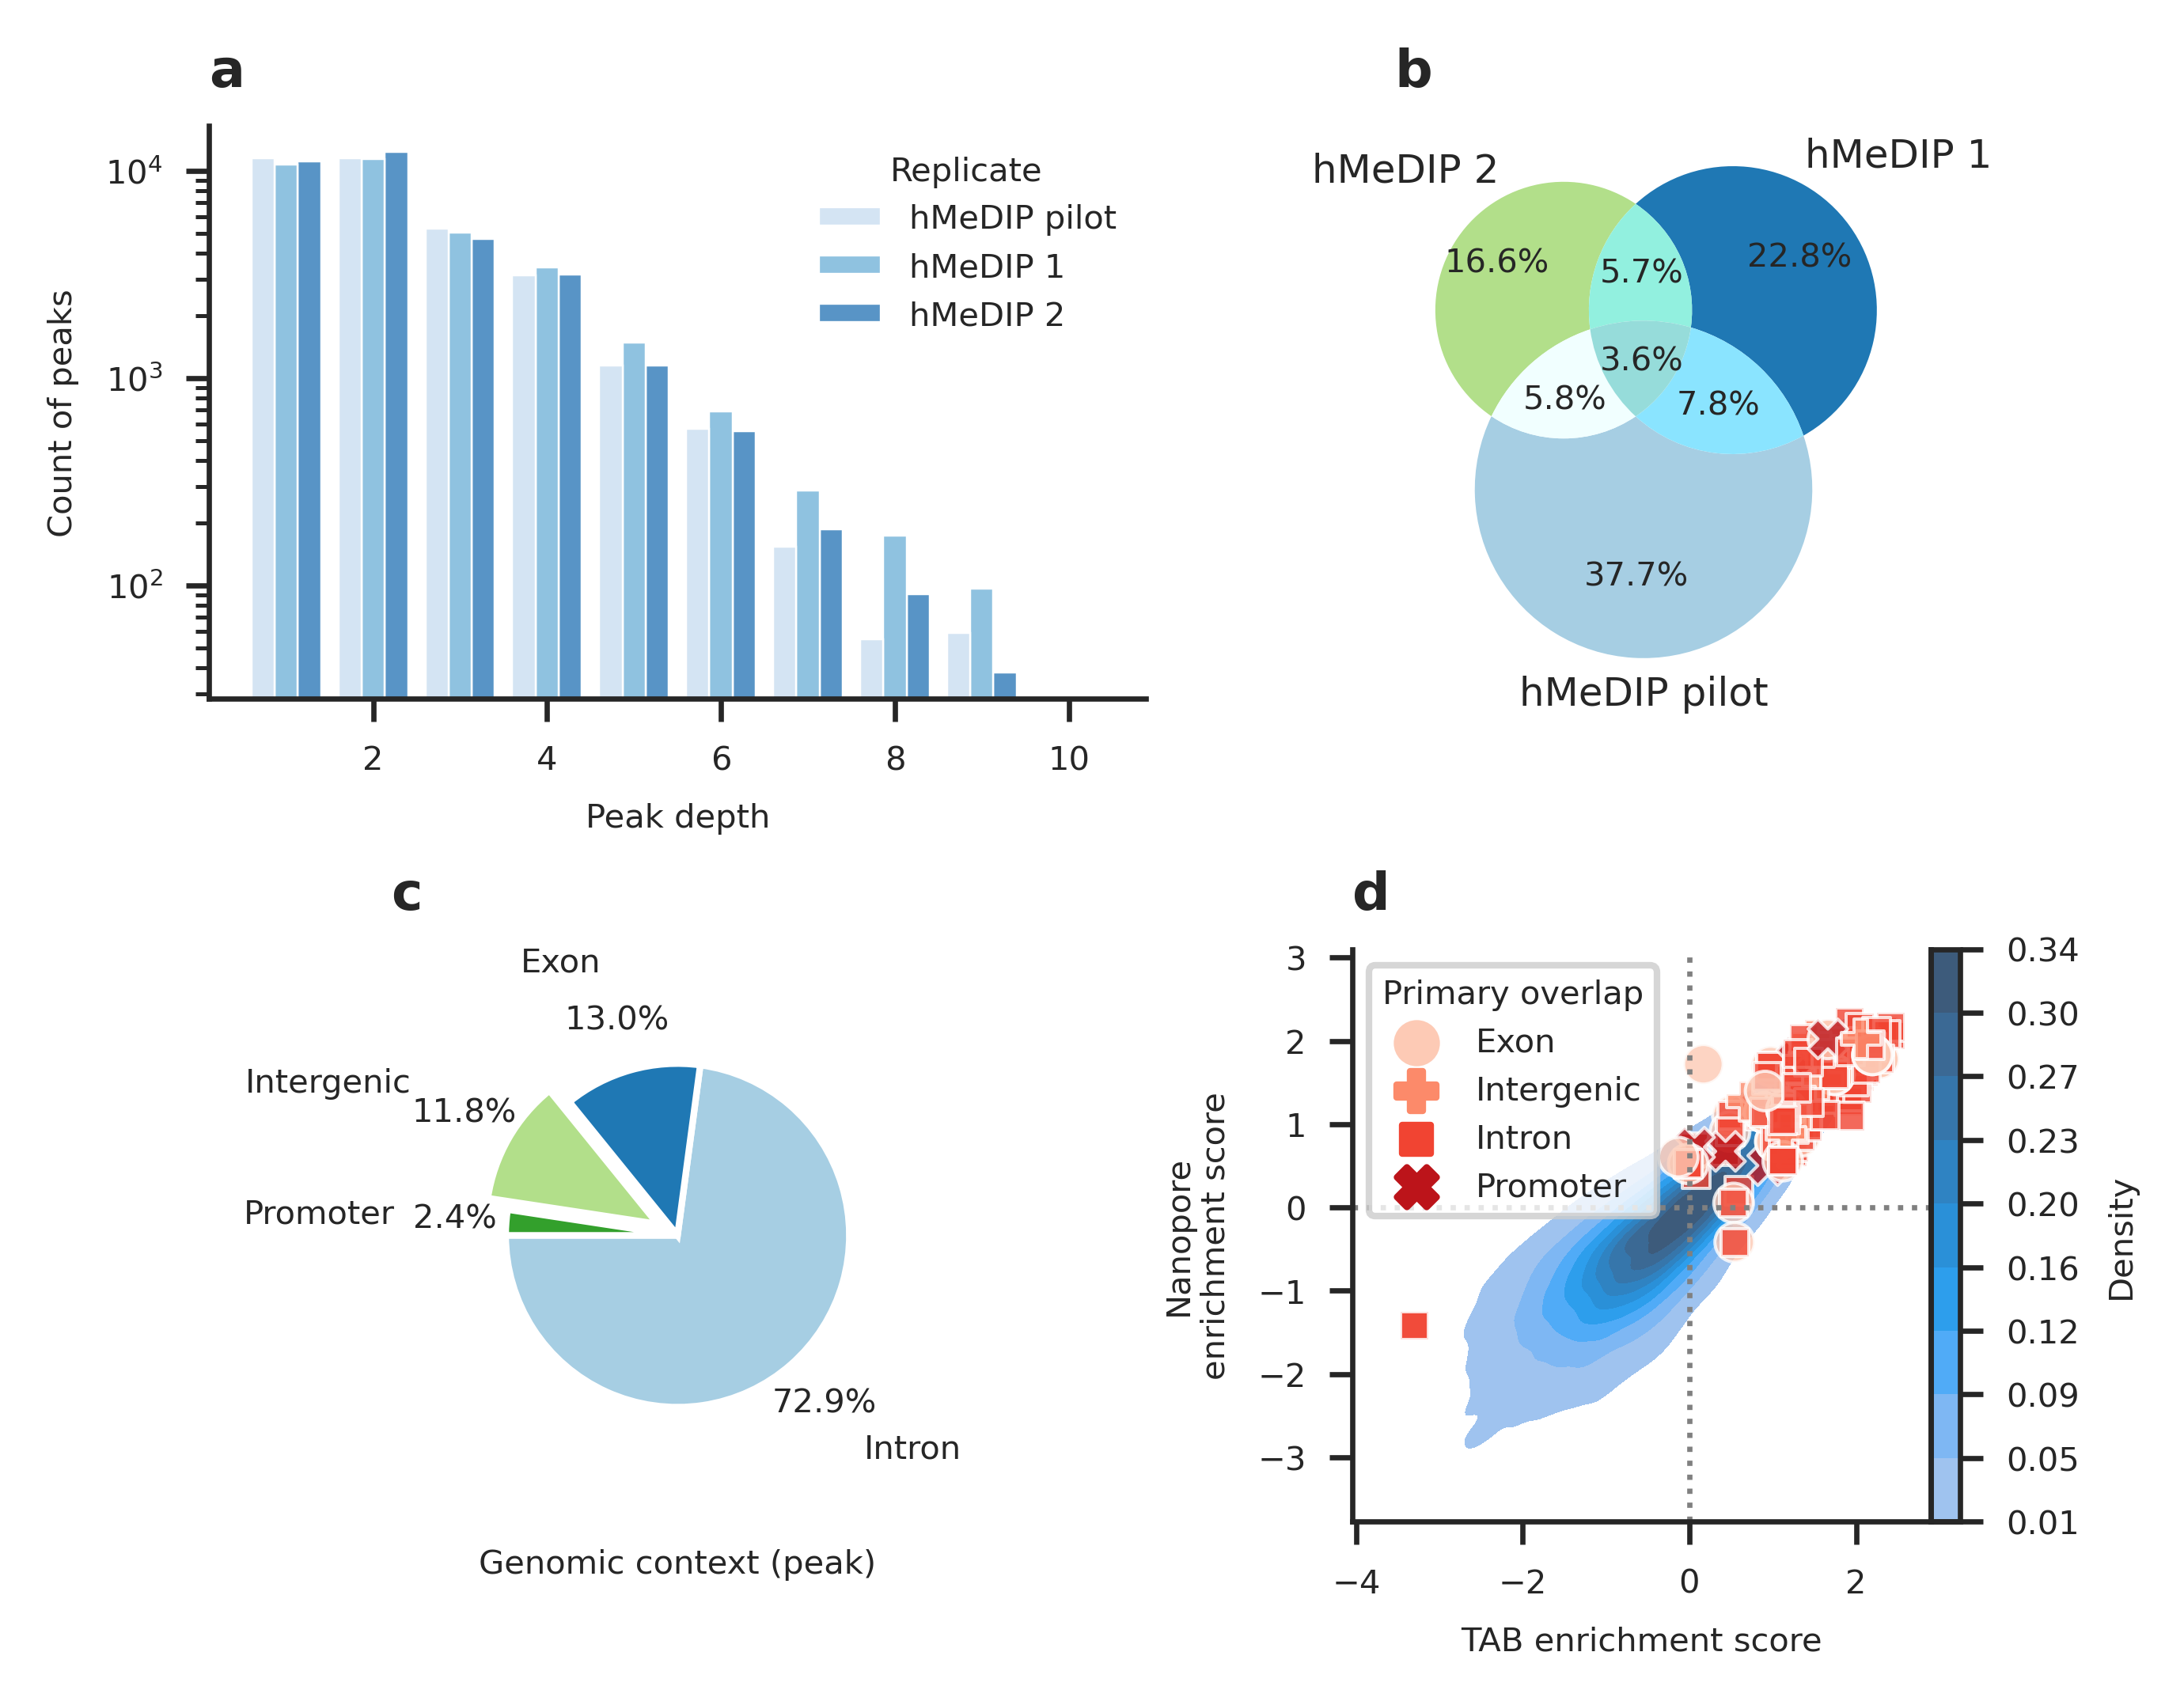

In [255]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib_venn import venn3
from matplotlib.patches import Patch
from PIL import Image
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(120/25.4, 90/25.4), dpi=600)
gs = GridSpec(2, 2, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

colors = [sns.color_palette("Paired", 4)[2], sns.color_palette("Paired", 4)[0], sns.color_palette("Paired", 4)[1], sns.color_palette("Paired", 4)[3]]

# Panel 1 # 
binmax = 10
sns.histplot(histplot_df, x="peakDepth", multiple="dodge", 
             hue="Replicate", hue_order=["hMeDIP pilot", "hMeDIP 1", "hMeDIP 2"], palette=sns.color_palette("Blues", 3),
             binrange=(1, binmax), discrete=True, shrink=0.8, log_scale=(False, True), element="bars",  
             ax=ax1)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
ax1.set_xlabel("Peak depth")
ax1.set_ylabel("Count of peaks")

sns.move_legend(ax1, "upper right", frameon=False)

# Panel 2 # 

VennDiagrammer(ip_r0_pr, ip_r1_pr, ip_r2_pr, ax=ax2)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

# Panel 3 # 
ax3.pie(pie_values, labels=pie_labels, startangle=180, explode=(0, 0, .1, 0), radius=0.75, 
        colors=sns.color_palette("Paired", 4), autopct="%1.1f%%",
        pctdistance=1.3, labeldistance=1.65)

ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
ax3.set_xlabel("Genomic context (peak)")

# Panel 4 # 

div = make_axes_locatable(ax4)
cax = div.append_axes("right", size="5%", pad=0)

sns.kdeplot(tiles.as_df().query("CpG_count >= 15"), 
            x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
            fill=True, 
            cbar=True, cbar_ax=cax, cbar_kws={"format" : "%2.2f",
                                              "label" : "Density"},
            ax=ax4)

sns.scatterplot(annotated_tiled_peaks.query("total_peakDepth >= 15 & total_peakDepth <= 30").sort_values(["total_peakDepth", "Primary overlap"]), 
               x="log2enrichment_5hmC_Nanopore", y="log2enrichment_5hmC_TAB", 
               alpha=.8, 
               style="Primary overlap", style_order=["Exon", "Promoter", "Intron", "Intergenic"],
               hue="Primary overlap", palette="Reds", 
               ax=ax4)

ax4.axvline(x=0, ls=":", c="grey", lw=0.8)
ax4.axhline(y=0, ls=":", c="grey", lw=0.8)
ax4.set_xlabel("TAB enrichment score")
ax4.set_ylabel("Nanopore\nenrichment score")
ax4.set_aspect("equal")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")
sns.move_legend(ax4, "upper left", frameon=True)

# Figure # 

sns.despine()
sns.despine(ax=ax5, bottom=True, left=True)

plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP_extras.png", dpi=600)


## Broad vs. narrow peaks

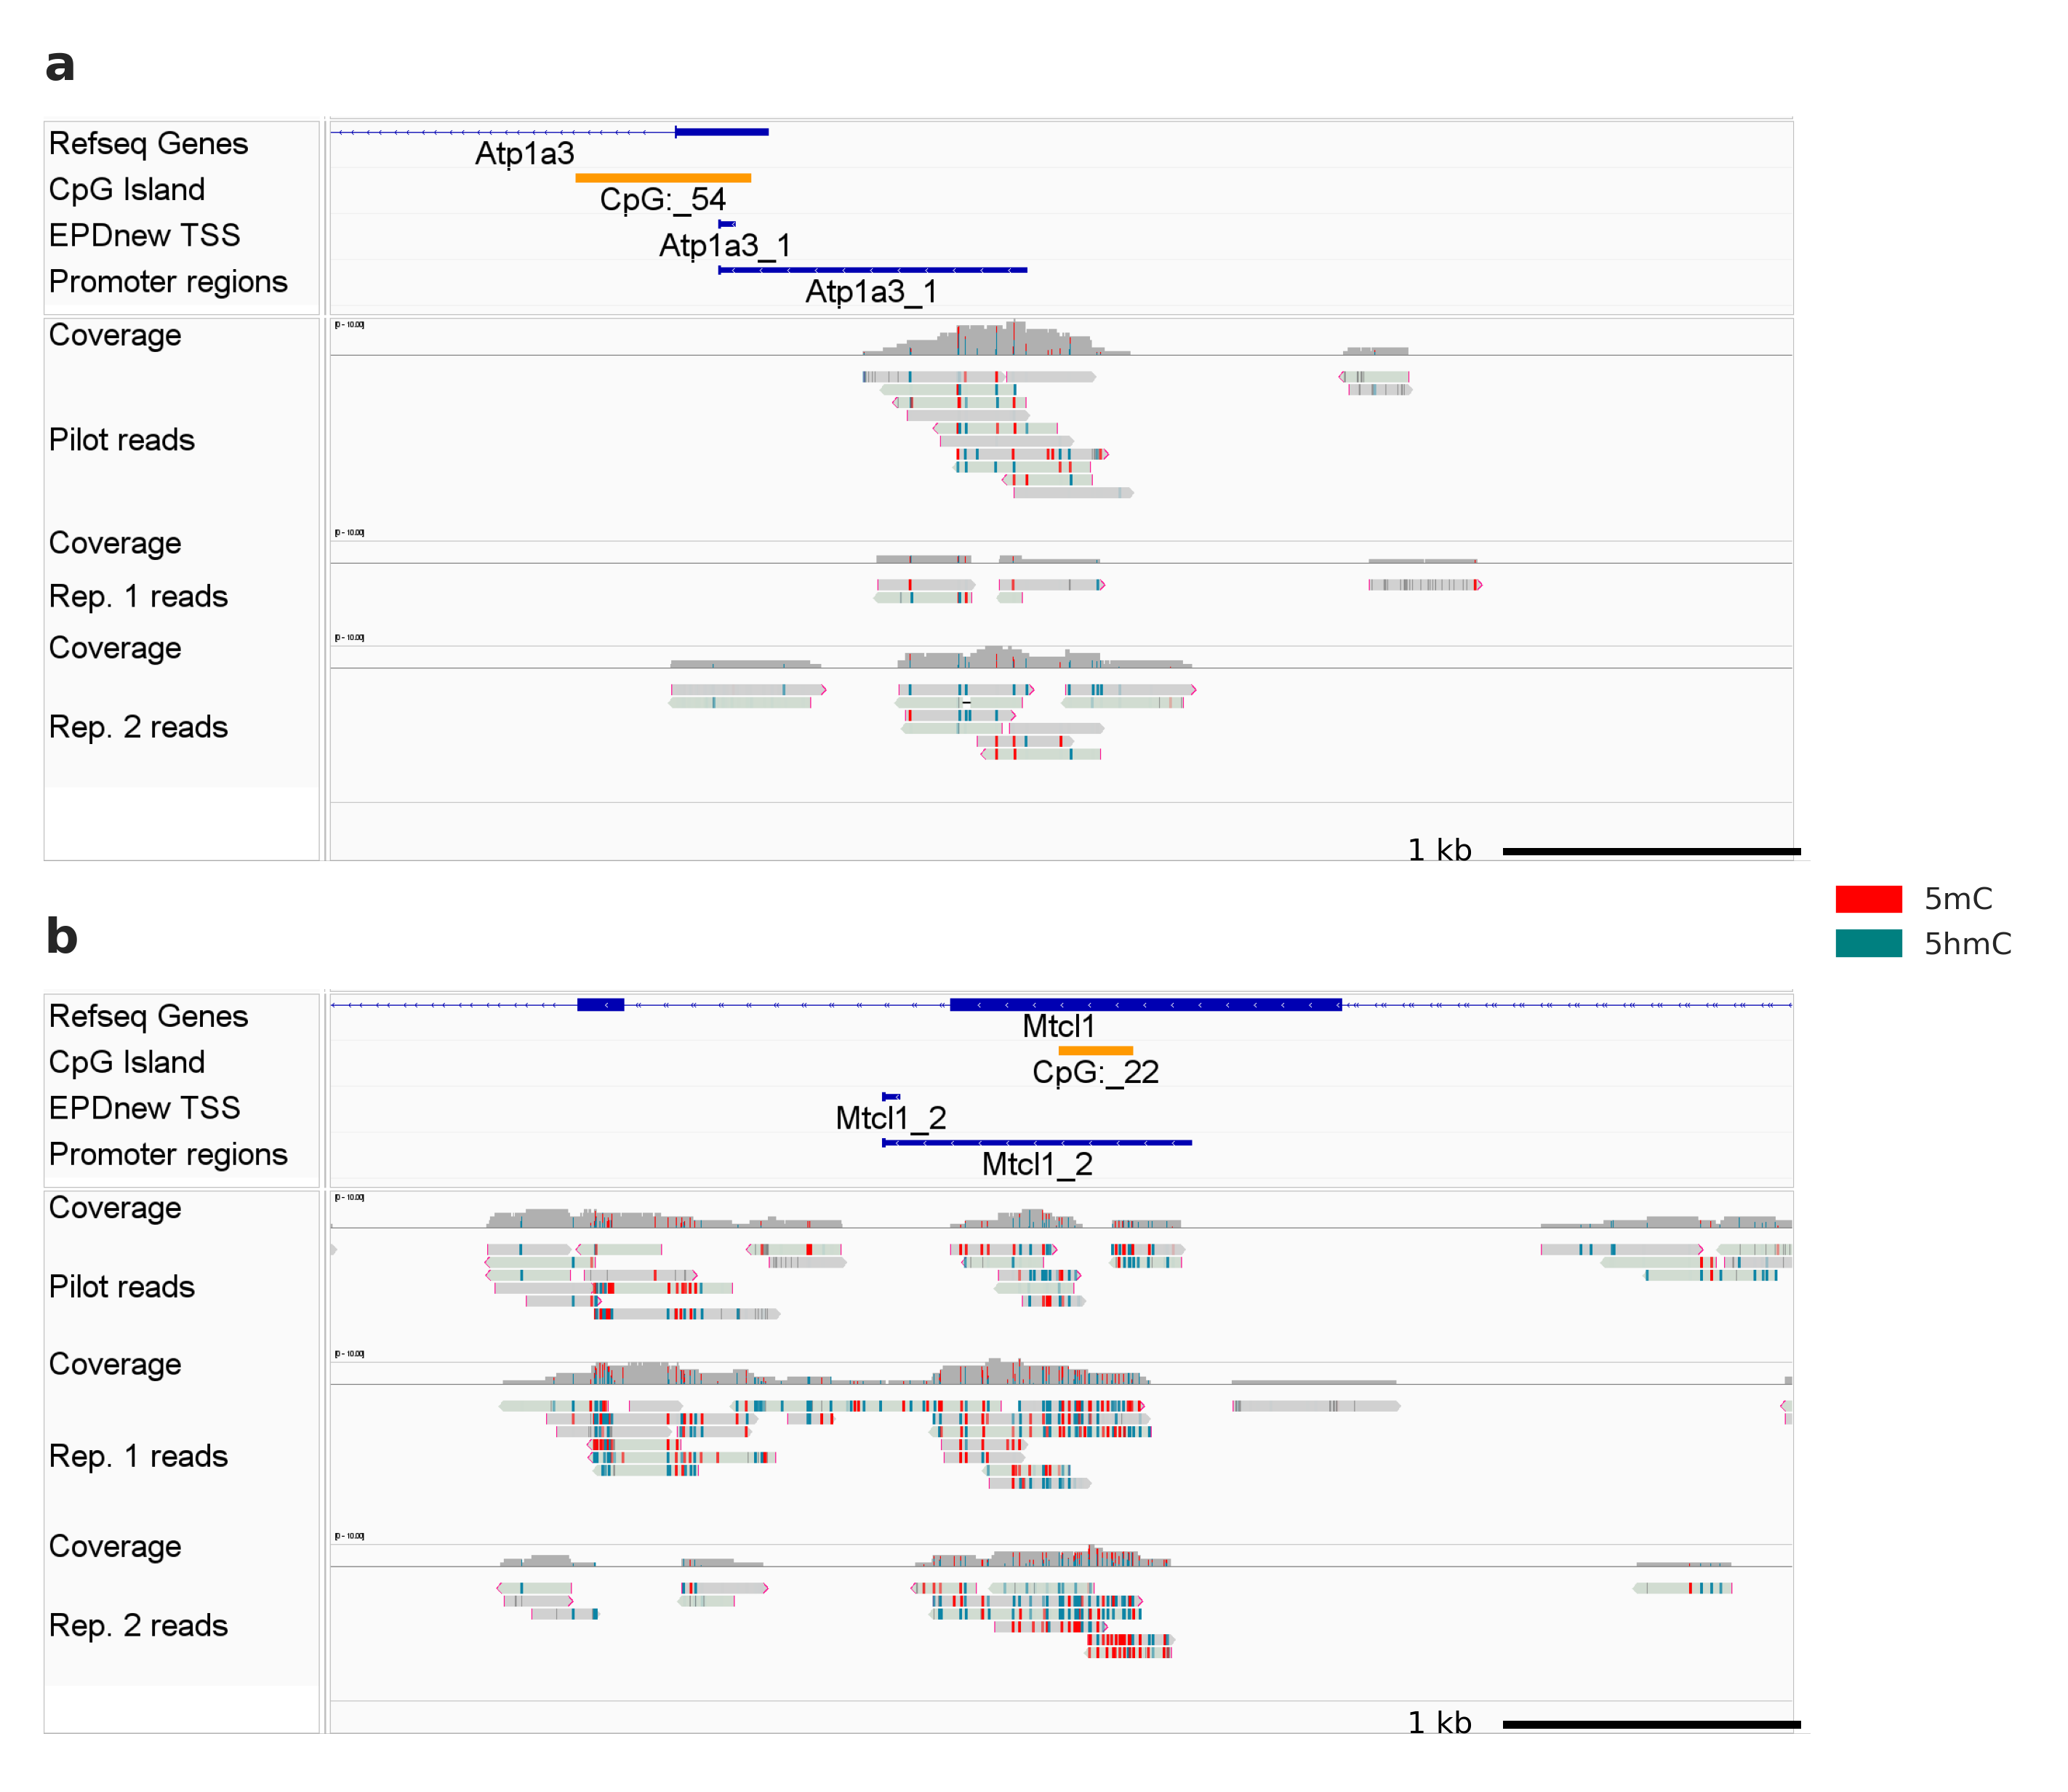

In [35]:
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib_scalebar
import matplotlib as mpl
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image

fig = plt.figure(figsize=(120/25.4, 100/25.4), dpi=600)
gs = GridSpec(2, 1, fig)

sns.set_style("ticks")
mpl.rc('font', size=5)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, :])
# ax3 = fig.add_subplot(gs[2, :])

# Panel 1 #
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
im1 = Image.open("data_tables/hmedip/rep_img_igv/narrow_peak_Atp1a3_mod.png")

w1, h1 = im1.size
imc = im1.crop((0, 125, w1, 950))

l1_elements = [Patch(facecolor='red', edgecolor='red',
                         label='5mC'),
              Patch(facecolor='teal', edgecolor='teal',
                         label='5hmC')] 

dim = matplotlib_scalebar.dimension._Dimension("bp")
dim.add_units("kb", 1000)

ax1.imshow(imc)
scalebar = ScaleBar(5000/(w1-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
ax1.add_artist(scalebar)

ax1.grid(False)

# ax1.axhline(700, .17, 0.98, lw=0.8, c="k")

# Panel 2 # 

im2 = Image.open("data_tables/hmedip/rep_img_igv/peak_Mtcl1_mod.png")
w2, h2 = im2.size
imc2 = im2.crop((0, 125, w2, 950))

ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

ax2.imshow(imc2)
scalebar2 = ScaleBar(5000/(w2-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
ax2.add_artist(scalebar2)

# Figure # 

for ax in [ax1, ax2]:
    ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

plt.figlegend(handles=l1_elements, loc="center right", alignment="left", bbox_to_anchor=(.99, 0.48), frameon=False)

# engine = fig.get_layout_engine()
# engine.set(rect=(-.05, 0, 1, .98))

sns.despine(left=True, bottom=True)
fig.subplots_adjust(top = .95, bottom = 0, right = .9, left = 0, 
            hspace = 0.15, wspace = 0)

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP_igv.png", dpi=600, pad_inches=0)

In [ ]:
# Panel 3 # 

im3 = Image.open("data_tables/hmedip/rep_img_igv/peak_Mtcl1_wg.png")
w3, h3 = im2.size
imc3 = im3.crop((0, 125, w3, 950))

ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
ax3.imshow(imc3)

scalebar3 = ScaleBar(140000/(w3-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
ax3.add_artist(scalebar3)

Note: First image from chr7:24,704,000-24,709,000.
Second image from chr17:66,684,000-66,689,000.

In [160]:
annotated_tiled_peaks.query("Start == 46364271")

Chromosome     Start       End  Name  Start_rep_1  End_rep_1  \
14201       chr7  46364271  46365870     7     46364869   46365145   
14202       chr7  46364271  46365870     7     46364869   46365145   
14203       chr7  46364271  46365870     7     46364869   46365145   
14204       chr7  46364271  46365870     7     46364869   46365145   
14205       chr7  46364271  46365870     7     46364869   46365145   
14206       chr7  46364271  46365870     7     46364869   46365145   
14207       chr7  46364271  46365870     7     46364869   46365145   
14208       chr7  46364271  46365870     7     46364869   46365145   

       Name_rep_1  Start_rep_2  End_rep_2  Name_rep_2  ...  \
14201           2     46364936   46367522           6  ...   
14202           2     46364936   46367522           6  ...   
14203           2     46364936   46367522           6  ...   
14204           2     46364936   46367522           6  ...   
14205           2     46364936   46367522           6  ...   
14206           2     46364936   46367522           6  ...   
14207           2     46364936   46367522           6  ...   
14208           2     46364936   46367522           6  ...   

       percentMeth_5hmC_TAB  CpG_count  log2enrichment_5hmC_Nanopore  \
14201             38.598485          8                       2.06581   
14202             38.598485          8                       2.06581   
14203             38.598485          8                       2.06581   
14204             38.598485          8                       2.06581   
14205             38.598485          8                       2.06581   
14206             38.598485          8                       2.06581   
14207             38.598485          8                       2.06581   
14208             38.598485          8                       2.06581   

       log2enrichment_5hmC_TAB  Overlap  Peak depth   Start_b     End_b  \
14201                 1.755803      870          14  46362151  46364433   
14202                 1.755803      870          14  46362382  46364338   
14203                 1.755803      870          14  46364338  46364524   
14204                 1.755803      870          14  46364524  46364528   
14205                 1.755803      870          14  46364528  46365070   
14206                 1.755803      870          14  46365070  46365124   
14207                 1.755803      870          14  46365113  46366173   
14208                 1.755803      870          14  46365113  46365173   

       Strand Primary overlap  
14201       -          Intron  
14202       -            Exon  
14203       -            Exon  
14204       -            Exon  
14205       -          Intron  
14206       -            Exon  
14207       -        Promoter  
14208       -        Promoter  

[8 rows x 24 columns]

In [159]:
promoters = annotated_tiled_peaks.copy().rename(columns={"Primary overlap" : "feature_type"}).query("total_peakDepth >= 15 & total_peakDepth <= 30 & feature_type == 'Promoter'")
promoters = promoters.loc[:, ("Chromosome", 	"Start"	, "End",  "total_peakDepth",  "log2enrichment_5hmC_Nanopore", 	"log2enrichment_5hmC_TAB" , "feature_type")]
promoters.sort_values(["log2enrichment_5hmC_Nanopore", 	"log2enrichment_5hmC_TAB"], ascending=False)

Chromosome      Start        End  total_peakDepth  \
14207       chr7   46364271   46365870               15   
14208       chr7   46364271   46365870               15   
31474      chr17   66686124   66686573               18   
31807      chr17   66686678   66686912               15   
14273       chr7   24705825   24706737               16   
15215       chr8   22965275   22966227               15   
16621       chr8  126297016  126297611               15   
33202      chr19   11888303   11889234               15   
10788       chr5   66776661   66777254               15   
20387      chr10  121147406  121148027               15   
21504      chr11  116546655  116547431               15   
23807      chr12   76127315   76128217               15   

       log2enrichment_5hmC_Nanopore  log2enrichment_5hmC_TAB feature_type  
14207                      2.065810                 1.755803     Promoter  
14208                      2.065810                 1.755803     Promoter  
31474                      1.661726                 2.023755     Promoter  
31807                      1.661726                 2.023755     Promoter  
14273                      1.481328                 1.801882     Promoter  
15215                      1.346106                 1.368804     Promoter  
16621                      1.307922                 1.812580     Promoter  
33202                      1.285938                 1.766007     Promoter  
10788                      0.939602                 0.502702     Promoter  
20387                      0.845676                 1.200865     Promoter  
21504                      0.433226                 0.673533     Promoter  
23807                      0.061396                 0.723921     Promoter